In [ ]:
# Debajo hay una celda de configuración que justifica el texto de los parrafos
# Debajo hay una celda de configuración que acorta el espacio entre parrafos

<style>
  /* JupyterLab / VS Code */
  .jp-RenderedHTMLCommon p { text-align: justify; }
  /* Jupyter clásico (por las dudas) */
  .text_cell_render p { text-align: justify; }
</style>

<style>
/* Menor espacio entre párrafos */
.jp-RenderedHTMLCommon p, .text_cell_render p {
    margin-top: 0.4em !important;
    margin-bottom: 0.4em !important;
    line-height: 1.4; /* más compacto */
}
</style>

# IAA-2025-2C: Segundo entregable



---

#### 1. Completar los autores y los datos de referencia del TP:
**Grupo:** 4

**Integrante:** Bruno Inguanzo | e-mail: brunoinguanzo14@gmail.com

**Integrante:** Javier Gonzalo Valdez | e-mail: JavierValdez145@gmail.com

**Integrante:** Matías Alejandro Vergara Vicencio | e-mail: mavergaravicencio@estudiantes.unsam.edu.ar     

**Título del entregable:** IAA-2025-2C_2do-entregable

**Enlace al conjunto de datos original:** [Default of Credit Card Clients](https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients)

#### Carga y transformación del dataset

In [1]:
# @title
# Importamos librerías a utilizar
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils._plotting")
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

gotham = fm.FontProperties(fname='Gotham-Book.otf')
gotham_bold = fm.FontProperties(fname='GOTHAM-BOLD.TTF')

In [2]:
# @title
# Cargamos el dataset desde el repo de UCI ML

# df = fetch_ucirepo(id=350).data.original
df = pd.read_csv("credit_defaults.csv", header=1, sep=";")

In [3]:
df.shape

(30000, 25)

In [4]:
# @title
# Eliminamos la columna ID porque no suma a nuestro análisis

df = df.drop('ID', axis=1)

In [5]:
# @title
# Definimos una lista con los nombres de los meses para renombrar las columnas y mejorar la interpretabilidad

meses = ['abr','may','jun','jul','ago','sep']

In [6]:
# @title
# Generamos nombres nuevos para las columnas por mes (meses de deuda, factura por mes, pago por mes)

meses_deuda = [f'meses_deuda_{mes}' for mes in meses]
meses_pago = [f'pago_{mes}' for mes in meses]
meses_factura = [f'factura_{mes}' for mes in meses]

In [7]:
# @title
# Definimos una lista con los nuevos nombres de las columnas y modificamos los nombres antiguos

nuevas_cols = ['limite_credito','genero','educacion','estado_civil','edad'] + meses_deuda + meses_pago + meses_factura + ['default_oct']
df.columns = nuevas_cols

In [8]:
frecuencias = df['educacion'].value_counts().sort_index()
frecuencias

educacion
0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: count, dtype: int64

In [9]:
df['educacion'] = df['educacion'].replace({0: 4, 5: 4, 6: 4})

In [10]:
frecuencias = df['estado_civil'].value_counts().sort_index()
frecuencias

estado_civil
0       54
1    13659
2    15964
3      323
Name: count, dtype: int64

In [11]:
df['estado_civil'] = df['estado_civil'].replace({0: 3})

In [12]:
def check_transitions(row):
    prev = row[0]
    for nxt in row[1:]:
        # Caso de no consumo o pago completo
        if prev in [-2, -1] and nxt >= 2:
            return False
        # Caso de revolving
        if prev == 0 and nxt >= 3:
            return False
        # Caso de atrasos
        if prev >= 1 and nxt > prev + 1:
            return False
        prev = nxt
    return True

mask_validos = df[meses_deuda].apply(check_transitions, axis=1)
df_validos = df[mask_validos]
df_invalidos = df[~mask_validos]

C:\Users\matia\AppData\Local\Temp\ipykernel_19948\9113361.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prev = row[0]


In [13]:
df_invalidos[meses_deuda].head()

,meses_deuda_abr,meses_deuda_may,meses_deuda_jun,meses_deuda_jul,meses_deuda_ago,meses_deuda_sep
1,-1,2,0,0,0,2
11,-1,-1,-1,-1,-1,2
39,-1,-1,2,-1,0,-1
58,-1,3,2,2,2,2
65,-2,-2,-2,-1,2,2


In [14]:
df = df_validos

In [15]:
cond = (
    (df['factura_sep'] < df['pago_sep']) &       # Filtramos registros con facturas menores a los pagos (podría ser por pago de factura actual + deudas)
     (df['meses_deuda_sep'] < 0) &           # Y no uso o la uso y la pago
      (df['meses_deuda_ago'] < 0) # No uso o pago
)

In [16]:
df = df[~cond]

In [17]:
# @title
# Guardamos los indices de las variables de septiembre para filtrar el dataset completo y filtramos el dataset original para quedarnos solo con limite + demograficas + septiembre

indices_septiembre = [i for i, col in enumerate(df.columns) if 'sep' in col]
df = df.iloc[:, list(range(5)) + indices_septiembre + [-1]]

In [18]:
df.shape

(25492, 9)

In [19]:
df.head()

,limite_credito,genero,educacion,estado_civil,edad,meses_deuda_sep,pago_sep,factura_sep,default_oct
0,20000,2,2,1,24,-2,0,0,1
2,90000,2,2,2,34,0,15549,5000,0
3,50000,2,2,1,37,0,29547,1000,0
4,50000,1,2,1,57,0,19131,679,0
5,50000,1,1,2,37,0,20024,800,0


---
#### 2. Elaborar un resumen de hasta 100 palabras que plantee los objetivos del trabajo, y los logros que consideran alcanzados hasta esta entrega.


Este trabajo busca desarrollar un modelo de *machine learning* que prediga el default de una tarjeta de crédito para un mes determinado, utilizando información del mes previo y datos demográficos del cliente. Se prioriza ***maximizar el recall*** para detectar la mayor cantidad posible de deudores potenciales, dado el alto costo de no identificarlos. Tras depurar el dataset, se eliminaron 4508 registros inconsistentes, quedando 25492 observaciones finales. El análisis de correlaciones destacó que los meses de deuda acumulados y el límite de crédito son los predictores del default más prometedores.

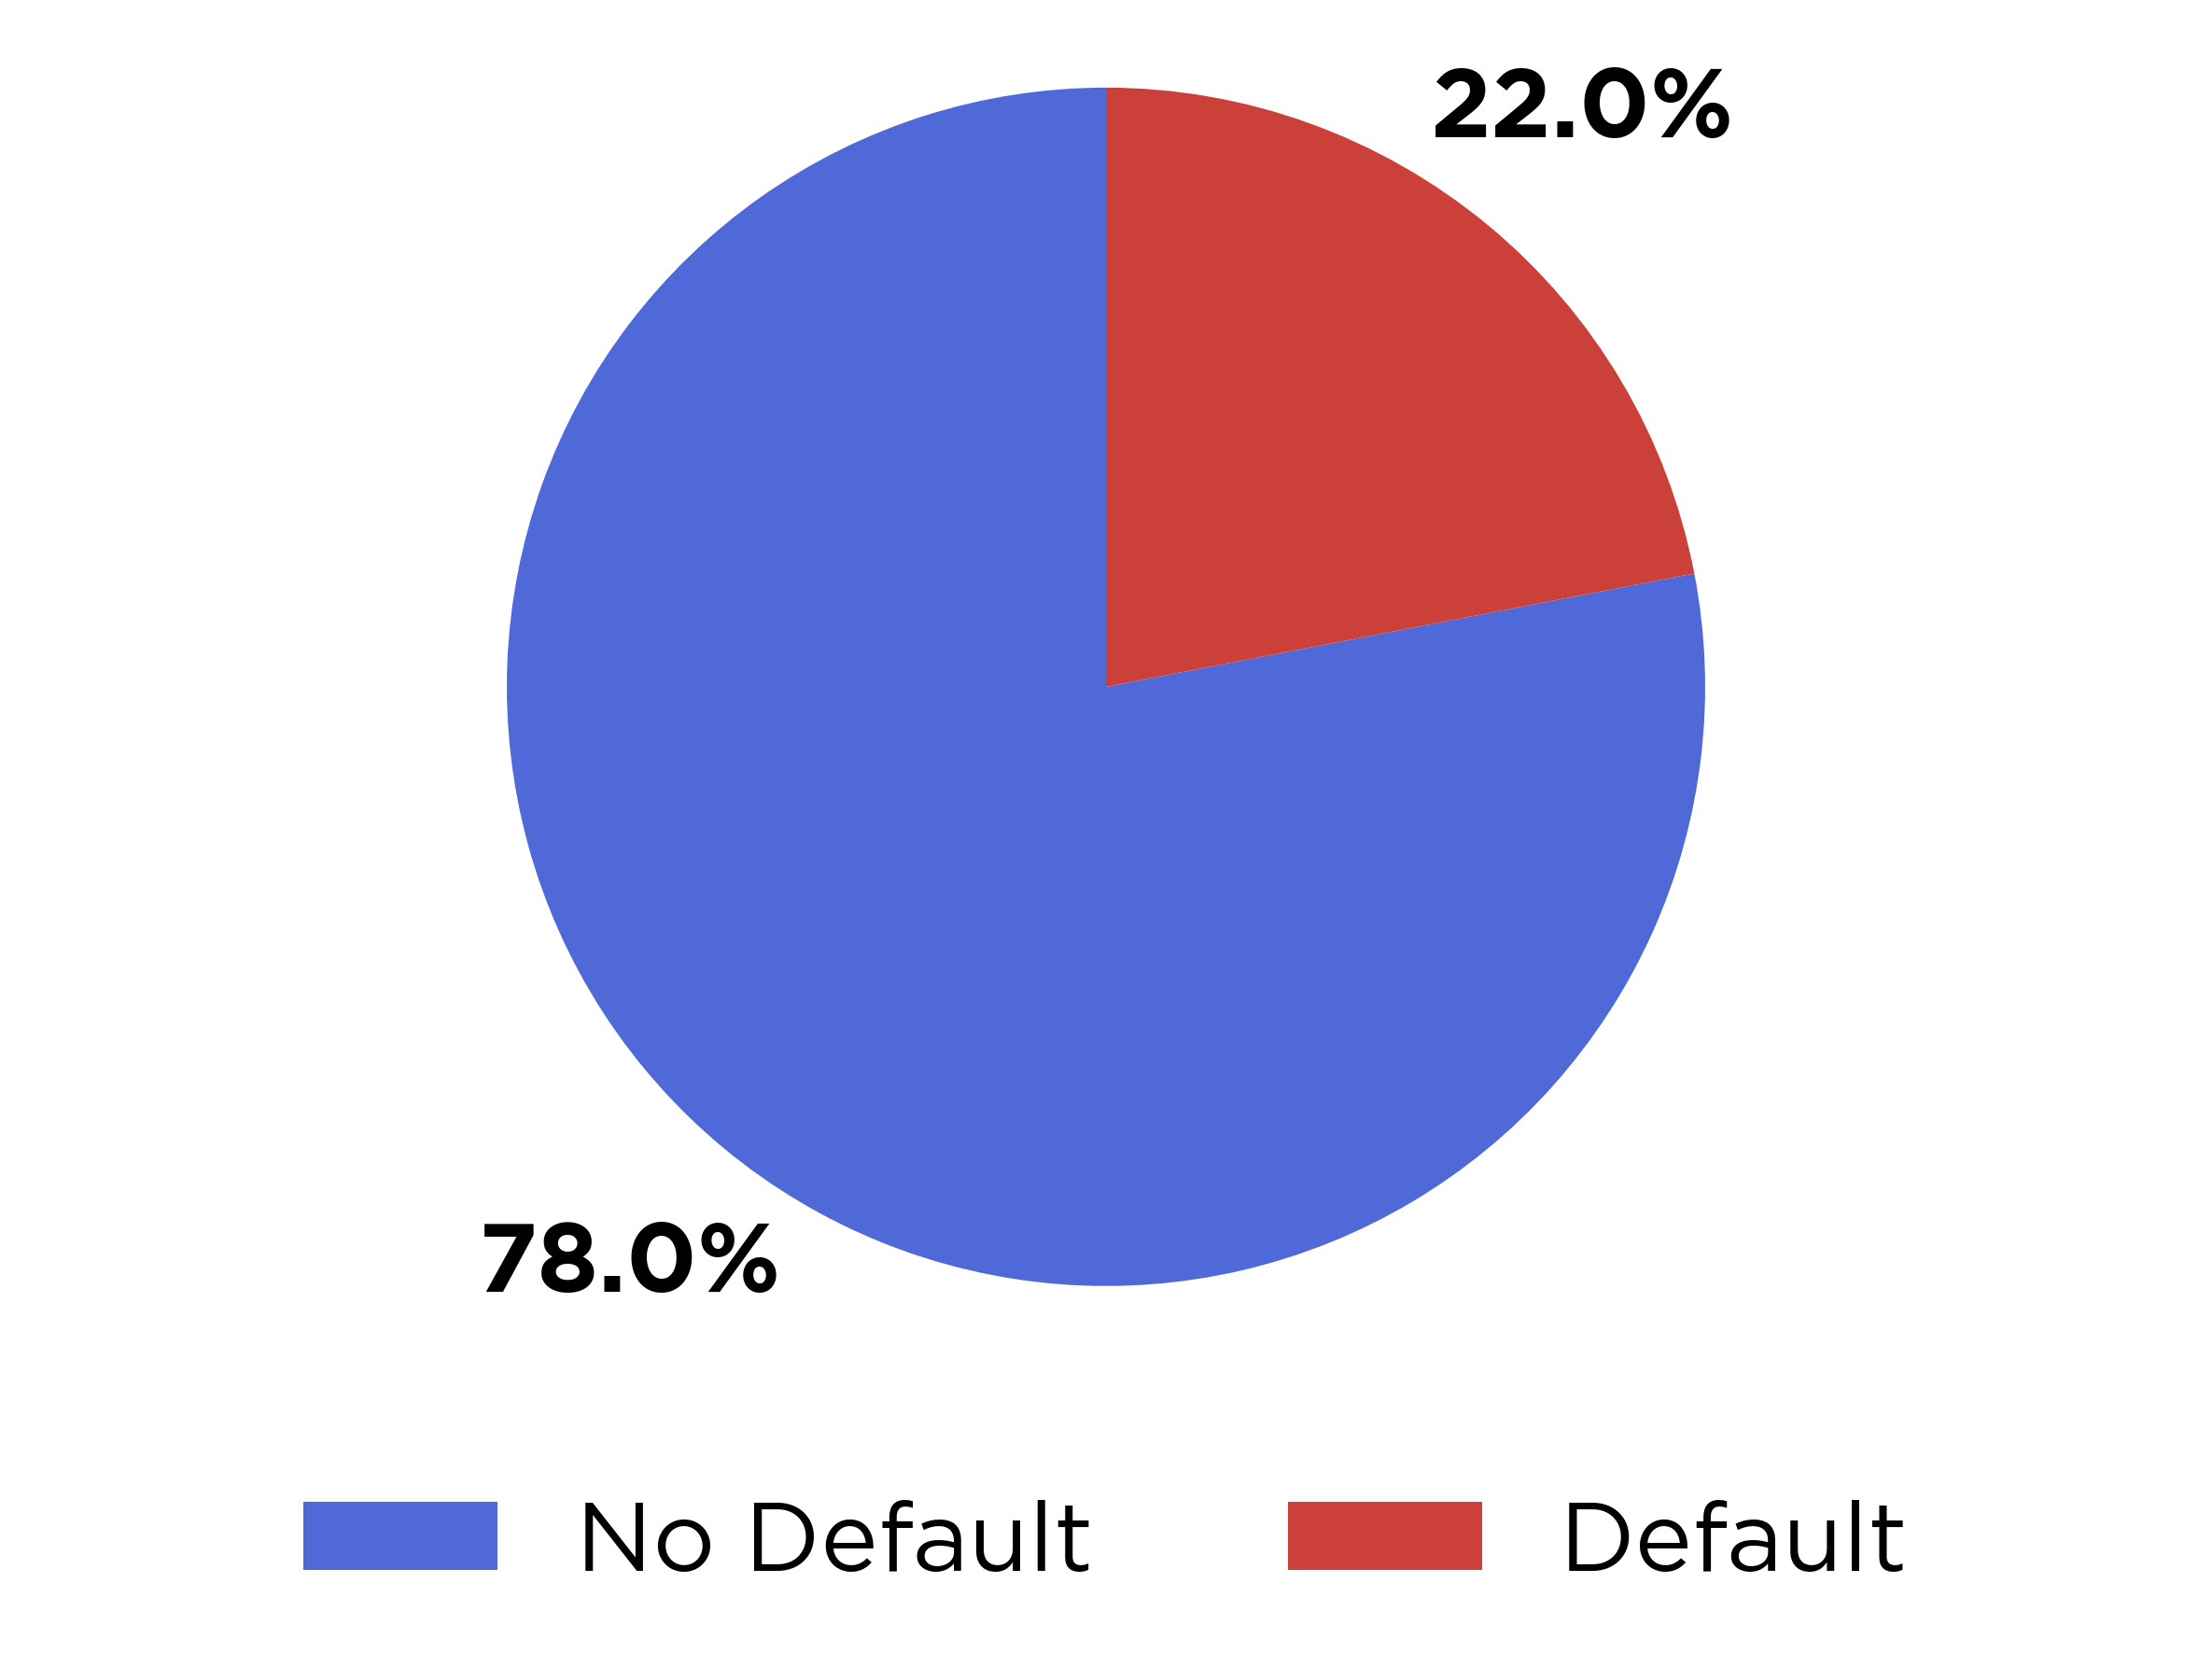

In [20]:
import matplotlib.pyplot as plt

# Calcular las proporciones de cada clase
conteos = df['default_oct'].value_counts()

# Definir etiquetas y colores
labels = ['No Default', 'Default']
colors = ["#4F69D9", "#CC403A"]  # Verde para negativo (0), Rojo para positivo (1)

# Crear el pie chart
plt.figure(figsize=(8, 6), dpi=300)
wedges, texts, autotexts = plt.pie(
    conteos, 
    colors=colors, 
    autopct='%1.1f%%', 
    startangle=90,
    pctdistance=1.25
)  # Porcentajes fuera del pie chart

# Ajustar el estilo de los porcentajes
gotham_bold.set_size(25)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_font_properties(gotham_bold)

#plt.title('Proporción de Clases - Default Octubre', fontsize=14, fontweight='bold', pad=20)

# Agregar leyenda debajo del gráfico
gotham.set_size(25)
plt.legend(
    labels, 
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.05), 
    ncol=2, frameon=False, 
    prop=gotham
)

plt.axis('equal')
plt.tight_layout()
plt.show()

---
#### 3. Proponer un modelo de referencia (benchmark). ¿Qué desempeño tiene dicho modelo? El benchmark es un modelo simple, de fácil interpretación, que fija un desempeño mínimo contra el que comparar a los sucesivos modelos de creciente complejidad.


### Procesamiento del dataset

Antes de definir nuestros modelos, vamos a realizar un poco de ***feature engineering*** en nuestro conjunto de datos. 

En primer lugar tratamos a la columna `meses_deuda_sep`, que era un problema porque la codificación representaba cosas distintas. En base a criterios lógicos, descompusimos la columna original en diferentes *features* (`tiene_deuda_sep`, `n_meses_deuda_sep`, `sin_uso_sep`,`pago_minimo_sep`, `pago_completo_sep`) que aportan mayor información sobre el comportamiento crediticio de los clientes, y logran que la cantidad de meses adeudados esten correctamente representados. Luego de esto, eliminamos la variable original para evitar redundancia y multicolinealidad.

In [20]:
def preprocesar_meses_deuda(df):
    df = df.copy()
    # 1. Indicador de deuda real (1+ meses)
    df['tiene_deuda_sep'] = (df['meses_deuda_sep'] >= 1).astype(int)
    
    # 2. Cantidad de meses adeudados (solo si hay deuda)
    df['n_meses_deuda_sep'] = df['meses_deuda_sep'].clip(lower=0)
    
    # 3. Indicadores de comportamiento especial
    df['sin_uso_sep'] = (df['meses_deuda_sep'] == -2).astype(int)
    df['pago_minimo_sep'] = (df['meses_deuda_sep'] == 0).astype(int)
    df['pago_completo_sep'] = (df['meses_deuda_sep'] == -1).astype(int)
    
    return df

df = preprocesar_meses_deuda(df)

En segundo lugar, creamos dos *features* más que muestran dos relaciones entre nuestras variables que podrían ser relevantes para predecir un impago: el *ratio* de utilización sobre el límite disponible, que representa en que proporción un determinado cliente usa el crédito otorgado por la entidad financiera, y el *ratio* de pago sobre la factura del mes, que nos indica el compromiso de pago del cliente sobre el total de la factura que recibe.

In [21]:
def crear_features_avanzadas(df):
    df = df.copy()
    # 1. Ratio de utilización (cuánto del crédito se facturó en septiembre)
    df['ratio_uso_sep'] = df['factura_sep'] / df['limite_credito']
    df['ratio_uso_sep'] = df['ratio_uso_sep'].clip(0, 1)
    
    # 2. Ratio de pago (¿cuánto pagó vs cuánto debía?)
    df['ratio_pago_sep'] = df['pago_sep'] / (df['factura_sep'] + 1)  # +1 para evitar div/0
    df['ratio_pago_sep'] = df['ratio_pago_sep'].clip(0, 2)  # Limitar valores extremos

    return df

df = crear_features_avanzadas(df)

df = df.drop(columns='meses_deuda_sep')

In [38]:
df['limite_credito'].describe()


count      25492.000000
mean      163228.843559
std       128605.000470
min        10000.000000
25%        50000.000000
50%       130000.000000
75%       230000.000000
max      1000000.000000
Name: limite_credito, dtype: float64

In [22]:
Q1 = df['limite_credito'].quantile(0.25)
Q3 = df['limite_credito'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['limite_credito'] < limite_inferior) | (df['limite_credito'] > limite_superior)]
print(f'Cantidad de outliers: {len(outliers)}')


Cantidad de outliers: 174


In [26]:
plt.figure(figsize=(8,5), dpi=300)

ax = sns.histplot(
    data=df,
    x='limite_credito',
    hue='default_oct',   # 0 o 1
    bins=30,
    kde=True,
    element='step',
    palette={0: '#4F69D9', 1: '#CC403A'}
)
plt.xlim(0, 1_000_000)
gotham.set_size(13)
ax.set_xlabel("Límite de crédito [NT$]", labelpad=5, fontproperties=gotham)
ax.set_ylabel("Frecuencia", labelpad=5, fontproperties=gotham)
gotham_bold.set_size(15)
ax.set_title('Distribución de Límite de Crédito según Default', fontproperties=gotham_bold)

gotham.set_size(10)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(gotham)

ax.ticklabel_format(style='plain', axis='x')

# Personalizar la leyenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#4F69D9', label='No default'),
    Patch(facecolor='#CC403A', label='Default')
]
ax.legend(handles=legend_elements, title='', prop=gotham)

plt.show()

### Dummy Classifier

Luego de terminar realizar estas transformaciones, establecimos como modelo de referencia un clasificador aleatorio estratificado (usando ``` DummyClassifier ``` de *scikit-learn*) que respeta las proporciones de clases del *dataset*. Este ***benchmark*** obtiene un ***recall*** y un ***F1-score*** de **20%** en ambos casos, reflejando un desempeño equivalente a adivinar al azar según el desbalanceo de nuestra clase a predecir (aproximadamente 22-23% de casos de *default*). Este resultado establece nuestra línea base que cualquier modelo que propongamos debe superar para ser considerado útil desde el punto de vista del negocio. 

In [23]:
# Modelo benchmark: predice aleatoriamente respetando proporciones
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn.model_selection import train_test_split

# Train-test
X = df.drop('default_oct', axis=1)
y = df['default_oct']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Definicion de modelo
dummy = DummyClassifier(
    strategy='stratified', 
    random_state=42
)

# Fit del modelo
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)
y_pred_proba = dummy.predict_proba(X_test)[:, 1]

# Metricas
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred, pos_label=1):.3f}")
print(f"Precision: {precision_score(y_test, y_pred, pos_label=1, zero_division=0):.3f}")
print(f"F1-Score: {f1_score(y_test, y_pred, pos_label=1):.3f}")
print(f"ROC-AUC score: {roc_auc_score(y_test, y_pred_proba):.3f}")

Accuracy: 0.651
Recall: 0.200
Precision: 0.202
F1-Score: 0.201
ROC-AUC score: 0.489


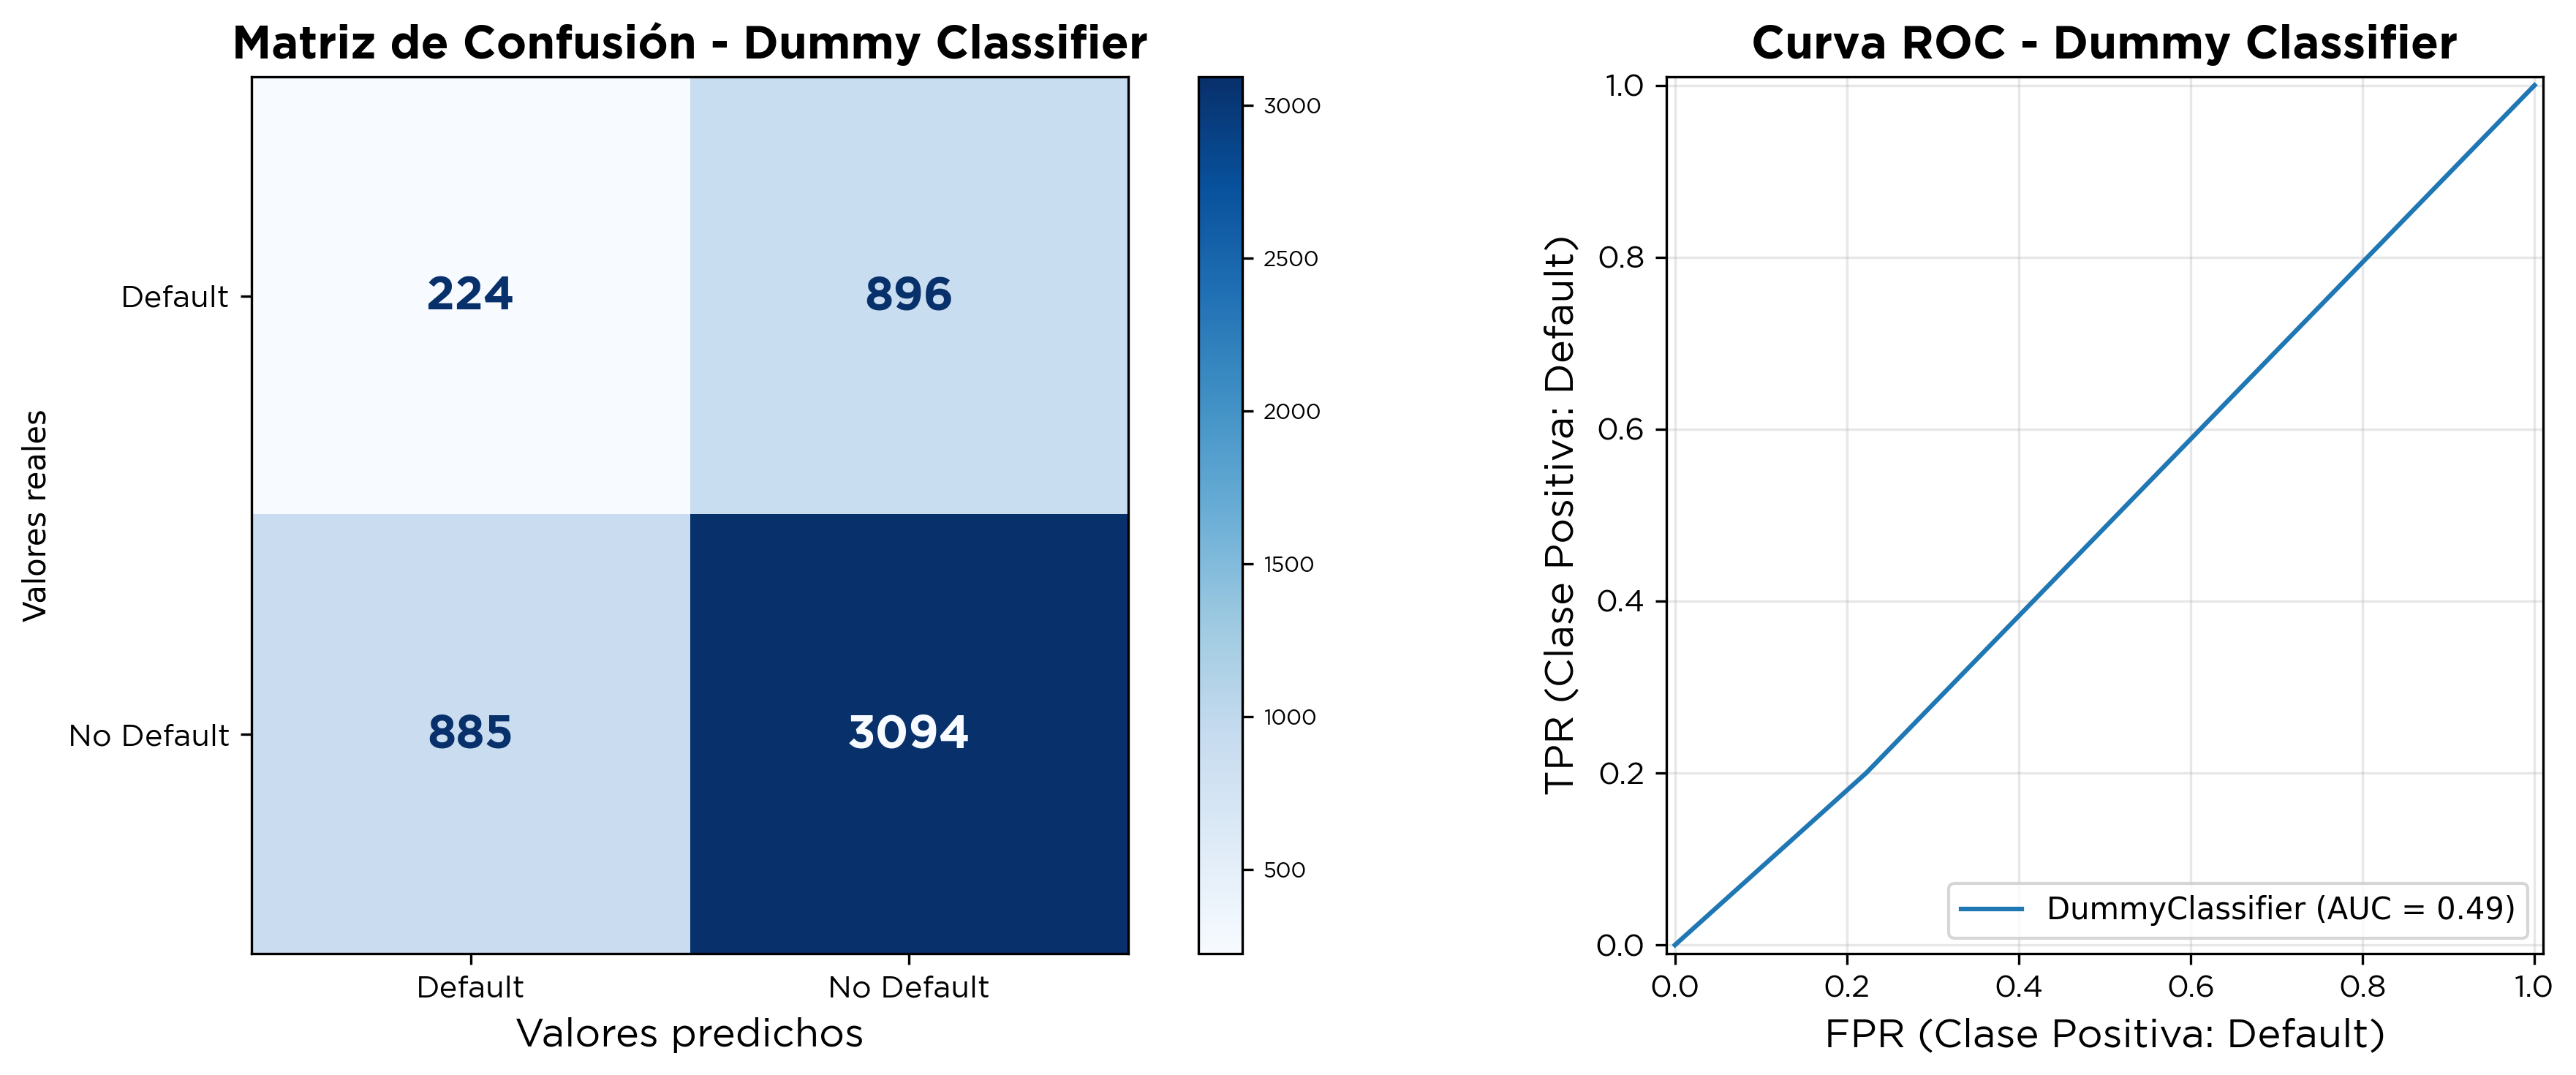

In [24]:
import matplotlib.pyplot as plt

# Visualización
fig, axes = plt.subplots(1,2,figsize=(14,5), dpi=300)

# Matriz de confusión
dummy_cm = ConfusionMatrixDisplay.from_estimator(
    dummy, X_test, y_test,
    cmap=plt.cm.Blues,
    labels=[1,0],
    display_labels=['Default', 'No Default'],
    colorbar=True,
    ax=axes[0])
# Aumentar tamaño del texto dentro de la matriz
gotham_bold.set_size(15)
for text in dummy_cm.text_.ravel():   # Cambiá el número según prefieras
    text.set_font_properties(gotham_bold)

gotham.set_size(13)
axes[0].set_xlabel("Valores predichos", labelpad=5, fontproperties=gotham)
axes[0].set_ylabel("Valores reales", labelpad=5)
gotham_bold.set_size(15)
axes[0].set_title('Matriz de Confusión - Dummy Classifier', fontproperties=gotham_bold)

# Gráfico Curva ROC
dummy_roc = RocCurveDisplay.from_estimator(
    dummy, X_test, y_test,
    ax=axes[1])
axes[1].set_xlabel('FPR (Clase Positiva: Default)', fontproperties=gotham, labelpad=5)
axes[1].set_ylabel('TPR (Clase Positiva: Default)', fontproperties=gotham, labelpad=5)
axes[1].set_title('Curva ROC - Dummy Classifier', fontproperties=gotham_bold)
axes[1].grid(alpha=0.3, axis='both')

gotham.set_size(10)
for ax in axes:
    for label in ax.get_xticklabels():
        label.set_fontproperties(gotham)
        
    for label in ax.get_yticklabels():
        label.set_fontproperties(gotham)

cbar = dummy_cm.im_.colorbar
gotham.set_size(7)
for label in cbar.ax.get_yticklabels():
    label.set_fontproperties(gotham)

plt.tight_layout()
plt.show()

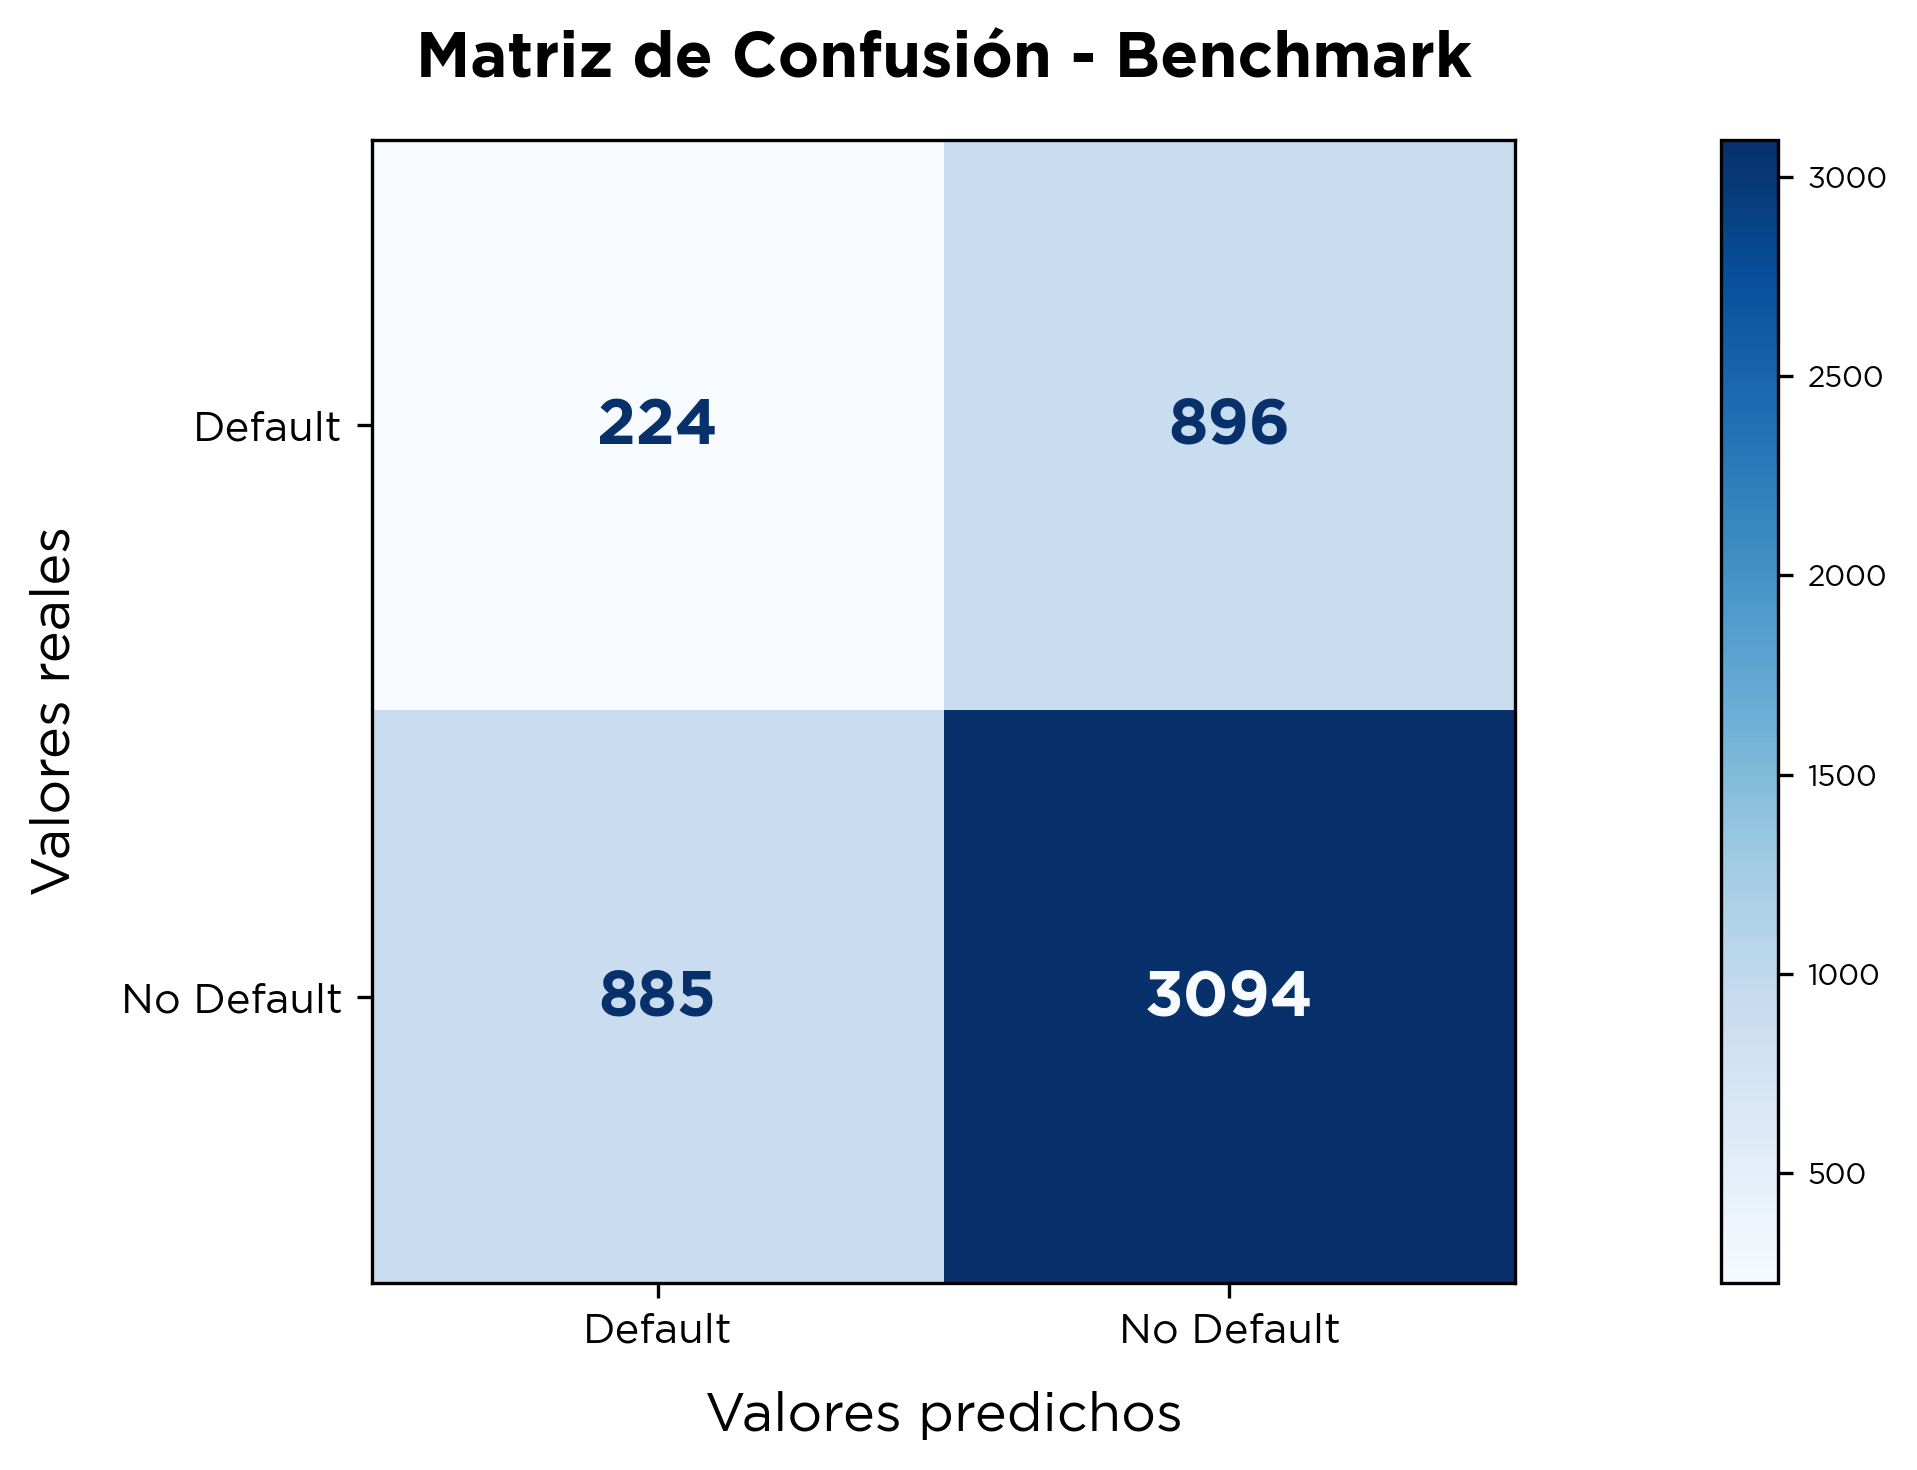

In [29]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


# Visualización
fig, axes = plt.subplots(1,1,figsize=(14,5), dpi=300)

# Matriz de confusión
dummy_cm = ConfusionMatrixDisplay.from_estimator(
    dummy, X_test, y_test,
    cmap=plt.cm.Blues,
    labels=[1,0],
    display_labels=['Default', 'No Default'],
    colorbar=True,
    ax=axes)

# Aplicar Gotham a los números dentro de la matriz
gotham_bold.set_size(15)
for text in dummy_cm.text_.ravel():
    text.set_fontproperties(gotham_bold)  # ← Agregar esto

# Labels de ejes
gotham.set_size(13)
axes.set_xlabel("Valores predichos", labelpad=10, fontproperties=gotham)
axes.set_ylabel("Valores reales", labelpad=10, fontproperties=gotham)

# Título con Gotham (solución al problema de tamaño)
axes.set_title('Matriz de Confusión - Benchmark', fontweight='bold', fontproperties=gotham_bold, pad=15)

# Aplicar Gotham a los ticks (etiquetas de los ejes)
gotham.set_size(10)
for label in axes.get_xticklabels():
    label.set_fontproperties(gotham)

for label in axes.get_yticklabels():
    label.set_fontproperties(gotham)

cbar = dummy_cm.im_.colorbar
gotham.set_size(7)
for label in cbar.ax.get_yticklabels():
    label.set_fontproperties(gotham)

plt.tight_layout()
plt.show()

---
#### 4. Definir un primer modelo de Machine Learning con un máximo de 2 (dos) atributos. Recomendamos utilizar las técnicas de preprocesamiento que consideren adecuadas para su dataset, explicando el por qué de los pasos seleccionados.


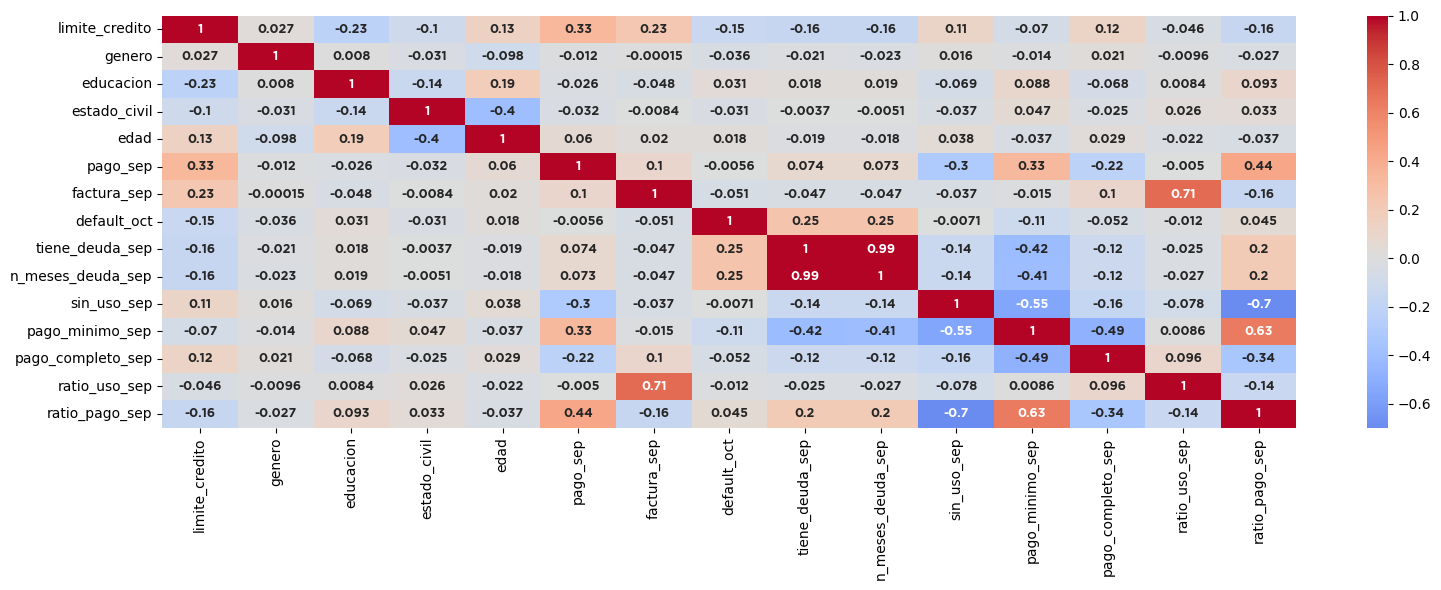

In [44]:
# Nueva matriz de correlación (incluye variables nuevas)
matriz_corr = df.corr()
plt.figure(figsize=(16,6))
sns.heatmap(
    matriz_corr, 
    annot=True, 
    cmap="coolwarm", 
    center=0,
    annot_kws={"fontproperties": gotham_bold, "size": 9}
)

# Aplicar fuentes a los ejes y título
gotham.set_size(10)
for label in ax.get_xticklabels():
    label.set_fontproperties(gotham)
    label.set_rotation(45)
    label.set_ha("right")

for label in ax.get_yticklabels():
    label.set_fontproperties(gotham)

gotham_bold.set_size(18)
ax.set_title("Matriz de correlación", fontproperties=gotham_bold, pad=20)

plt.tight_layout()
plt.show()

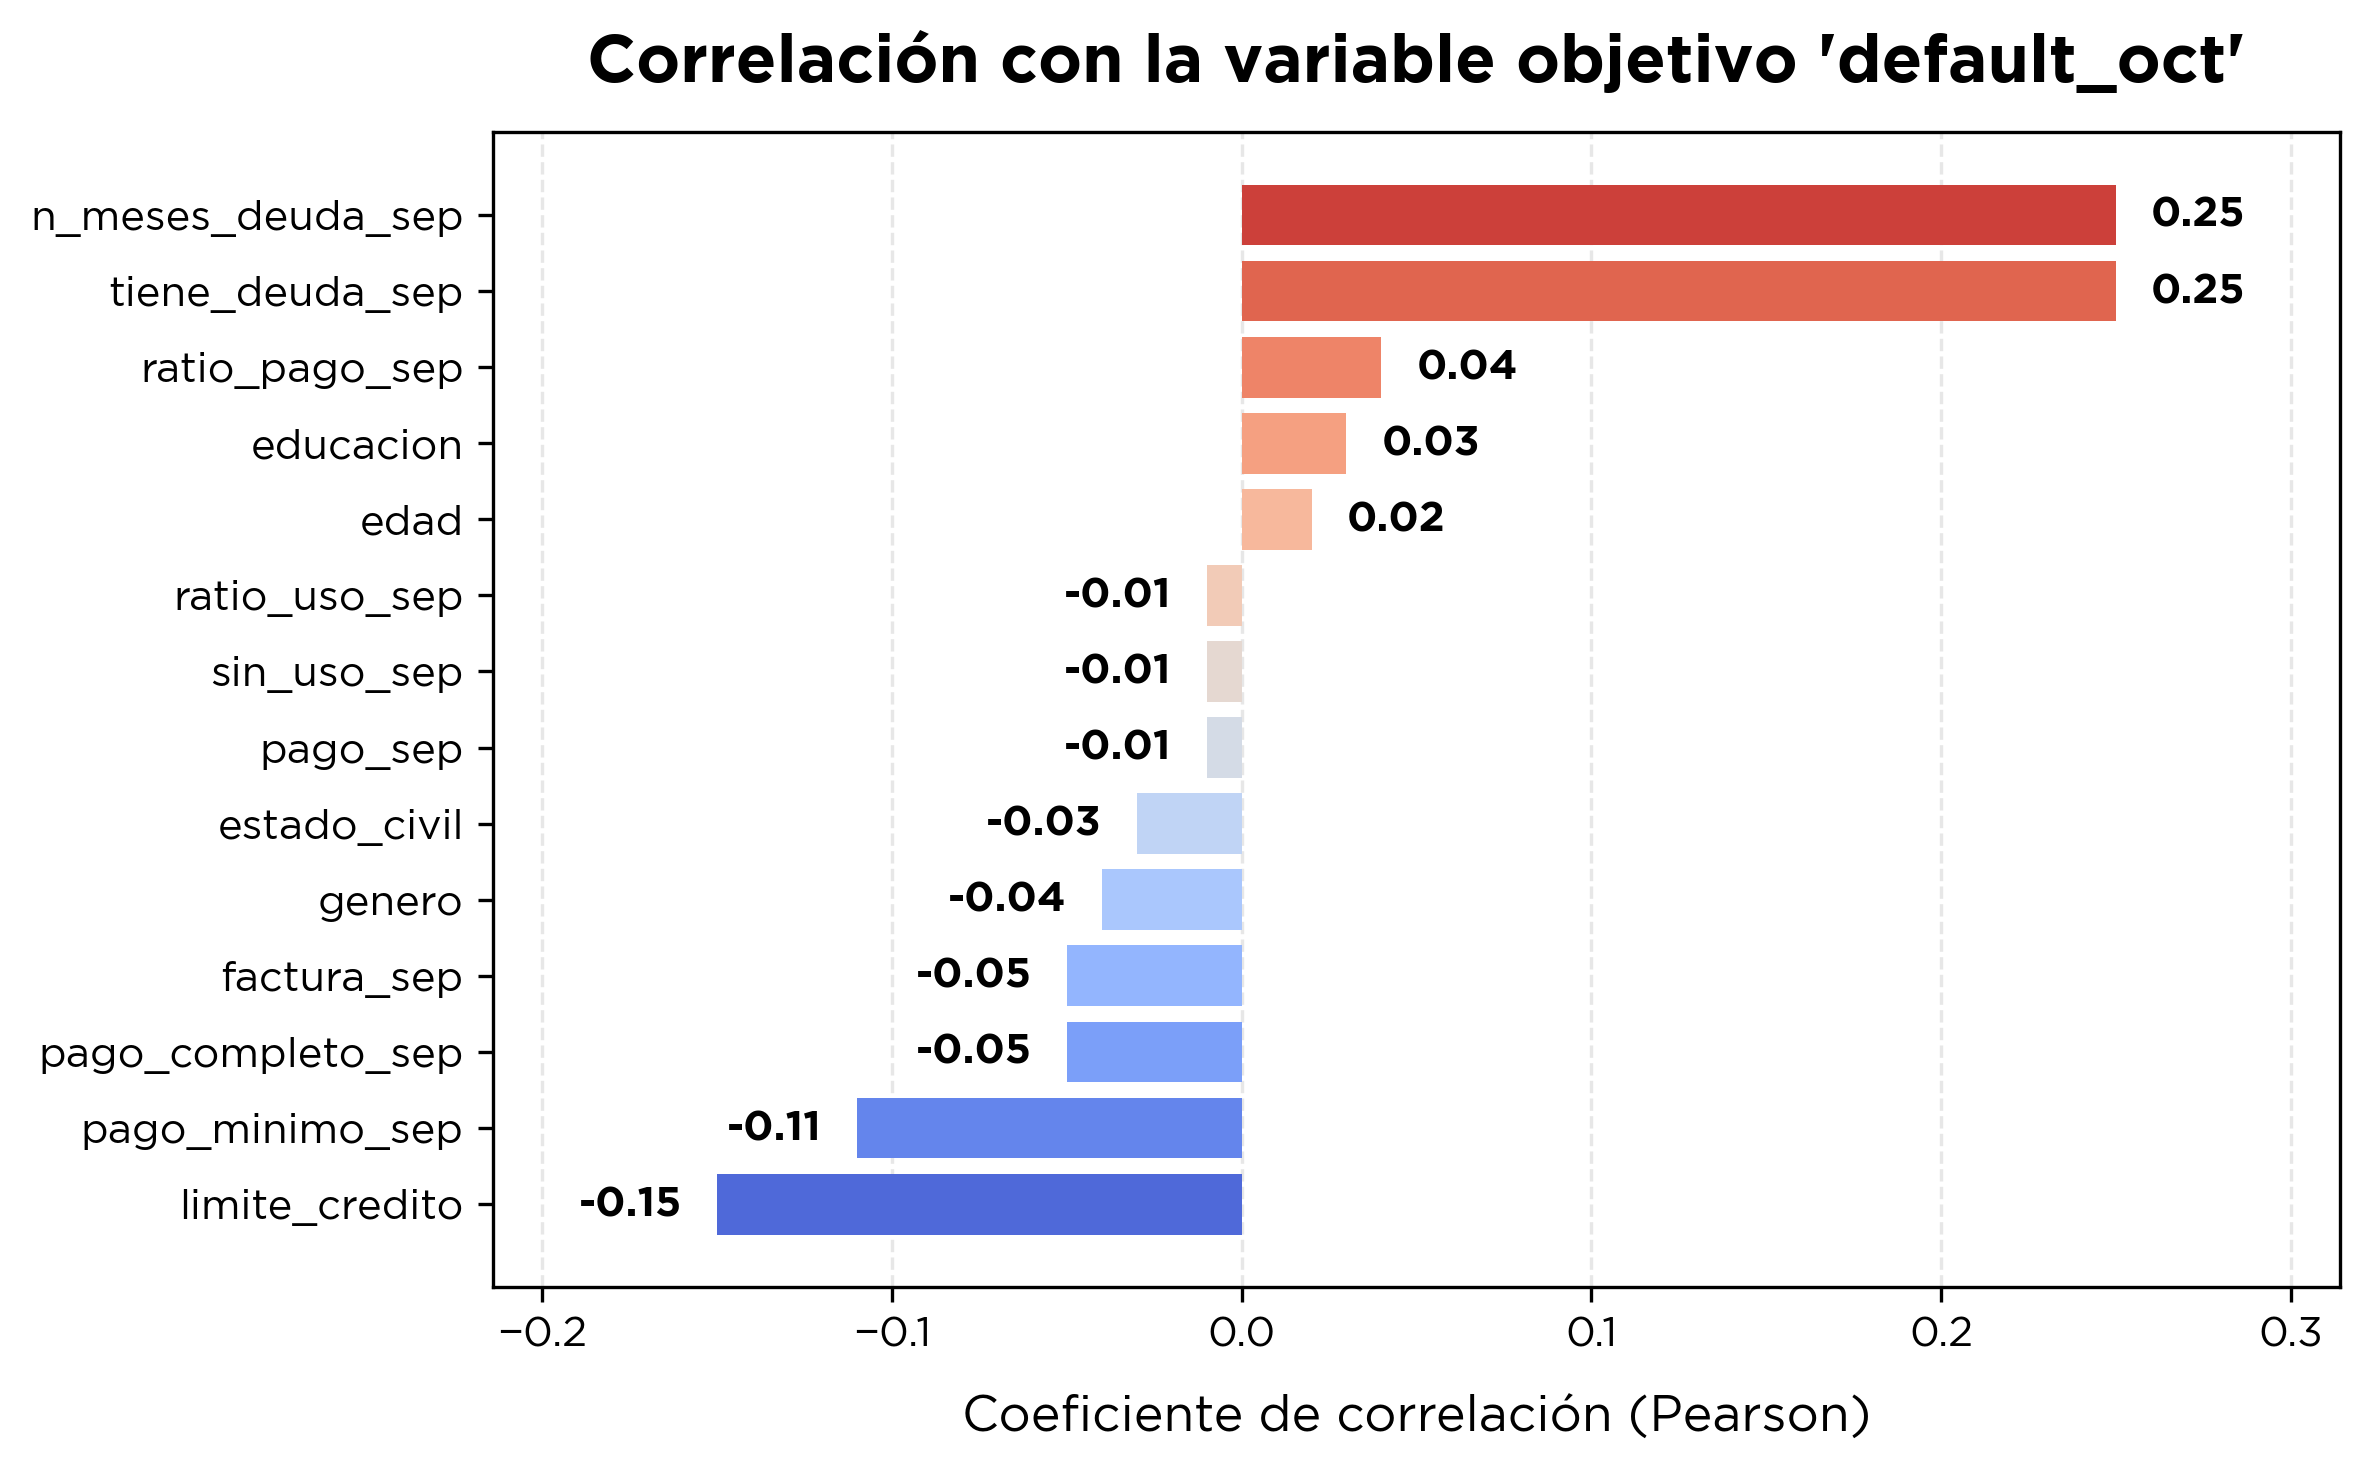

In [25]:
# Extraer correlaciones con la variable target
matriz_corr = df.corr()
corr_target = matriz_corr['default_oct'].drop('default_oct').round(2).sort_values()

# Gráfico de barras horizontal con paleta estándar de correlación
fig, ax = plt.subplots(figsize=(8,5), dpi=300)
bars = ax.barh(corr_target.index, corr_target.values, 
               color=sns.color_palette('coolwarm', n_colors=len(corr_target)))

# Título
gotham_bold.set_size(16)
ax.set_title("Correlación con la variable objetivo 'default_oct'", fontproperties=gotham_bold, pad=12)

# Labels
gotham.set_size(12)
ax.set_xlabel("Coeficiente de correlación (Pearson)", fontproperties=gotham,labelpad=10)
ax.set_ylabel("")  # Eliminar ylabel



# Aplicar Gotham a los ticks
gotham.set_size(10)
for label in ax.get_xticklabels():
    label.set_fontproperties(gotham)

for label in ax.get_yticklabels():
    label.set_fontproperties(gotham)

# Mostrar los valores al final de las barras
gotham_bold.set_size(10)
for i, (var, v) in enumerate(corr_target.items()):
    if v > 0:
        ax.text(v + 0.01, i, f'{v:.2f}', va='center', ha='left', 
                fontproperties=gotham_bold)
    else:
        ax.text(v - 0.01, i, f'{v:.2f}', va='center', ha='right', 
                fontproperties=gotham_bold)

# Ajustar límites del eje x para dar espacio a las anotaciones
x_min, x_max = ax.get_xlim()
padding = (x_max - x_min) * 0.1
ax.set_xlim(x_min - padding, x_max + padding)

# Grid
ax.set_axisbelow(True)
ax.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

Como **Modelo 1** utilizamos un árbol de decisión con `limite_credito` y `n_meses_deuda_sep` como variables predictoras, ya que tienen la mayor correlación con la variable *target* `default_oct` (-0.15 y +0.25 respectivamente). Por la naturaleza de nuestro modelo, no realizamos ningún preprocesamiento a nuestros datos en esta primera etapa. A la hora de definir el modelo especificamos un `max_depth=4` para limitar la posibilidad de *overfitting*, y `class_weight='balanced'` que ajusta los pesos de cada clase de forma inversamente proporcional a su frecuencia. Esto es necesario porque, como mencionamos anteriormente, la variable objetivo presenta un desbalance significativo con un 78% de las observaciones en la clase negativa (no default) y 22% en la clase positiva (default). Este ajuste penaliza más los errores en la clase minoritaria, favoreciendo nuestro objetivo de maximizar el ***recall***.

---
#### 5. Evaluar el primer modelo y abordar las siguientes actividades:
- **a.** Explicar claramente cómo se evaluará el modelo luego de su entrenamiento. Recordar las técnicas vistas en clase.
- **b.** Si se trata de un problema de **clasificación**, informar el resultado de las métricas elegidas y visualizar la frontera de decisión. Interpretar los resultados.
- **c.** Si se trata de un problema de **regresión**, informar el resultado de las métricas elegidas y visualizar las predicciones vs las observaciones, y la distribución de los residuos. Interpretar los resultados


Para entrenar nuestro modelo utilizamos una estrategia de ***train-test split*** con división 80/20, aplicando estratificación para mantener las proporciones de clases en ambos conjuntos, debido al desbalance original de nuestro *dataset*. 

Para evaluar el desempeño, como venimos remarcando, nuestra métrica prioritaria es el ***recall*** que mide la proporción de defaults reales que el modelo logra clasificar correctamente, dado que el costo de negocio de no detectar un deudor (falso negativo) supera el costo de investigar un cliente que finalmente cumple (falso positivo). También resultará relevante el ***AUC-ROC*** como medida de la capacidad de nuestro modelo para discriminar entre clases. La *precision* será mencionada para observar su variación dada por el *trade-off* *precision-recall*, pero no es la métrica de mayor interés para el problema que deseamos resolver.

### Modelo 1

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report, accuracy_score, roc_auc_score

X = df[['limite_credito', 'n_meses_deuda_sep']]
y = df['default_oct']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

tree_modelo1 = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced',  
    max_depth=4
)    

# Entrenar
tree_modelo1.fit(X_train, y_train)

# Predecir
y_pred = tree_modelo1.predict(X_test)
y_pred_proba = tree_modelo1.predict_proba(X_test)[:, 1]

# Metricas

print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred, pos_label=1):.3f}")
print(f"Precision: {precision_score(y_test, y_pred, pos_label=1, zero_division=0):.3f}")
print(f"F1-Score: {f1_score(y_test, y_pred, pos_label=1):.3f}")
print(f"ROC-AUC score: {roc_auc_score(y_test, y_pred_proba):.3f}")

Accuracy: 0.666
Recall: 0.523
Precision: 0.334
F1-Score: 0.408
ROC-AUC score: 0.656


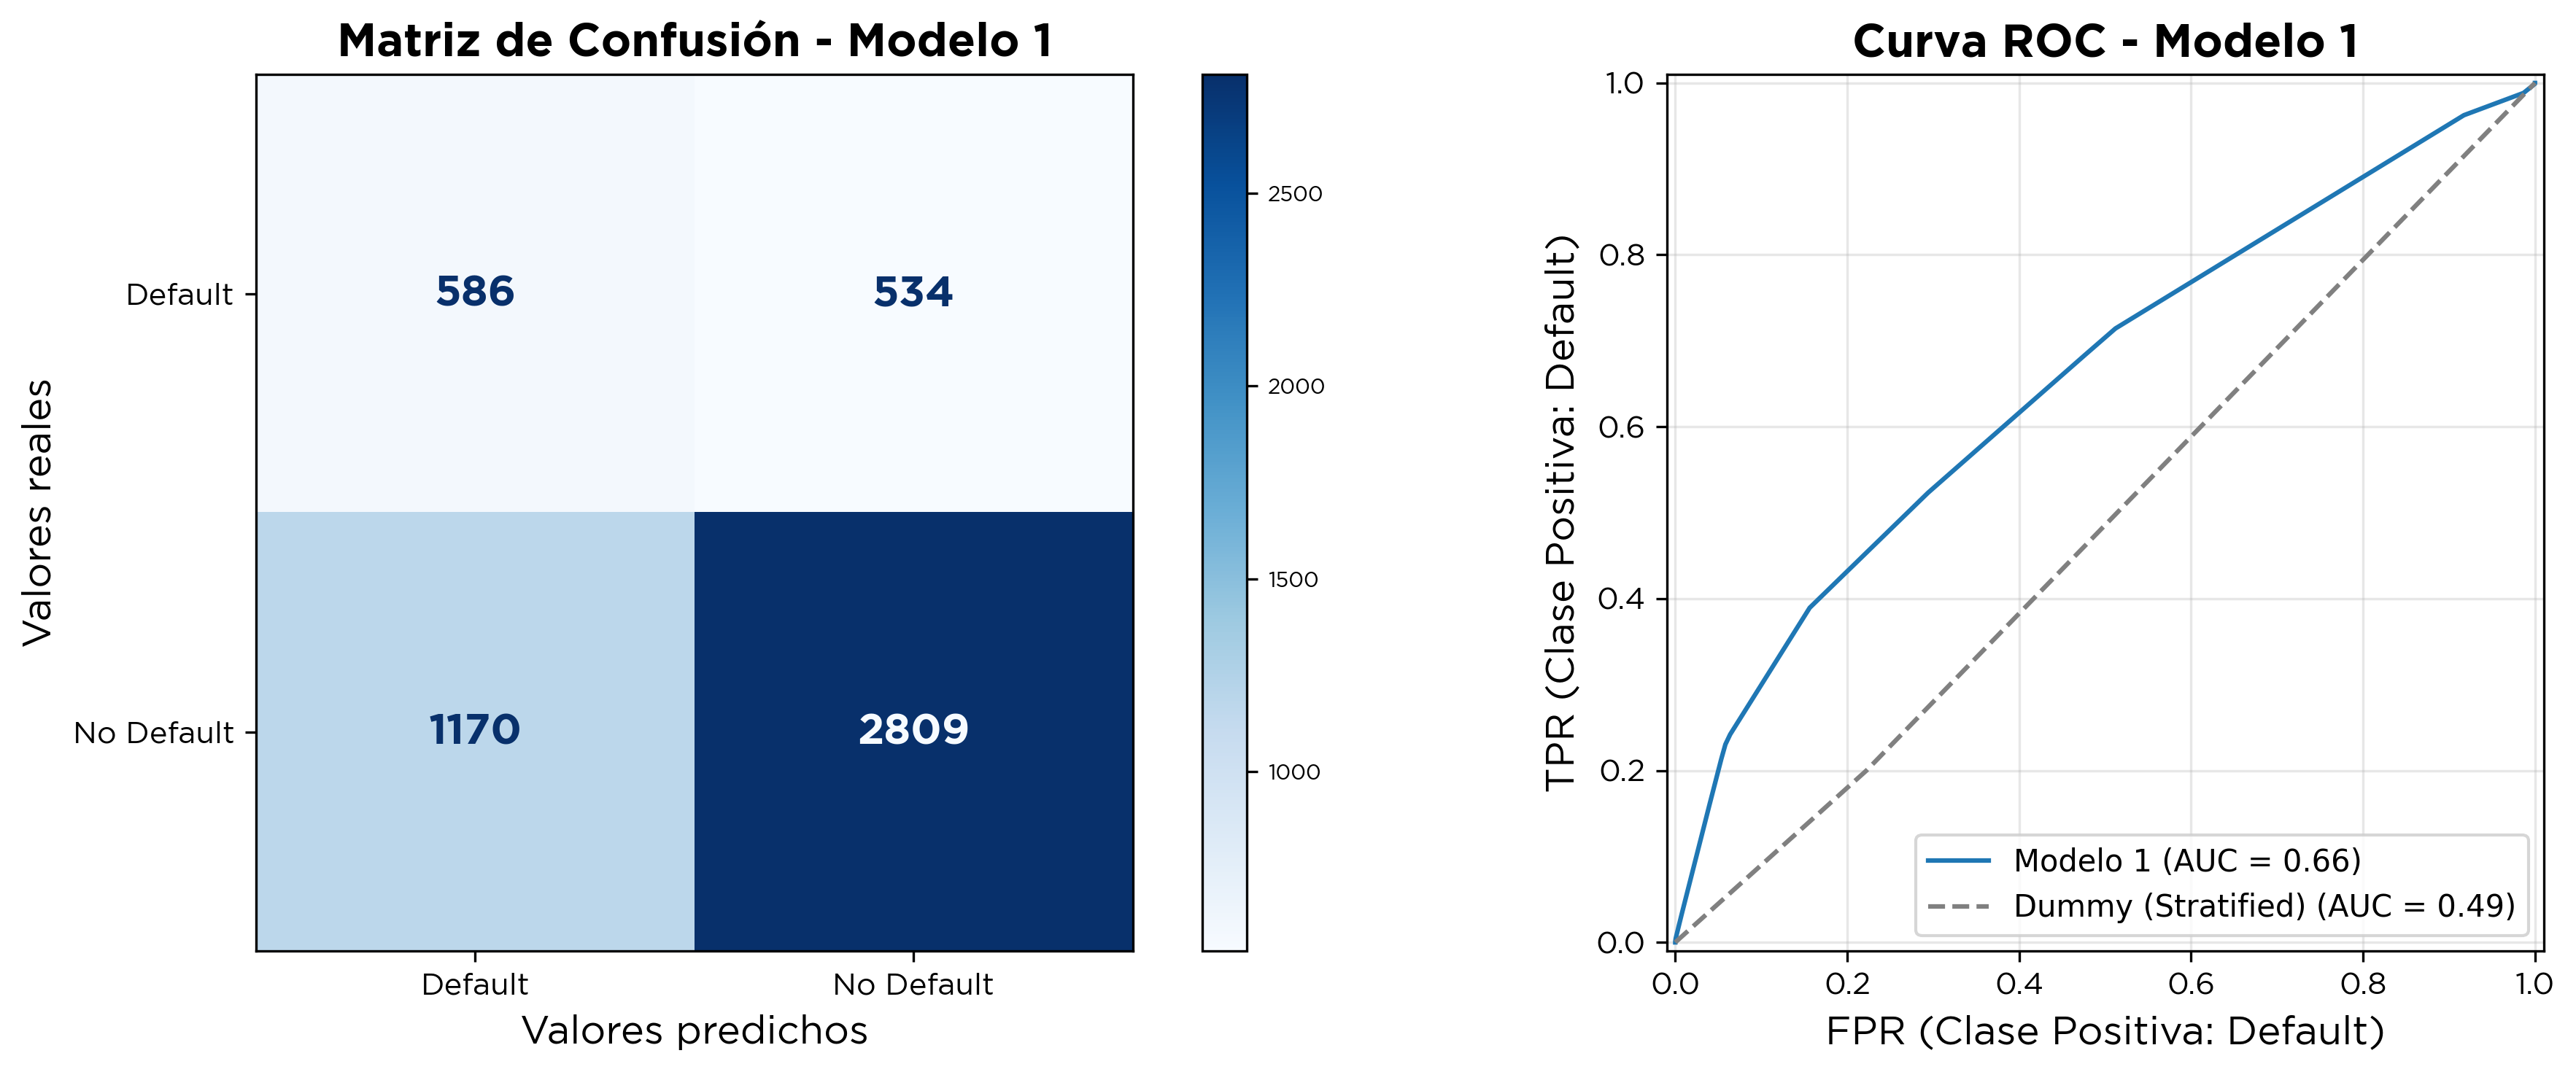

In [26]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import RocCurveDisplay, roc_curve

# Visualización
fig, axes = plt.subplots(1,2,figsize=(14,5), dpi = 300)

# Matriz de confusión
tree_1_cm = ConfusionMatrixDisplay.from_estimator(
    tree_modelo1, X_test, y_test,
    cmap=plt.cm.Blues,
    labels=[1,0],
    display_labels=['Default', 'No Default'],
    colorbar=True,
    ax=axes[0]
)
# Aumentar tamaño del texto dentro de la matriz
gotham_bold.set_size(14)
for text in tree_1_cm.text_.ravel():
    text.set_font_properties(gotham_bold)   # Cambiá el número según prefieras

gotham.set_size(13)
gotham_bold.set_size(15)
axes[0].set_xlabel("Valores predichos", fontproperties=gotham, labelpad=5)
axes[0].set_ylabel("Valores reales", fontproperties=gotham, labelpad=5)
axes[0].set_title('Matriz de Confusión - Modelo 1', fontproperties=gotham_bold, fontweight='bold')

# Gráfico Curva ROC
tree_1 = RocCurveDisplay.from_estimator(
    tree_modelo1, 
    X_test, 
    y_test,
    name="Modelo 1",
    ax=axes[1])
dummy_roc.plot(ax=axes[1], name="Dummy (Stratified)", ls="--", color="gray")
axes[1].set_xlabel('FPR (Clase Positiva: Default)', fontproperties=gotham, labelpad=5)
axes[1].set_ylabel('TPR (Clase Positiva: Default)', fontproperties=gotham, labelpad=5)
axes[1].set_title('Curva ROC - Modelo 1', fontproperties=gotham_bold)
axes[1].grid(alpha=0.3, axis='both')

gotham.set_size(10)
for ax in axes:
    for label in ax.get_xticklabels():
        label.set_fontproperties(gotham)
        
    for label in ax.get_yticklabels():
        label.set_fontproperties(gotham)

cbar = tree_1_cm.im_.colorbar
gotham.set_size(7)
for label in cbar.ax.get_yticklabels():
    label.set_fontproperties(gotham)

plt.tight_layout()
plt.show()

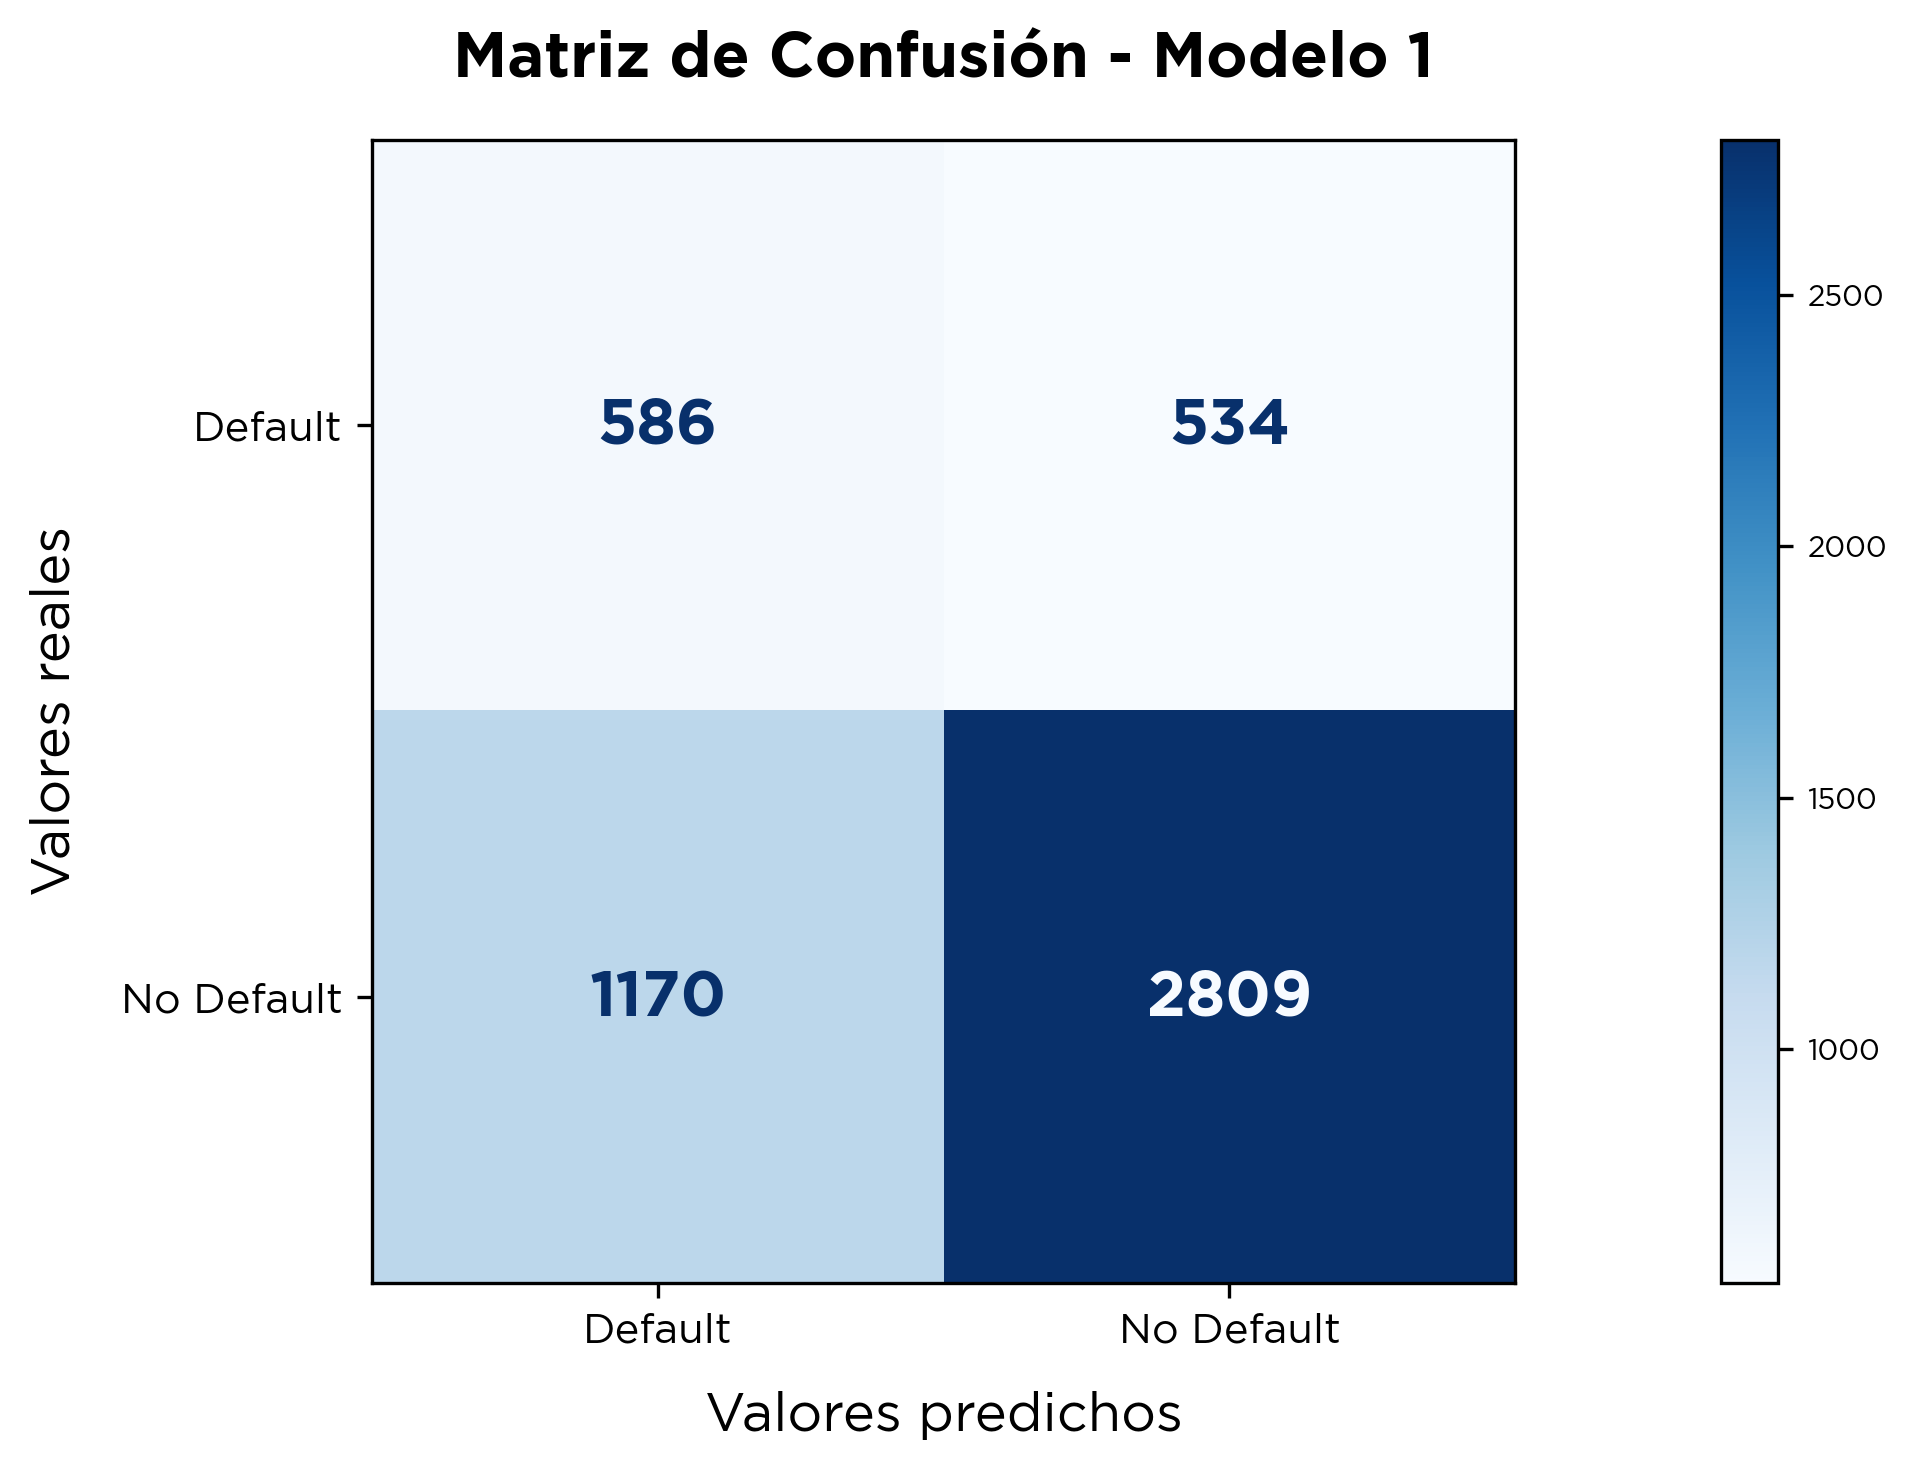

In [35]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


# Visualización
fig, axes = plt.subplots(1,1,figsize=(14,5), dpi=300)

# Matriz de confusión
tree_1_cm = ConfusionMatrixDisplay.from_estimator(
    tree_modelo1, X_test, y_test,
    cmap=plt.cm.Blues,
    labels=[1,0],
    display_labels=['Default', 'No Default'],
    colorbar=True,
    ax=axes)

# Aplicar Gotham a los números dentro de la matriz
gotham_bold.set_size(15)
for text in tree_1_cm.text_.ravel():
    text.set_fontproperties(gotham_bold)  # ← Agregar esto

# Labels de ejes
gotham.set_size(13)
axes.set_xlabel("Valores predichos", labelpad=10, fontproperties=gotham)
axes.set_ylabel("Valores reales", labelpad=10, fontproperties=gotham)

# Título con Gotham (solución al problema de tamaño)
axes.set_title('Matriz de Confusión - Modelo 1', fontweight='bold', fontproperties=gotham_bold, pad=15)

# Aplicar Gotham a los ticks (etiquetas de los ejes)
gotham.set_size(10)
for label in axes.get_xticklabels():
    label.set_fontproperties(gotham)

for label in axes.get_yticklabels():
    label.set_fontproperties(gotham)

cbar = tree_1_cm.im_.colorbar
gotham.set_size(7)
for label in cbar.ax.get_yticklabels():
    label.set_fontproperties(gotham)

plt.tight_layout()
plt.show()

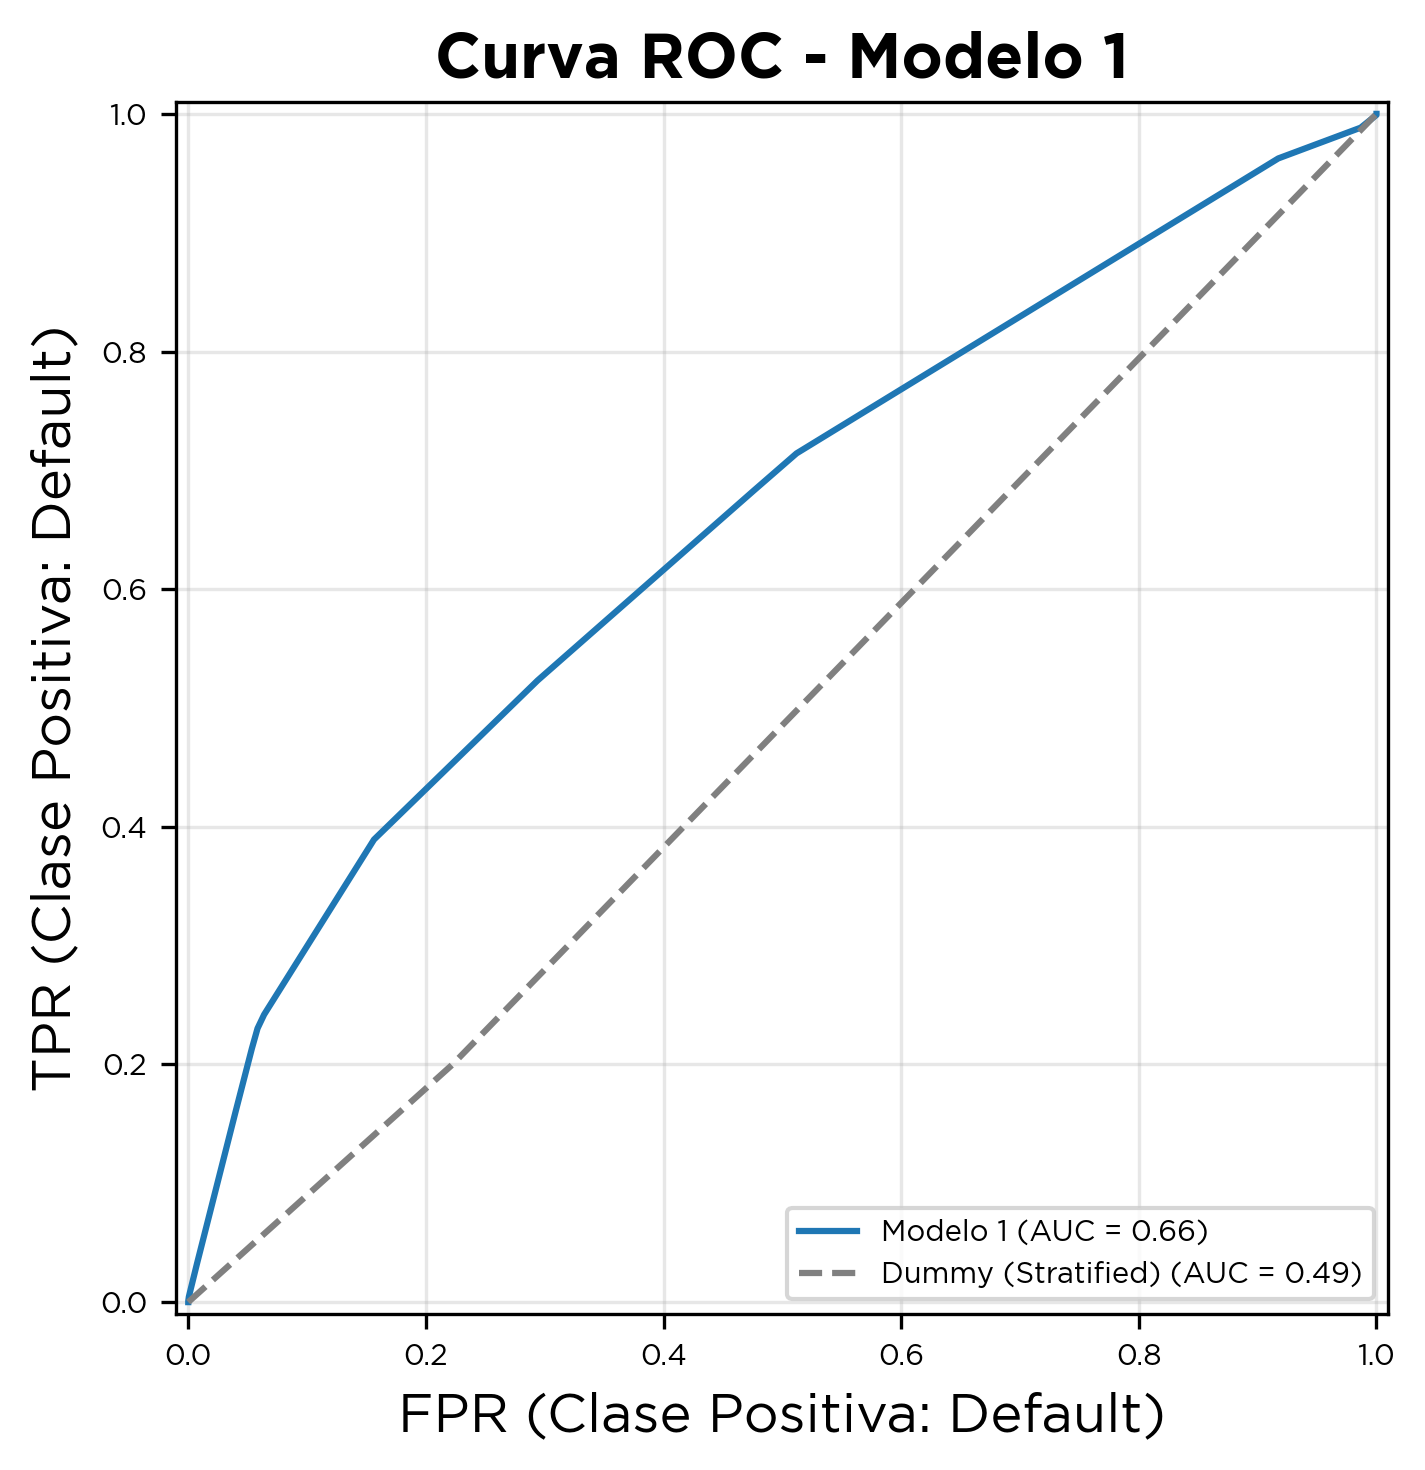

In [48]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import RocCurveDisplay, roc_curve



# Visualización
fig, axes = plt.subplots(1,1,figsize=(14,5), dpi = 300)

# Gráfico Curva ROC
tree_1 = RocCurveDisplay.from_estimator(
    tree_modelo1, 
    X_test, 
    y_test,
    name="Modelo 1",
    ax=axes)

gotham.set_size(13)
gotham_bold.set_size(15)
dummy_roc.plot(ax=axes, name="Dummy (Stratified)", ls="--", color="gray")
axes.set_xlabel('FPR (Clase Positiva: Default)', labelpad=5, fontproperties=gotham)
axes.set_ylabel('TPR (Clase Positiva: Default)', labelpad=5, fontproperties=gotham)
axes.set_title('Curva ROC - Modelo 1', fontproperties=gotham_bold)
axes.grid(alpha=0.3, axis='both')

gotham.set_size(7)
for label in axes.get_xticklabels() + axes.get_yticklabels():
    label.set_fontproperties(gotham)

plt.legend(prop=gotham, loc=4)

plt.tight_layout()
plt.show()

En la matriz de confusión puede observarse que este primer modelo identifica correctamente 586 de los 1120 casos de *default*, obteniendo un ***recall*** **de 52.3%**, mientras clasifica erróneamente 534 como "No Default". A su vez, identifica 1170 observaciones como falsos positivos.

En la curva ROC, el área bajo la curva (***AUC*** = **0.656**) indica una capacidad de discriminación moderada: el modelo logra distinguir correctamente entre un deudor y un no deudor en aproximadamente dos de cada tres pares comparados. La distancia de la curva respecto a la diagonal evidencia una mejora sustancial respecto al clasificador aleatorio.

La ***precision*** **del 33.4%** evidencia que el modelo clasifica como deudores a muchos clientes que no lo son, pero este sesgo es aceptable dado que el costo de no detectar a un deudor real es considerablemente mayor.

En conjunto, los resultados confirman que las variables `limite_credito` y `n_meses_deuda_sep` aportan información predictiva relevante para estimar el riesgo de *default*.  




### Frontera de Decisión Modelo 1

In [49]:
def visualize_classifier(model, X, y, ax=None, proba = False):
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values
    ax = ax or plt.gca()

    # Colores personalizados
    pallete = ['#4F69D9', '#CC403A']

    ax.scatter(
        X[y == 1, 0], 
        X[y == 1, 1],
        color=pallete[1],
        marker='o',
        s=60,
        alpha=0.6,
        edgecolors='black',
        linewidth=0.8,
        label='Default'
    )

    ax.scatter(
        X[y == 0, 0], 
        X[y == 0, 1],
        color=pallete[0],
        marker='o',  
        s=80,
        alpha=0.4,
        edgecolors='black',
        linewidth=0.8,
        label='No Default'
    )

    ax.axis('tight')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')

    ax.legend(
        loc='upper right',
        frameon=True,
        facecolor='white', 
        fontsize=12, 
        framealpha=1.0, 
        edgecolor='black'
    )

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))

    
    if proba:
        Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1].reshape(xx.shape)
    else:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)


    # Create a color plot with the results
    Z = -Z + 1
    ax.pcolormesh(xx,yy,Z,cmap='bwr_r', vmin = 0, vmax=1, alpha = 0.2)

    ax.set(xlim=xlim, ylim=ylim)

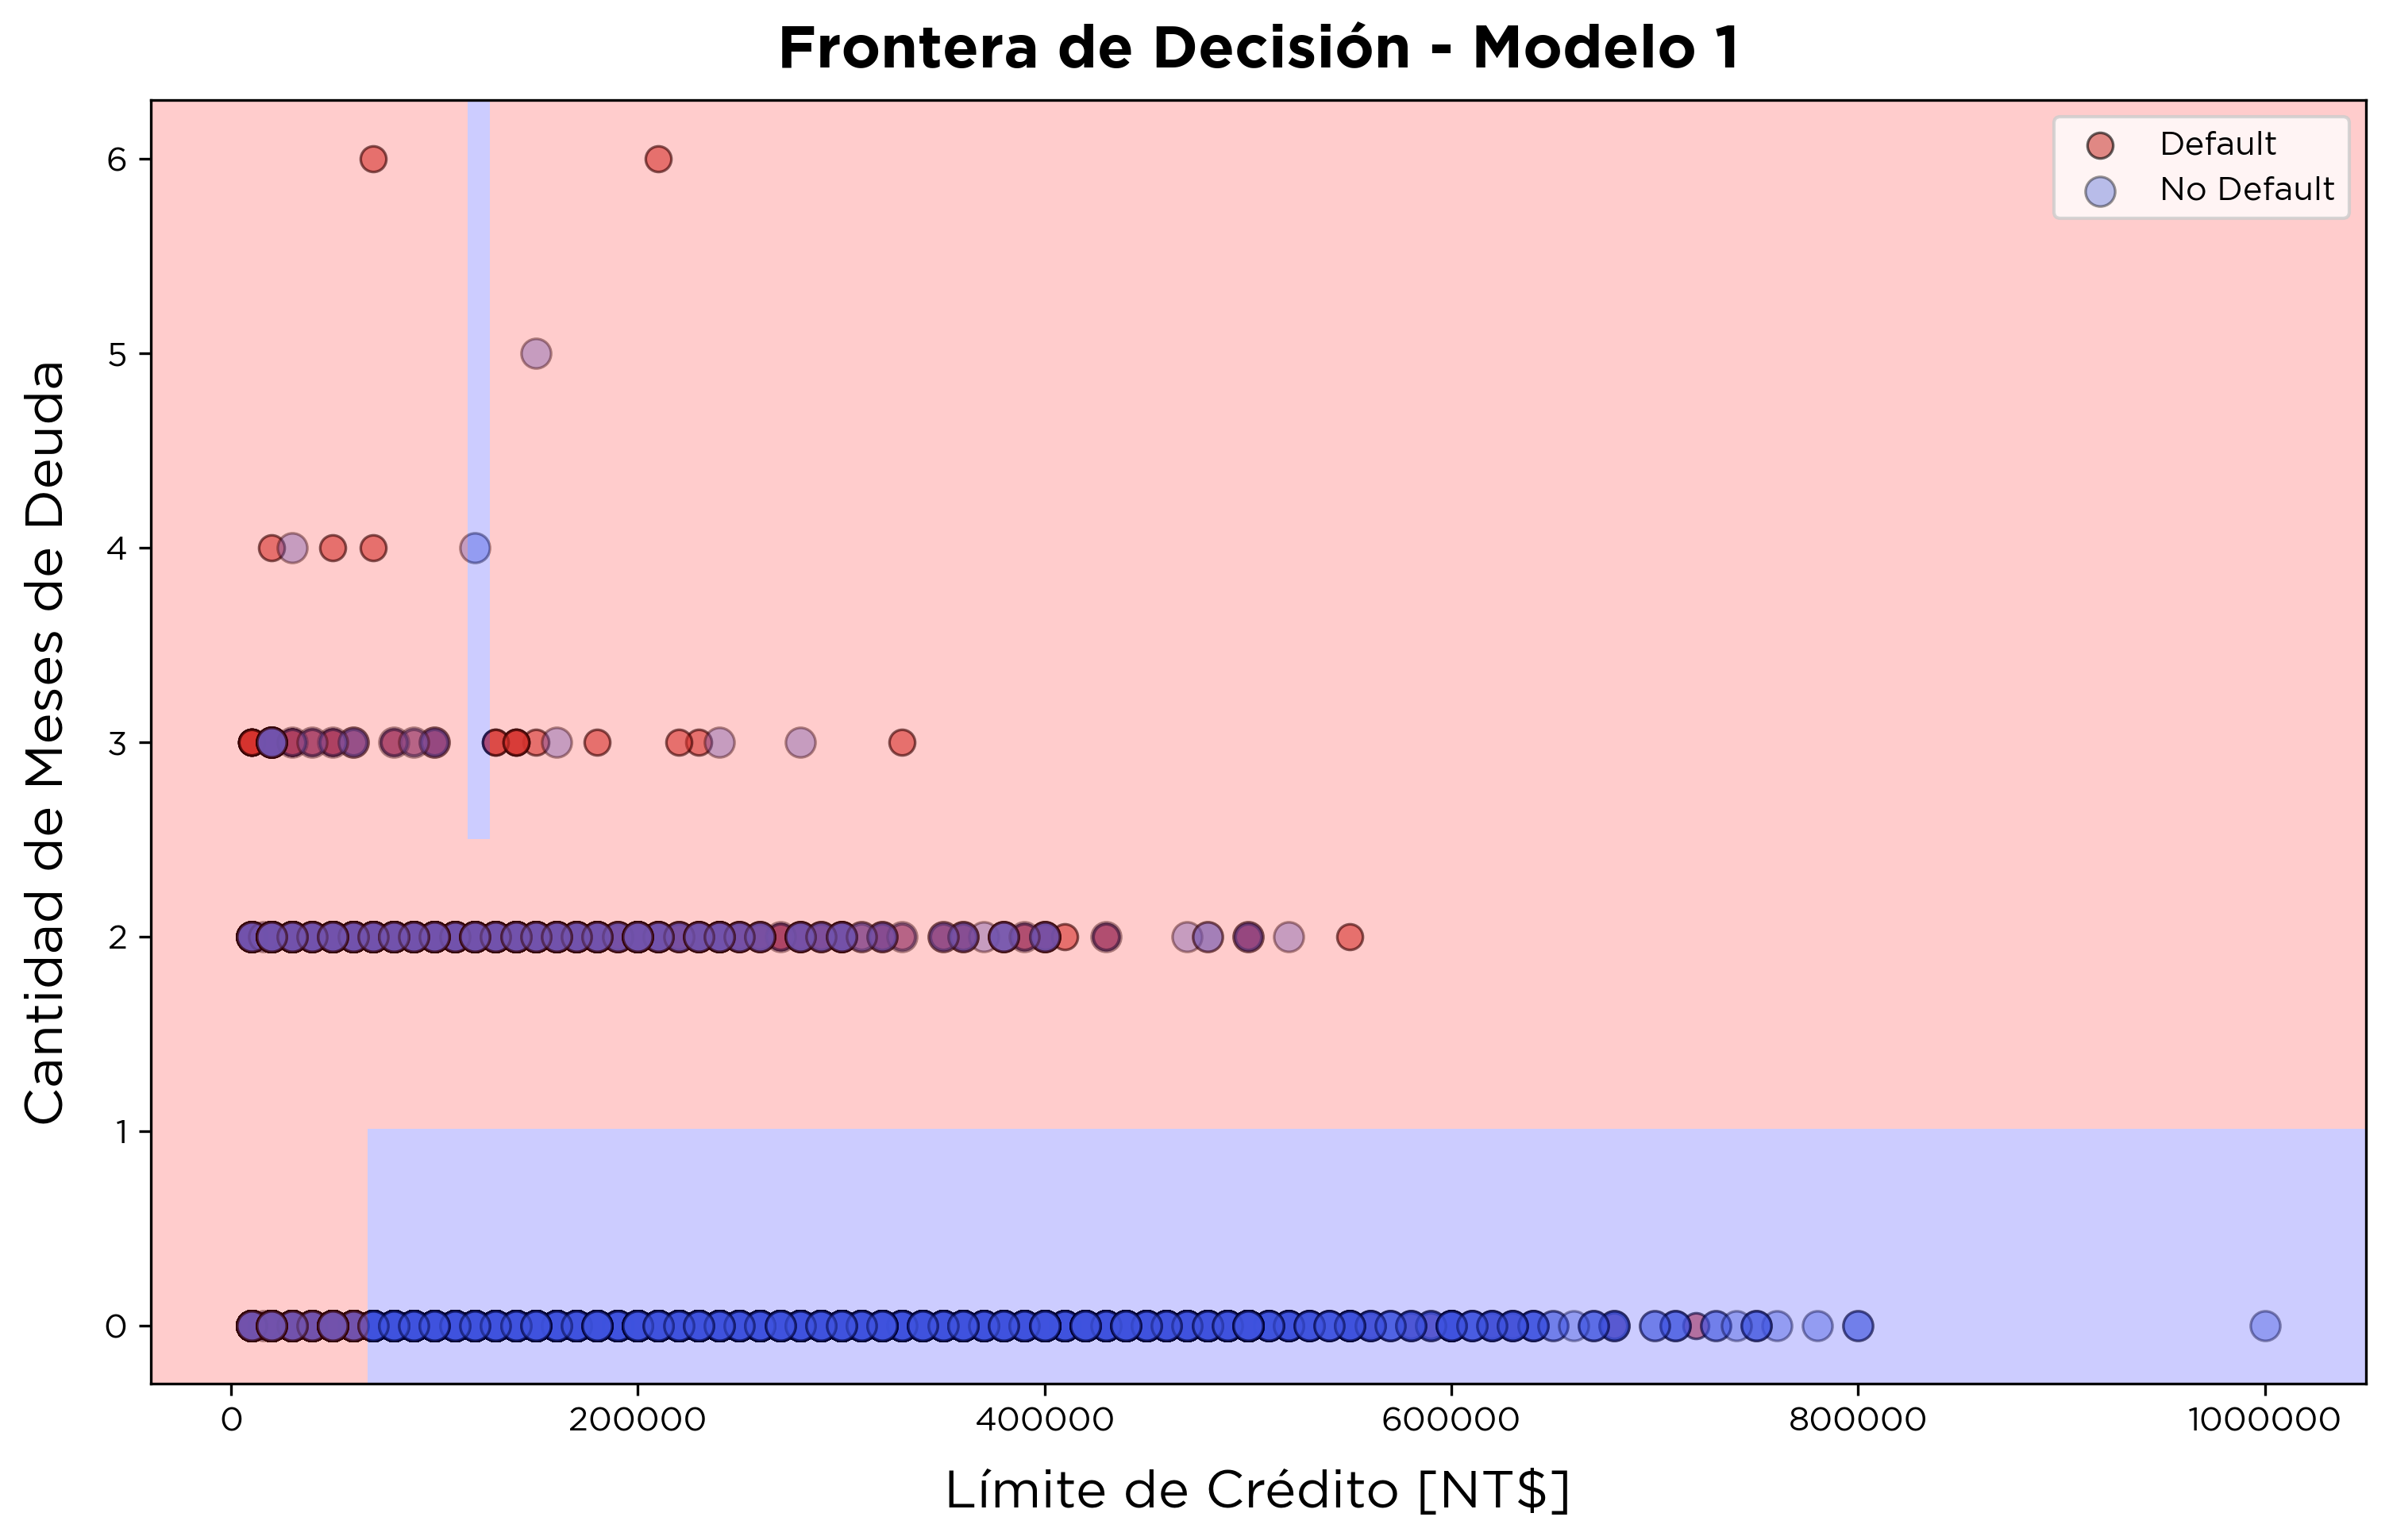

In [50]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="X does not have valid feature names")

prop_labels = fm.FontProperties(fname='Gotham-Book.otf', size=16)
prop_ticks = fm.FontProperties(fname='Gotham-Book.otf', size=10)
prop_title = fm.FontProperties(fname='GOTHAM-BOLD.TTF', size=18)


fig, axs=  plt.subplots(1,1, figsize = (12,7), dpi=300)
visualize_classifier(tree_modelo1, X_train, y_train, ax = axs)

gotham.set_size(16)
axs.set_xlabel('Límite de Crédito [NT$]', fontproperties=gotham, labelpad=10)
axs.set_ylabel('Cantidad de Meses de Deuda', fontproperties=gotham, labelpad=10)

gotham.set_size(10)
for label in axs.get_xticklabels() + axs.get_yticklabels():
    label.set_fontproperties(gotham)

axs.ticklabel_format(style='plain', axis='x')

plt.legend(prop=gotham)

gotham_bold.set_size(18)
axs.set_title('Frontera de Decisión - Modelo 1', fontproperties=prop_title, pad=10)
plt.show()

Al graficar la **frontera de decisión**, se observa que los individuos con un límite de crédito inferior a 100.000 NT\$ o con más de un mes de deuda acumulada son clasificados casi en su totalidad como potenciales deudores para el mes siguiente. Sin embargo, existe una proporción importante de observaciones (particularmente para los casos de dos meses de deuda) que el modelo no logra discriminar correctamente. Esto sugiere que podría ser necesario incorporar nuevas variables explicativas o ajustar los hiperparámetros del árbol para mejorar la separación entre clases. 

---
#### 6. Definir un segundo modelo de Machine Learning con todos los atributos que les parezcan adecuados. Recomendamos utilizar las técnicas de preprocesamiento que consideren adecuadas para su dataset, explicando el por qué de los pasos seleccionados.


Para nuestro **Modelo 2**, incorporamos tanto variables numéricas como categóricas al árbol de decisión anterior. A las variables numéricas iniciales `limite_credito` y `n_meses_deuda_sep` sumamos `edad`, `pago_sep`, `factura_sep`, `ratio_uso_sep` y `ratio_pago_sep`. Por otro lado, sumamos las siguientes variables categóricas: `genero`, `educacion` y `estado_civil`. El resto de variables no las tuvimos en cuenta porque tenían significados equivalentes a otras variables, por ejemplo `sin_uso_sep` que era equivalente a los valores con un `ratio_uso_sep == 0`. 

A las variables categóricas les realizamos un preprocesamiento aplicando una técnica de ***one-hot encoding***, ya que se trata de variables sin un orden natural entre sus categorías. Utilizamos un *pipeline* para automatizar esta transformación y luego utilizar esos datos transformados en un arbol de decisión al que indicamos `class_weight='balanced'` y `max_depth=4`, limitando nuevamente el riesgo de *overfitting* del modelo.

### Preprocesamiento para pipeline

---
#### 7. Evaluar el segundo modelo y abordar las siguientes actividades:
- a. Evaluar el modelo utilizando la misma metodología aplicada en el caso anterior.
- b. Evaluar el modelo utilizando validación cruzada. Informar e Interpretar los resultados obtenidos. Comparar con lo realizado en el punto anterior. Los resultados se pueden presentar en el formato que consideren más adecuado (texto, tabla, gráfico o combinación de varios).
- c. Si se utilizó un modelo basado en árboles de decisión, graficar y analizar la importancia de los atributos. En el caso de haber usado un regresor logístico o regresión lineal, imprimir y analizar todos los coeficientes. ¿Qué condiciones se tienen que cumplir para poder interpretar los coeficientes como importancia de atributos? Si utilizó otro modelo, investigar si se puede obtener una importancia para cada atributo.


### Modelo 2

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

num_features = ['limite_credito', 'edad', 'pago_sep', 'factura_sep',
    'n_meses_deuda_sep', 'ratio_uso_sep', 'ratio_pago_sep']

cat_features = ['genero', 'educacion', 'estado_civil']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

clf = DecisionTreeClassifier(
    class_weight='balanced', 
    random_state=42,
    max_depth = 4 
)

tree_modelo2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

X = df[num_features+cat_features]
y = df['default_oct']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

tree_modelo2.fit(X_train, y_train)
y_pred = tree_modelo2.predict(X_test)
y_proba = tree_modelo2.predict_proba(X_test)[:,1]

print(f"Accuracy train/test: {accuracy_score(y_train, tree_modelo2.predict(X_train)):.3f}/{accuracy_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred, pos_label=1):.3f}")
print(f"Precision: {precision_score(y_test, y_pred, pos_label=1, zero_division=0):.3f}")
print(f"F1-Score: {f1_score(y_test, y_pred, pos_label=1):.3f}")
print(f"ROC-AUC score: {roc_auc_score(y_test, y_proba):.3f}")

Accuracy train/test: 0.624/0.607
Recall: 0.607
Precision: 0.303
F1-Score: 0.404
ROC-AUC score: 0.658


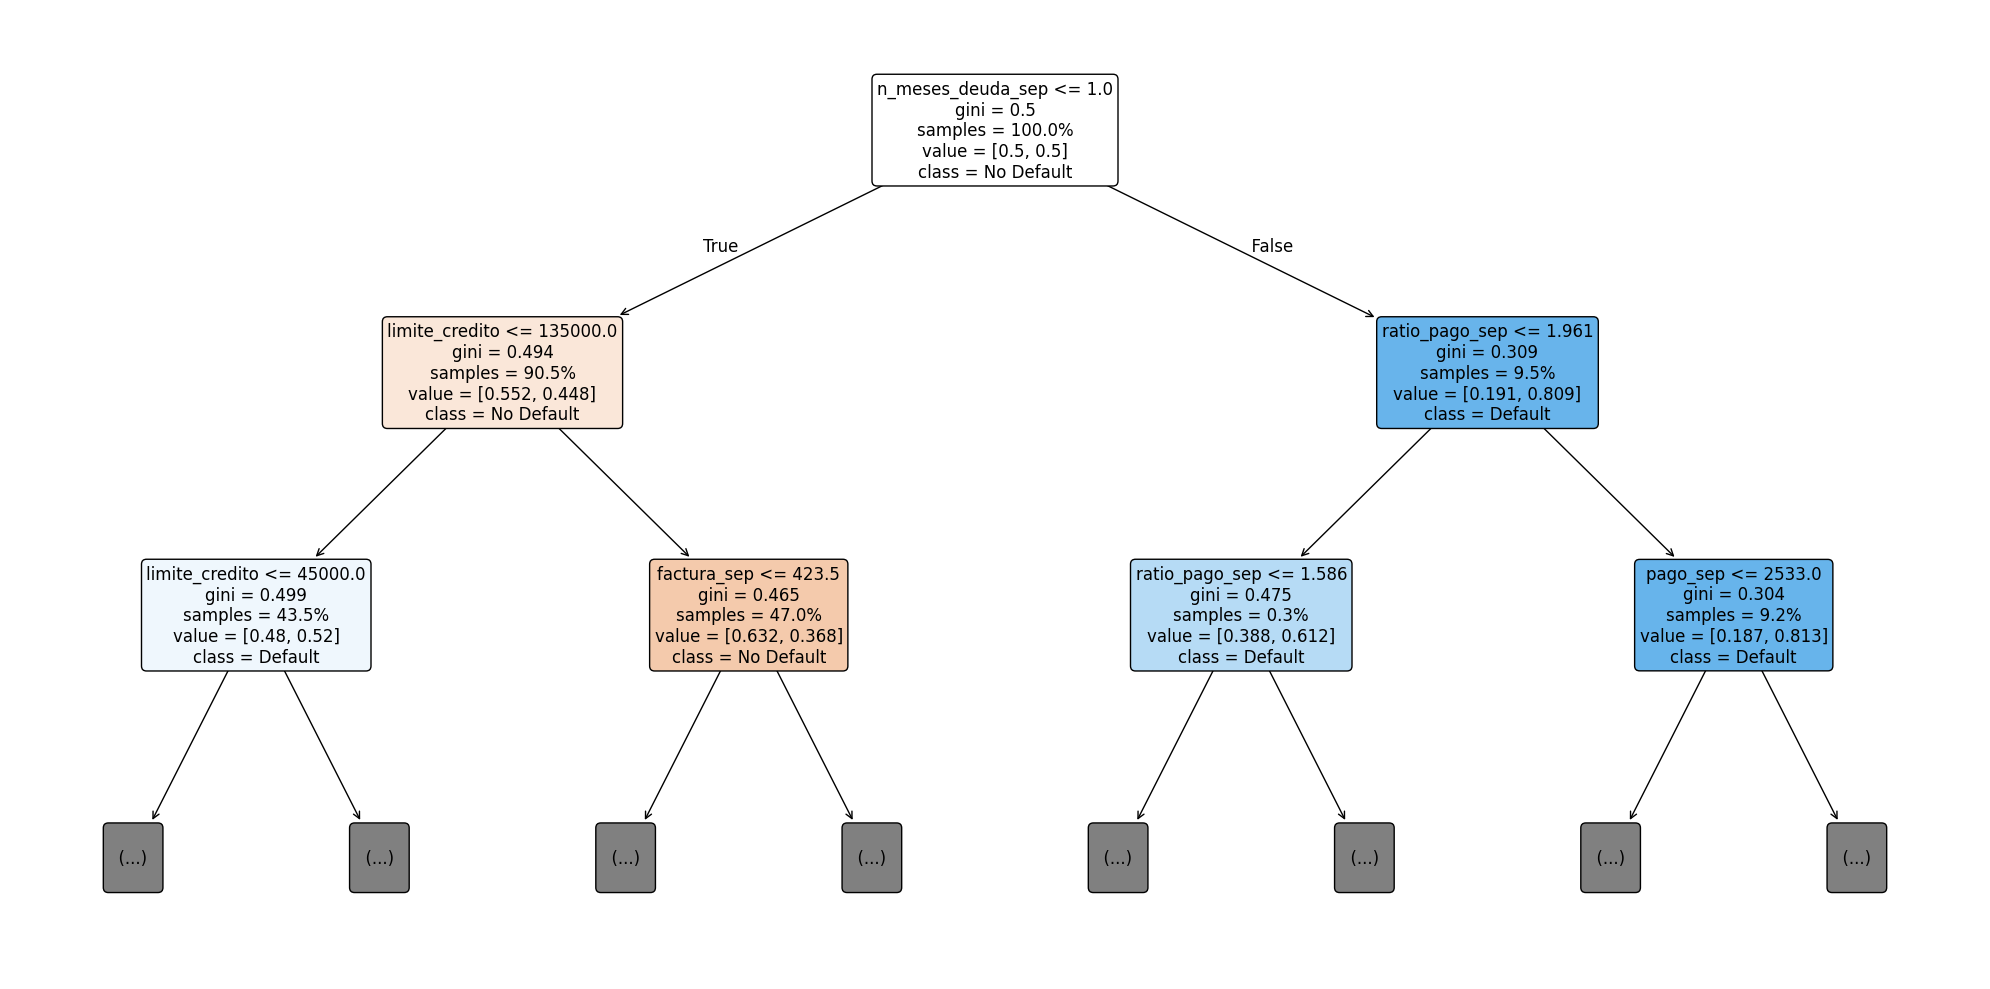

In [29]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

tree = tree_modelo2.named_steps["classifier"]

num_features_names = num_features  # ['limite_credito', 'n_meses_deuda_sep', ...]

# Categóricas (one-hot)
cat_features_names = tree_modelo2.named_steps['preprocessor']\
    .named_transformers_['cat']\
    .get_feature_names_out(cat_features).tolist()

# Todas juntas
all_feature_names = num_features_names + cat_features_names

fig, ax = plt.subplots(figsize=(20,10))
plot_tree(
    tree, 
    filled=True,              # Colorea los nodos según la clase predominante
    feature_names=all_feature_names,  # Nombres de las variables
    class_names=['No Default', 'Default'],  # Nombres de las clases
    rounded=True,              # Bordes redondeados (más legible)
    fontsize=12,
    proportion=True,
    max_depth=2
)

plt.tight_layout()
plt.show()

Para este segundo modelo utilizamos la misma estrategia de entrenamiento, y buscamos evaluar el desempeño nuevamente a partir del ***recall*** y el ***AUC-ROC***.

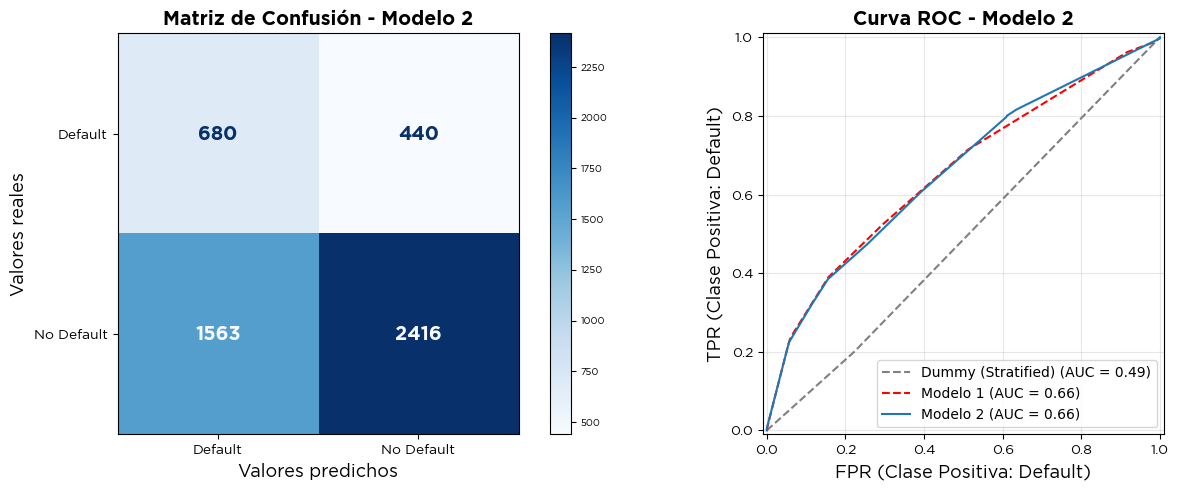

In [52]:
import matplotlib.pyplot as plt

# Visualización
fig, axes = plt.subplots(1,2,figsize=(14,5))

# Matriz de confusión
tree_2_cm = ConfusionMatrixDisplay.from_estimator(
    tree_modelo2, X_test, y_test,
    cmap=plt.cm.Blues,
    labels=[1,0],
    display_labels=['Default', 'No Default'],
    colorbar=True,
    ax=axes[0]
)
# Aumentar tamaño del texto dentro de la matriz
gotham_bold.set_size(14)
for text in tree_2_cm.text_.ravel():
    text.set_font_properties(gotham_bold)   # Cambiá el número según prefieras

gotham_bold.set_size(14)
gotham.set_size(13)
axes[0].set_xlabel("Valores predichos", fontproperties=gotham, labelpad=5)
axes[0].set_ylabel("Valores reales", fontproperties=gotham, labelpad=5)
axes[0].set_title('Matriz de Confusión - Modelo 2', fontproperties=gotham_bold)

# Gráfico Curva ROC
dummy_roc.plot(ax=axes[1], name="Dummy (Stratified)", ls="--", color="gray")
tree_1.plot(ax=axes[1], name="Modelo 1", ls="--", color="red")
tree_2 = RocCurveDisplay.from_estimator(
    tree_modelo2, 
    X_test, 
    y_test,
    name="Modelo 2",
    ax=axes[1])
axes[1].set_xlabel('FPR (Clase Positiva: Default)', fontproperties=gotham, labelpad=5)
axes[1].set_ylabel('TPR (Clase Positiva: Default)', fontproperties=gotham, labelpad=5)
axes[1].set_title('Curva ROC - Modelo 2', fontproperties=gotham_bold)
axes[1].grid(alpha=0.3, axis='both')

gotham.set_size(10)
for ax in axes:
    for label in ax.get_xticklabels():
        label.set_fontproperties(gotham)
        
    for label in ax.get_yticklabels():
        label.set_fontproperties(gotham)

cbar = tree_2_cm.im_.colorbar
gotham.set_size(7)
for label in cbar.ax.get_yticklabels():
    label.set_fontproperties(gotham)

plt.tight_layout()
plt.show()

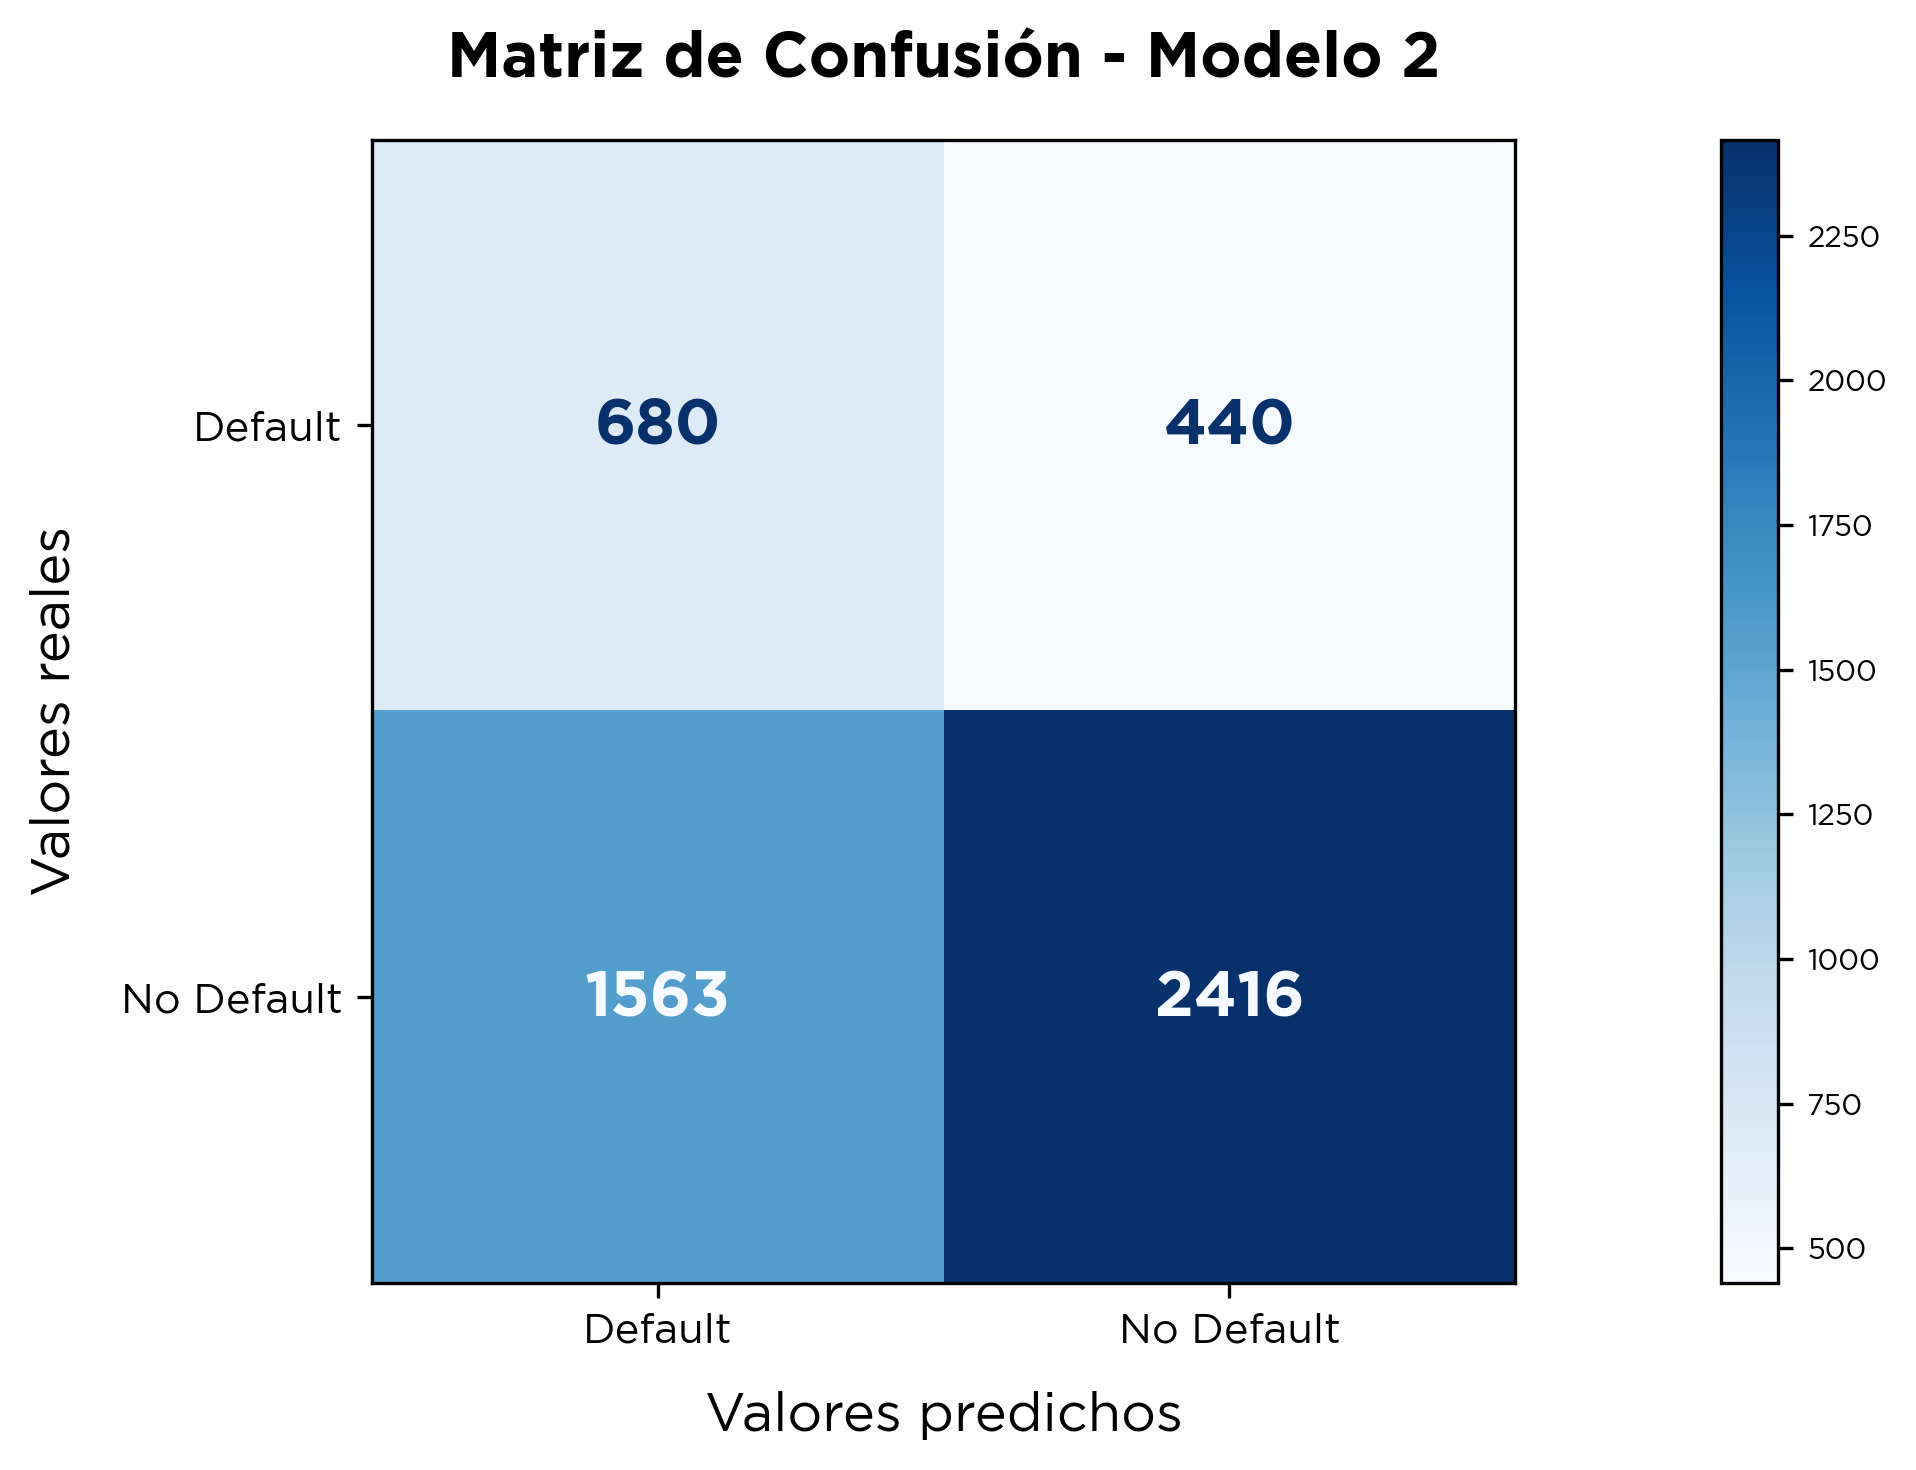

In [53]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


# Visualización
fig, axes = plt.subplots(1,1,figsize=(14,5), dpi=300)

# Matriz de confusión
tree_2_cm = ConfusionMatrixDisplay.from_estimator(
    tree_modelo2, X_test, y_test,
    cmap=plt.cm.Blues,
    labels=[1,0],
    display_labels=['Default', 'No Default'],
    colorbar=True,
    ax=axes)

# Aplicar Gotham a los números dentro de la matriz
gotham_bold.set_size(15)
for text in tree_2_cm.text_.ravel():
    text.set_fontproperties(gotham_bold)  # ← Agregar esto

# Labels de ejes
gotham.set_size(13)
axes.set_xlabel("Valores predichos", labelpad=10, fontproperties=gotham)
axes.set_ylabel("Valores reales", labelpad=10, fontproperties=gotham)

# Título con Gotham (solución al problema de tamaño)
axes.set_title('Matriz de Confusión - Modelo 2', fontweight='bold', fontproperties=gotham_bold, pad=15)

# Aplicar Gotham a los ticks (etiquetas de los ejes)
gotham.set_size(10)
for label in axes.get_xticklabels():
    label.set_fontproperties(gotham)

for label in axes.get_yticklabels():
    label.set_fontproperties(gotham)

cbar = tree_2_cm.im_.colorbar
gotham.set_size(7)
for label in cbar.ax.get_yticklabels():
    label.set_fontproperties(gotham)

plt.tight_layout()
plt.show()

En la matriz de ocnfusión se observa que el modelo identifica correctamente 680 de los 1120 casos de *default*, obteniendo un ***recall*** **del 60.7%**, mientras clasifica erróneamente 440 como "No Default". Además, identifica 1563 observaciones como falsos positivos, reflejando nuevamente el costo asumido al priorizar la detección de deudores sobre la precisión. El ***área bajo la curva ROC*** se ubica en **0.658**, indicando una capacidad de discriminación moderada aunque significativamente superior al clasificador aleatorio.

Como siguiente paso, llevamos a cabo una estrategia de ***cross-validation*** para mejorar la confianza en los resultados obtenidos. En este caso usamos el tipo `StratifiedKFold` con 5 *folds*. De esta manera mantenemos las proporciones de nuestras clases desbalanceadas y dividimos el *dataset* en cinco partes, entrenando cinco modelos distintos, usando cuatro partes para entrenamiento y una para prueba en cada iteración, obteniendo finalmente un promedio de las métricas deseadas.

In [54]:
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, train_test_split
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, roc_auc_score

print("="*70)
print("MODELO 2: VALIDACIÓN CRUZADA (5-FOLD)")
print("="*70)

# 1) CV estratificado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2) Recall por fold (opcional)
cv_recall = cross_val_score(
    tree_modelo2, X, y,
    cv=cv,
    scoring='recall',
    n_jobs=-1
)
print(f"\nRecall por fold: {cv_recall}")
print(f"Recall promedio: {cv_recall.mean():.3f} ± {cv_recall.std():.3f}")

# 3) Paquete de métricas para cross_validate
# Para AUC, usá directamente 'roc_auc' (binary). Si fuera multiclase: 'roc_auc_ovr' / 'roc_auc_ovo'.
scoring = {
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1',
    'accuracy': 'accuracy',
    'auc': 'roc_auc'
    # Alternativa equivalente:
    # 'auc': make_scorer(roc_auc_score, needs_proba=True)
}

cv_results = cross_validate(
    tree_modelo2, X, y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=True
)

# ==========================================
# 4. ANÁLISIS DE RESULTADOS CV
# ==========================================
print("\n" + "="*70)
print("RESULTADOS DE VALIDACIÓN CRUZADA")
print("="*70)

metricas_cv = {
    'Métrica': ['Recall', 'Precision', 'F1-Score', 'Accuracy', 'AUC-ROC'],
    'Train (promedio)': [
        cv_results['train_recall'].mean(),
        cv_results['train_precision'].mean(),
        cv_results['train_f1'].mean(),
        cv_results['train_accuracy'].mean(),
        cv_results['train_auc'].mean()
    ],
    'Test (promedio)': [
        cv_results['test_recall'].mean(),
        cv_results['test_precision'].mean(),
        cv_results['test_f1'].mean(),
        cv_results['test_accuracy'].mean(),
        cv_results['test_auc'].mean()
    ],
    'Test (std)': [
        cv_results['test_recall'].std(),
        cv_results['test_precision'].std(),
        cv_results['test_f1'].std(),
        cv_results['test_accuracy'].std(),
        cv_results['test_auc'].std()
    ]
}
df_cv = pd.DataFrame(metricas_cv)
print("\n" + df_cv.to_string(index=False))

# ==========================================
# 4.b ANÁLISIS DE OVERFITTING
# ==========================================
print("\n" + "="*70)
print("ANÁLISIS DE OVERFITTING")
print("="*70)
for metrica in ['recall', 'precision', 'f1', 'auc']:
    train_score = cv_results[f'train_{metrica}'].mean()
    test_score = cv_results[f'test_{metrica}'].mean()
    diff = train_score - test_score

    print(f"{metrica.upper():12} - Train: {train_score:.3f} | Test: {test_score:.3f} | Gap: {diff:.3f}")
    if diff > 0.10:
        print("  ⚠️  Posible overfitting (gap > 10%)")
    elif diff > 0.05:
        print("  ⚡ Gap moderado (5-10%)")
    else:
        print("  ✅ Gap aceptable (< 5%)")

# ==========================================
# 5. COMPARACIÓN: CV vs TRAIN-TEST SPLIT
# ==========================================
print("\n" + "="*70)
print("COMPARACIÓN: VALIDACIÓN CRUZADA vs TRAIN-TEST SPLIT")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

tree_modelo2.fit(X_train, y_train)
y_pred = tree_modelo2.predict(X_test)

# AUC requiere score continuo: preferimos predict_proba[:, 1]; si no existe, usamos decision_function
if hasattr(tree_modelo2, "predict_proba"):
    y_score = tree_modelo2.predict_proba(X_test)[:, 1]
else:
    y_score = tree_modelo2.decision_function(X_test)

# Métricas del split simple
recall_split = recall_score(y_test, y_pred)
precision_split = precision_score(y_test, y_pred)
f1_split = f1_score(y_test, y_pred)
auc_split = roc_auc_score(y_test, y_score)

comparacion = pd.DataFrame({
    'Método': ['Train-Test Split (80/20)', 'Validación Cruzada (5-fold)'],
    'Recall': [
        f"{recall_split:.3f}",
        f"{cv_results['test_recall'].mean():.3f} ± {cv_results['test_recall'].std():.3f}"
    ],
    'Precision': [
        f"{precision_split:.3f}",
        f"{cv_results['test_precision'].mean():.3f} ± {cv_results['test_precision'].std():.3f}"
    ],
    'F1-Score': [
        f"{f1_split:.3f}",
        f"{cv_results['test_f1'].mean():.3f} ± {cv_results['test_f1'].std():.3f}"
    ],
    'AUC-ROC': [
        f"{auc_split:.3f}",
        f"{cv_results['test_auc'].mean():.3f} ± {cv_results['test_auc'].std():.3f}"
    ]
})
print("\n" + comparacion.to_string(index=False))

MODELO 2: VALIDACIÓN CRUZADA (5-FOLD)

Recall por fold: [0.63068689 0.61517857 0.65625    0.60089286 0.60267857]
Recall promedio: 0.621 ± 0.021

RESULTADOS DE VALIDACIÓN CRUZADA

  Métrica  Train (promedio)  Test (promedio)  Test (std)
   Recall          0.631896         0.621137    0.020543
Precision          0.320045         0.315339    0.012146
 F1-Score          0.424344         0.417852    0.006960
 Accuracy          0.623500         0.619253    0.022771
  AUC-ROC          0.678796         0.670849    0.009622

ANÁLISIS DE OVERFITTING
RECALL       - Train: 0.632 | Test: 0.621 | Gap: 0.011
  ✅ Gap aceptable (< 5%)
PRECISION    - Train: 0.320 | Test: 0.315 | Gap: 0.005
  ✅ Gap aceptable (< 5%)
F1           - Train: 0.424 | Test: 0.418 | Gap: 0.006
  ✅ Gap aceptable (< 5%)
AUC          - Train: 0.679 | Test: 0.671 | Gap: 0.008
  ✅ Gap aceptable (< 5%)

COMPARACIÓN: VALIDACIÓN CRUZADA vs TRAIN-TEST SPLIT

                     Método        Recall     Precision      F1-Score       AUC-

A continuación se desarrolla la optimización de hiperparametros del Modelo 2 (modelo final para la presentación)

In [55]:
# ============================================
# Árbol de decisión: coarse grid + 1-SE + fine grid
# con métricas robustas (sin NaN en CV), gap train–CV y Top-10 ± std
# ============================================

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import (make_scorer, recall_score, precision_score, f1_score,
                             accuracy_score, roc_auc_score, average_precision_score,
                             classification_report, confusion_matrix)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.base import clone
import numpy as np
import pandas as pd

# =========================
# 0) Helpers
# =========================
def get_ohe_feature_names(preprocessor, num_features, cat_features):
    """Obtiene nombres de columnas después del ColumnTransformer para export_text."""
    ohe = preprocessor.named_transformers_['cat']
    cat_names = ohe.get_feature_names_out(cat_features)
    return np.r_[num_features, cat_names]

def simplicity_key(params):
    """
    Orden de simplicidad:
      - menor max_depth es más simple (None = 9999)
      - mayor min_samples_leaf es más simple
      - mayor min_samples_split es más simple
      - 'gini' más simple que 'entropy'
    """
    d = params.get('classifier__max_depth', None)
    depth_val = 9999 if d is None else d
    leaf = params.get('classifier__min_samples_leaf', 1)
    split = params.get('classifier__min_samples_split', 2)
    crit = params.get('classifier__criterion', 'gini')
    return (depth_val, -leaf, -split, 0 if crit == 'gini' else 1)

def neighbors(val, pool):
    """Dado un valor y un pool ordenado, devuelve vecindario [prev, val, next] si existen."""
    if val not in pool:
        return [val]
    i = pool.index(val)
    cand = {val}
    if i-1 >= 0: cand.add(pool[i-1])
    if i+1 < len(pool): cand.add(pool[i+1])
    return sorted(cand)

def show_cv_gap(cv_results, idx, metrics=('recall','precision','f1','accuracy')):
    """Imprime media±std en train y test CV y el gap train–CV para la fila idx."""
    print("\n== GAP train–CV en la mejor combinación (5-fold) ==")
    for m in metrics:
        mt = cv_results.loc[idx, f'mean_test_{m}']
        st = cv_results.loc[idx, f'std_test_{m}']
        mr = cv_results.loc[idx, f'mean_train_{m}']
        sr = cv_results.loc[idx, f'std_train_{m}']
        print(f"{m:9s}: train {mr:.4f}±{sr:.4f} | cv {mt:.4f}±{st:.4f} | gap {mr-mt:+.4f}")

def topn_table(cv_results, n=10, key='mean_test_recall'):
    """Devuelve Top-N por recall con columnas formateadas media ± std (sin AUC en CV)."""
    mets = ['recall','precision','f1','accuracy']
    cols = []
    for m in mets:
        cols += [f'mean_test_{m}', f'std_test_{m}']
    out = (cv_results[['params'] + cols]
           .sort_values(key, ascending=False)
           .head(n)
           .copy())
    for m in mets:
        out[m] = out.apply(lambda r: f"{r[f'mean_test_{m}']:.4f} ± {r[f'std_test_{m}']:.4f}", axis=1)
    keep = ['params'] + mets
    return out[keep]

# =========================
# 1) Pipeline base
# =========================
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

clf = DecisionTreeClassifier(
    class_weight='balanced',
    random_state=42
)

tree_modelo2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

# =========================
# 2) Train/test split
# =========================
X = df[num_features + cat_features]
y = df['default_oct']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =========================
# 3) Grid grueso (coarse)
# =========================
grid_depth = [1, 2, 3, 4, 5]
grid_leaf  = [1, 5, 10]
grid_split = [2, 10, 20]
grid_crit  = ['gini', 'entropy']
grid_mfeat = [None, 'sqrt', 'log2']
grid_ccp   = [0.0, 1e-4, 5e-4, 1e-3]

param_grid = {
    'classifier__max_depth': grid_depth,
    'classifier__min_samples_split': grid_split,
    'classifier__min_samples_leaf': grid_leaf,
    'classifier__criterion': grid_crit,
    'classifier__max_features': grid_mfeat,
    'classifier__ccp_alpha': grid_ccp
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Scoring para CV: solo métricas discretas (evita NaN cuando algún fold falla con AUC)
from sklearn.metrics import (make_scorer, recall_score, precision_score, f1_score, accuracy_score)
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0),
    'accuracy': make_scorer(accuracy_score),
}

grid_search = GridSearchCV(
    estimator=tree_modelo2,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    refit='recall',
    n_jobs=-1,
    verbose=1,
    return_train_score=True,
    error_score=np.nan   # float válido en todas las versiones
)

print(">>> Grid Search (coarse) ...")
grid_search.fit(X_train, y_train)

cv_results = pd.DataFrame(grid_search.cv_results_)
best_idx = grid_search.best_index_
best_params = grid_search.best_params_

print("\nMejores hiperparámetros (coarse, por recall):")
for k, v in best_params.items():
    print(f"  {k}: {v}")

# GAP train–CV del mejor (coarse)
show_cv_gap(cv_results, best_idx, metrics=('recall','precision','f1','accuracy'))

# =========================
# 4) Regla del 1-SE y selección del modelo más simple empatado
# =========================
mean_best = cv_results.loc[best_idx, 'mean_test_recall']
std_best  = cv_results.loc[best_idx, 'std_test_recall']
th_1se = mean_best - std_best

empatados = cv_results[cv_results['mean_test_recall'] >= th_1se].copy()
empatados['simplicity'] = empatados['params'].apply(simplicity_key)
row_simple = empatados.sort_values(['simplicity']).iloc[0]
simple_params = row_simple['params']

print(f"\nRegla 1-SE: umbral = {th_1se:.4f}")
print("Parámetros más simples dentro del 1-SE:")
for k, v in simple_params.items():
    print(f"  {k}: {v}")

# =========================
# 5) Grid fino (vecindario del modelo simple)
# =========================
md = simple_params['classifier__max_depth']
msl = simple_params['classifier__min_samples_leaf']
mss = simple_params['classifier__min_samples_split']
crit = simple_params['classifier__criterion']
mfeat = simple_params.get('classifier__max_features', None)
ccp = simple_params.get('classifier__ccp_alpha', 0.0)

fine_grid = {
    'classifier__max_depth': neighbors(md, grid_depth),
    'classifier__min_samples_leaf': neighbors(msl, grid_leaf),
    'classifier__min_samples_split': neighbors(mss, grid_split),
    'classifier__criterion': [crit],  # fijamos criterio si no hubo margen enorme
    'classifier__max_features': neighbors(mfeat, grid_mfeat) if mfeat in grid_mfeat else [mfeat],
    'classifier__ccp_alpha': neighbors(ccp, grid_ccp) if ccp in grid_ccp else [ccp]
}

fine_search = GridSearchCV(
    estimator=tree_modelo2,
    param_grid=fine_grid,
    cv=cv,
    scoring=scoring,
    refit='recall',
    n_jobs=-1,
    verbose=1,
    return_train_score=True,
    error_score=np.nan
)

print("\n>>> Grid Search (fine, vecindario 1-SE) ...")
fine_search.fit(X_train, y_train)

fine_results = pd.DataFrame(fine_search.cv_results_)
fine_best = fine_search.best_estimator_
fine_best_params = fine_search.best_params_
fine_best_idx = fine_search.best_index_

print("\nMejores hiperparámetros (fine, por recall):")
for k, v in fine_best_params.items():
    print(f"  {k}: {v}")

# GAP train–CV del mejor (fine)
show_cv_gap(fine_results, fine_best_idx, metrics=('recall','precision','f1','accuracy'))

# =========================
# 6) Evaluación en TEST (umbral por defecto 0.5) + AUC y AUC-PR SOLO en TEST
# =========================
y_pred = fine_best.predict(X_test)
y_proba = fine_best.predict_proba(X_test)[:, 1]

test_metrics = {
    'Recall': recall_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, zero_division=0),
    'F1-Score': f1_score(y_test, y_pred, zero_division=0),
    'Accuracy': accuracy_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_proba),
    'AUC-PR': average_precision_score(y_test, y_proba)
}
print("\nResultados en TEST (umbral = 0.5):")
for k, v in test_metrics.items():
    print(f"  {k:12s}: {v:.4f}")

print("\nReporte de clasificación (TEST):")
print(classification_report(y_test, y_pred, digits=4))
print("\nMatriz de confusión (TEST):")
print(confusion_matrix(y_test, y_pred))

# =========================
# 7) TOP-10 (coarse) con media ± std (sin AUC en CV)
# =========================
print("\nTOP-10 combinaciones (coarse) por recall, con desviación:")
print(topn_table(cv_results, n=10).to_string(index=False))

# =========================
# 8) Reglas del árbol (primeras capas) y comparación con árbol manual depth=4
# =========================
best_preproc = fine_best.named_steps['preprocessor']
feat_names = get_ohe_feature_names(best_preproc, num_features, cat_features)

print("\nReglas del árbol (mejor modelo, hasta profundidad 2):")
print(export_text(fine_best.named_steps['classifier'],
                  feature_names=list(feat_names), max_depth=2))

manual_model = Pipeline(steps=[
    ('preprocessor', clone(preprocessor)),
    ('classifier', DecisionTreeClassifier(
        class_weight='balanced',
        random_state=42,
        max_depth=4
    ))
])
manual_model.fit(X_train, y_train)
manual_preproc = manual_model.named_steps['preprocessor']
manual_feat_names = get_ohe_feature_names(manual_preproc, num_features, cat_features)

print("\nReglas del árbol MANUAL (depth=4), hasta profundidad 2:")
print(export_text(manual_model.named_steps['classifier'],
                  feature_names=list(manual_feat_names), max_depth=2))


>>> Grid Search (coarse) ...
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits

Mejores hiperparámetros (coarse, por recall):
  classifier__ccp_alpha: 0.0005
  classifier__criterion: gini
  classifier__max_depth: 5
  classifier__max_features: sqrt
  classifier__min_samples_leaf: 5
  classifier__min_samples_split: 2

== GAP train–CV en la mejor combinación (5-fold) ==
recall   : train 0.7850±0.0330 | cv 0.7706±0.0389 | gap +0.0144
precision: train 0.2862±0.0057 | cv 0.2812±0.0055 | gap +0.0050
f1       : train 0.4192±0.0034 | cv 0.4118±0.0094 | gap +0.0074
accuracy : train 0.5220±0.0214 | cv 0.5167±0.0146 | gap +0.0053

Regla 1-SE: umbral = 0.7316
Parámetros más simples dentro del 1-SE:
  classifier__ccp_alpha: 0.0005
  classifier__criterion: gini
  classifier__max_depth: 5
  classifier__max_features: log2
  classifier__min_samples_leaf: 10
  classifier__min_samples_split: 20

>>> Grid Search (fine, vecindario 1-SE) ...
Fitting 5 folds for each of 48 candidates, totalling

In [30]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

num_features = ['limite_credito', 'edad', 'pago_sep', 'factura_sep',
    'n_meses_deuda_sep', 'ratio_uso_sep', 'ratio_pago_sep']

cat_features = ['genero', 'educacion', 'estado_civil']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

clf = DecisionTreeClassifier(
    class_weight='balanced', 
    random_state=42,
    max_depth = 5,
    max_features='log2',
    min_samples_leaf=10,
    min_samples_split=20,
    ccp_alpha= 5e-4,
    criterion='gini'
)

tree_modelo3 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

X = df[num_features+cat_features]
y = df['default_oct']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

tree_modelo3.fit(X_train, y_train)
y_pred = tree_modelo3.predict(X_test)
y_proba = tree_modelo3.predict_proba(X_test)[:,1]

print(f"Accuracy train/test: {accuracy_score(y_train, tree_modelo3.predict(X_train)):.3f}/{accuracy_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred, pos_label=1):.3f}")
print(f"Precision: {precision_score(y_test, y_pred, pos_label=1, zero_division=0):.3f}")
print(f"F1-Score: {f1_score(y_test, y_pred, pos_label=1):.3f}")
print(f"F2-Score: {fbeta_score(y_test, y_pred, pos_label=1, beta=2):.3f}")
print(f"ROC-AUC score: {roc_auc_score(y_test, y_proba):.3f}")

Accuracy train/test: 0.510/0.499
Recall: 0.776
Precision: 0.274
F1-Score: 0.405
F2-Score: 0.568
ROC-AUC score: 0.648


In [35]:
# Obtener el árbol
tree2 = tree_modelo2.named_steps['classifier'].tree_

# Ver información básica
print(f"Total de nodos: {tree2.node_count}")
print(f"Features usadas en el árbol:")

num_features_names = num_features  # ['limite_credito', 'n_meses_deuda_sep', ...]

# Categóricas (one-hot)
cat_features_names = tree_modelo2.named_steps['preprocessor']\
    .named_transformers_['cat']\
    .get_feature_names_out(cat_features).tolist()

# Todas juntas
all_feature_names = num_features_names + cat_features_names
# Guardar las features que realmente se usan
features_usadas = set()
for i in range(tree2.node_count):
    feature_idx = tree2.feature[i]
    if feature_idx >= 0:  # -2 significa que es hoja
        features_usadas.add(feature_idx)
        feature_name = all_feature_names[feature_idx]
        print(f"  Índice {feature_idx}: {feature_name}")

print(f"\nTotal de features únicas usadas: {len(features_usadas)}")

# Ver si estado_civil está ahí
estado_civil_indices = [i for i, name in enumerate(all_feature_names) if 'estado_civil' in name]
print(f"\nÍndices de estado_civil: {estado_civil_indices}")
print(f"¿Alguna se usa en el árbol? {any(idx in features_usadas for idx in estado_civil_indices)}")

Total de nodos: 31
Features usadas en el árbol:
  Índice 4: n_meses_deuda_sep
  Índice 0: limite_credito
  Índice 0: limite_credito
  Índice 2: pago_sep
  Índice 0: limite_credito
  Índice 3: factura_sep
  Índice 2: pago_sep
  Índice 2: pago_sep
  Índice 6: ratio_pago_sep
  Índice 6: ratio_pago_sep
  Índice 5: ratio_uso_sep
  Índice 2: pago_sep
  Índice 2: pago_sep
  Índice 5: ratio_uso_sep
  Índice 2: pago_sep

Total de features únicas usadas: 6

Índices de estado_civil: [13, 14, 15]
¿Alguna se usa en el árbol? False


In [36]:
print(all_feature_names)

['limite_credito', 'edad', 'pago_sep', 'factura_sep', 'n_meses_deuda_sep', 'ratio_uso_sep', 'ratio_pago_sep', 'genero_1', 'genero_2', 'educacion_1', 'educacion_2', 'educacion_3', 'educacion_4', 'estado_civil_1', 'estado_civil_2', 'estado_civil_3']


In [32]:
# Obtener el árbol
tree = tree_modelo3.named_steps['classifier'].tree_

# Ver información básica
print(f"Total de nodos: {tree.node_count}")
print(f"Features usadas en el árbol:")

num_features_names = num_features  # ['limite_credito', 'n_meses_deuda_sep', ...]

# Categóricas (one-hot)
cat_features_names = tree_modelo3.named_steps['preprocessor']\
    .named_transformers_['cat']\
    .get_feature_names_out(cat_features).tolist()

# Todas juntas
all_feature_names = num_features_names + cat_features_names
# Guardar las features que realmente se usan
features_usadas = set()
for i in range(tree.node_count):
    feature_idx = tree.feature[i]
    if feature_idx >= 0:  # -2 significa que es hoja
        features_usadas.add(feature_idx)
        feature_name = all_feature_names[feature_idx]
        print(f"  Índice {feature_idx}: {feature_name}")

print(f"\nTotal de features únicas usadas: {len(features_usadas)}")

# Ver si estado_civil está ahí
estado_civil_indices = [i for i, name in enumerate(all_feature_names) if 'estado_civil' in name]
print(f"\nÍndices de estado_civil: {estado_civil_indices}")
print(f"¿Alguna se usa en el árbol? {any(idx in features_usadas for idx in estado_civil_indices)}")

Total de nodos: 27
Features usadas en el árbol:
  Índice 0: limite_credito
  Índice 2: pago_sep
  Índice 9: educacion_1
  Índice 3: factura_sep
  Índice 4: n_meses_deuda_sep
  Índice 3: factura_sep
  Índice 0: limite_credito
  Índice 4: n_meses_deuda_sep
  Índice 2: pago_sep
  Índice 3: factura_sep
  Índice 1: edad
  Índice 5: ratio_uso_sep
  Índice 2: pago_sep

Total de features únicas usadas: 7

Índices de estado_civil: [13, 14, 15]
¿Alguna se usa en el árbol? False


DecisionTreeClassifier(ccp_alpha=0.0005, class_weight='balanced', max_depth=5,
                       max_features='log2', min_samples_leaf=10,
                       min_samples_split=20, random_state=42)


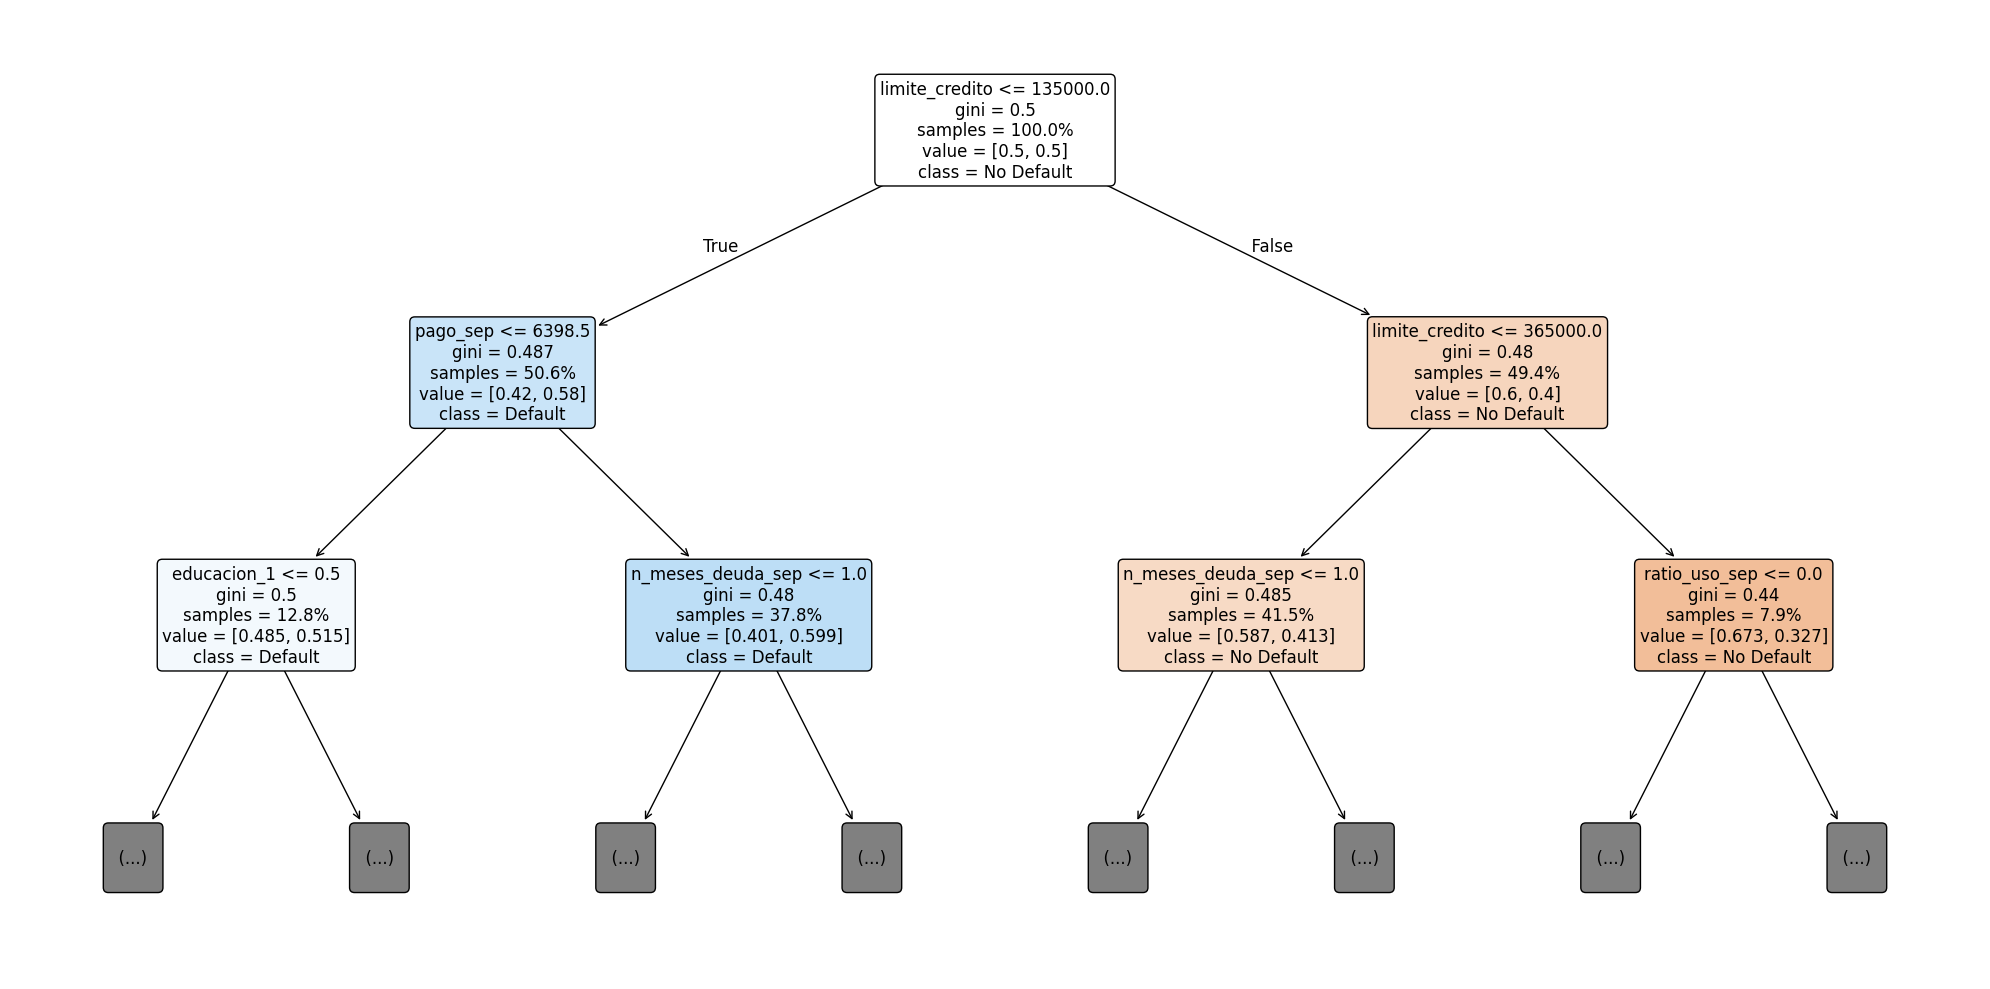

In [31]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
# Ver la configuración del árbol
print(tree_modelo3.named_steps['classifier'])

# Ver en qué nodos se usa estado_civil y cuántas muestras tienen

tree = tree_modelo3.named_steps["classifier"]

fig, ax = plt.subplots(figsize=(20,10))
plot_tree(
    tree, 
    filled=True,              # Colorea los nodos según la clase predominante
    feature_names=all_feature_names,  # Nombres de las variables
    class_names=['No Default', 'Default'],  # Nombres de las clases
    rounded=True,              # Bordes redondeados (más legible)
    fontsize=12,
    proportion=True,
    max_depth=2
)

plt.tight_layout()
plt.show()

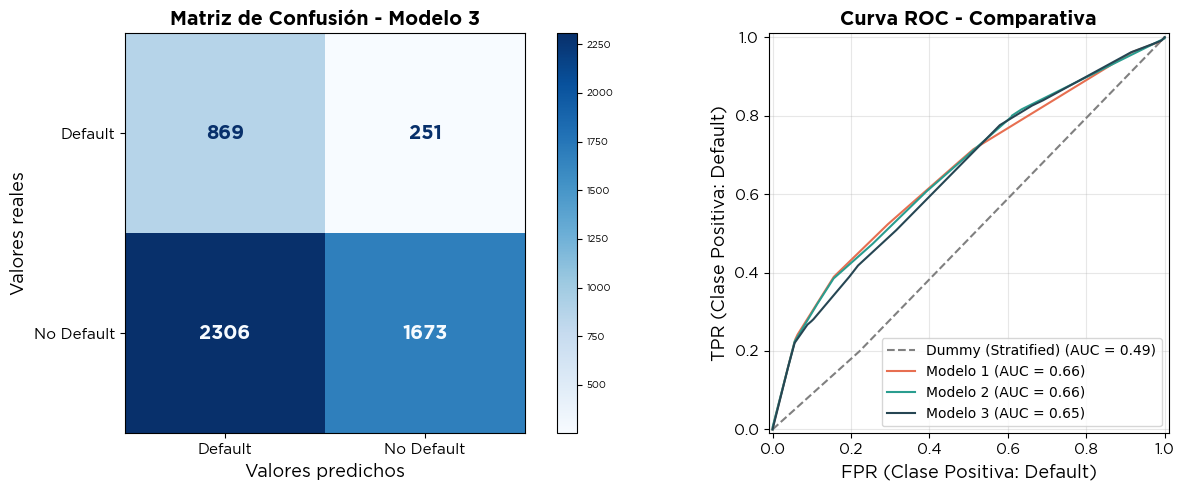

In [59]:
import matplotlib.pyplot as plt

# Visualización
fig, axes = plt.subplots(1,2,figsize=(14,5))

# Matriz de confusión
tree_3_cm = ConfusionMatrixDisplay.from_estimator(
    tree_modelo3, X_test, y_test,
    cmap=plt.cm.Blues,
    labels=[1,0],
    display_labels=['Default', 'No Default'],
    colorbar=True,
    ax=axes[0]
)
# Aumentar tamaño del texto dentro de la matriz
gotham_bold.set_size(14)
for text in tree_3_cm.text_.ravel():
    text.set_font_properties(gotham_bold)   # Cambiá el número según prefieras

gotham.set_size(13)
axes[0].set_xlabel("Valores predichos", fontproperties=gotham, labelpad=5)
axes[0].set_ylabel("Valores reales", fontproperties=gotham, labelpad=5)
axes[0].set_title('Matriz de Confusión - Modelo 3', fontproperties=gotham_bold)

# Gráfico Curva ROC
dummy_roc.plot(ax=axes[1], name="Dummy (Stratified)", ls="--", color="gray")
tree_1.plot(ax=axes[1], name="Modelo 1", ls="-", color="#E76F51")
tree_2.plot(ax=axes[1], name="Modelo 2", ls="-", color="#2A9D8F")
tree_3 = RocCurveDisplay.from_estimator(
    tree_modelo3, 
    X_test, 
    y_test,
    name="Modelo 3",
    color="#264653",
    ax=axes[1])
axes[1].set_xlabel('FPR (Clase Positiva: Default)', fontproperties=gotham, labelpad=5)
axes[1].set_ylabel('TPR (Clase Positiva: Default)', fontproperties=gotham, labelpad=5)
axes[1].set_title('Curva ROC - Comparativa', fontproperties=gotham_bold)
axes[1].grid(alpha=0.3, axis='both')

gotham.set_size(11)
for ax in axes:
    for label in ax.get_xticklabels():
        label.set_fontproperties(gotham)
        
    for label in ax.get_yticklabels():
        label.set_fontproperties(gotham)

cbar = tree_3_cm.im_.colorbar
gotham.set_size(7)
for label in cbar.ax.get_yticklabels():
    label.set_fontproperties(gotham)

plt.tight_layout()
plt.show()

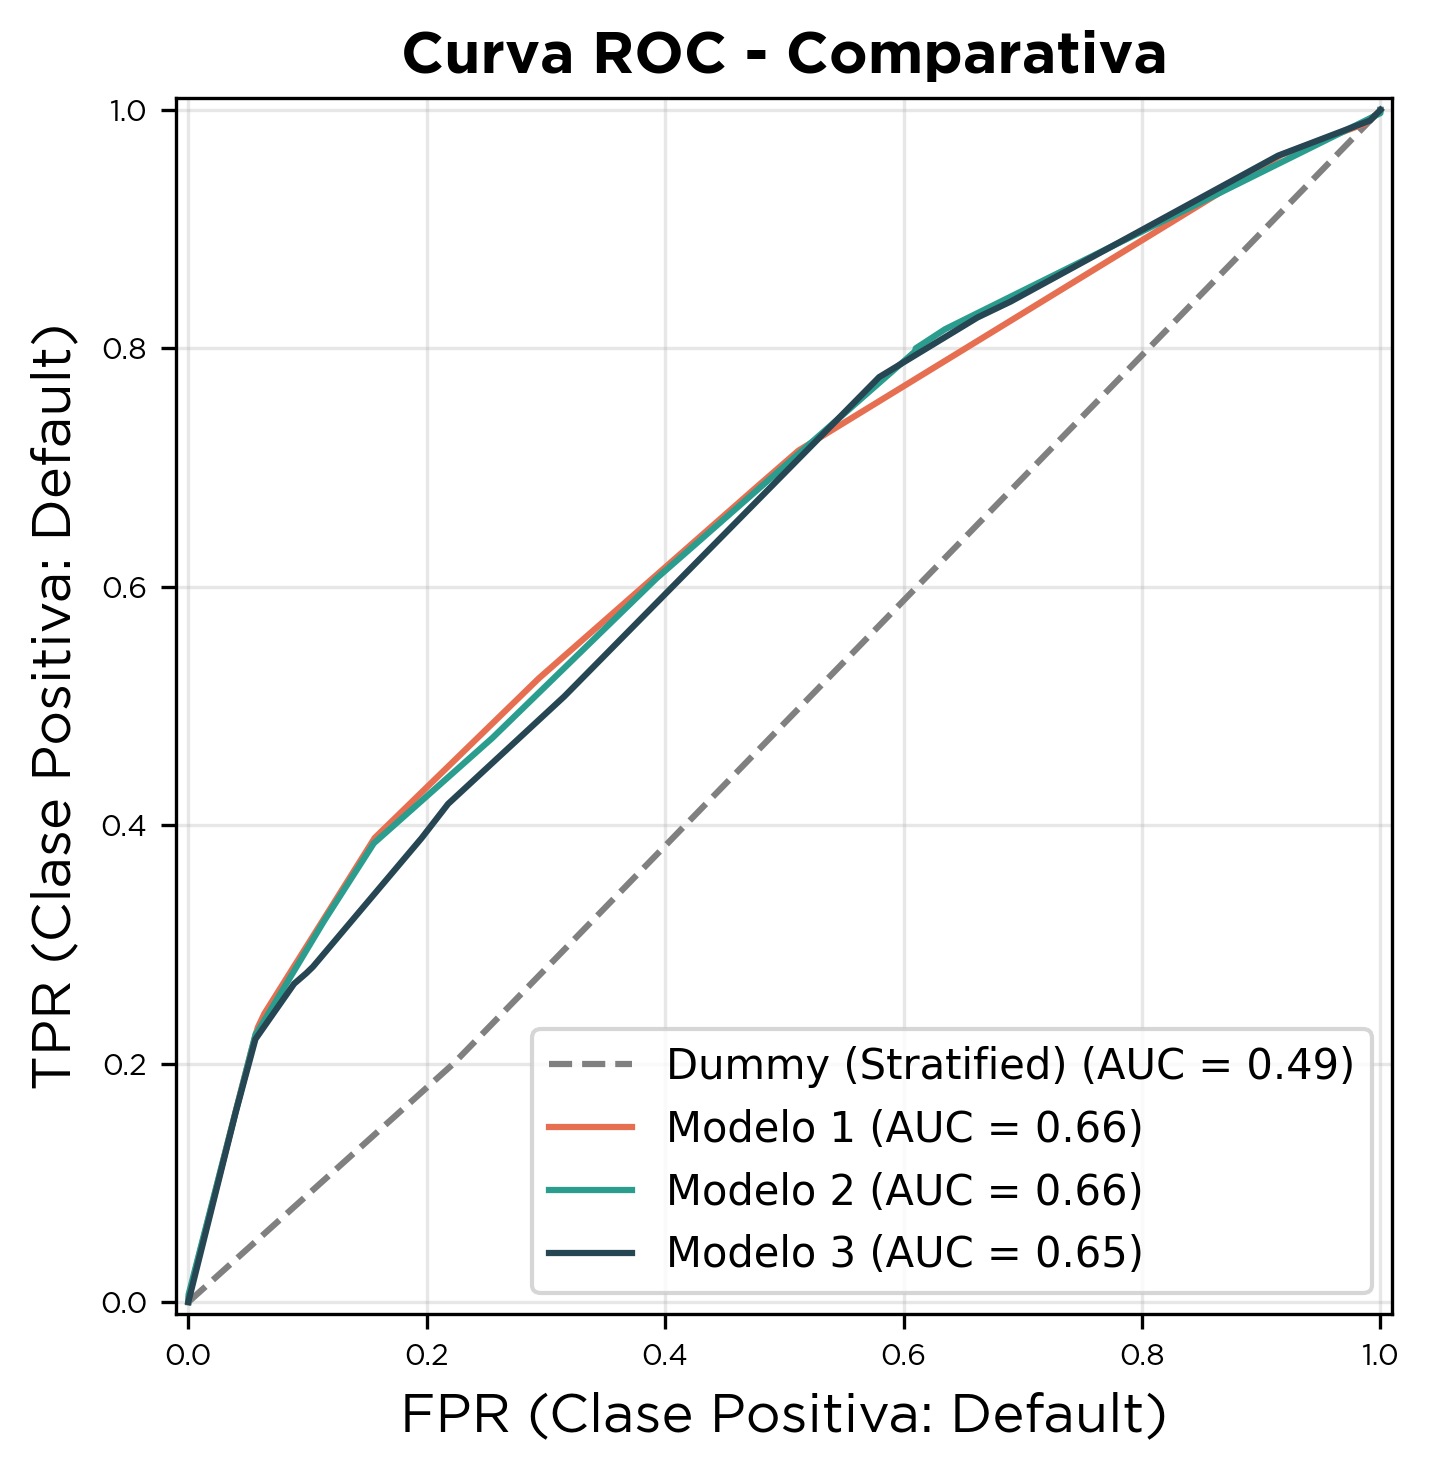

In [60]:
import matplotlib.pyplot as plt

# Visualización
fig, ax = plt.subplots(1,1,figsize=(14,5), dpi=300)

# Aumentar tamaño del texto dentro de la matriz
gotham_bold.set_size(14)
gotham.set_size(13)

# Gráfico Curva ROC
dummy_roc.plot(ax=ax, name="Dummy (Stratified)", ls="--", color="gray")
tree_1.plot(ax=ax, name="Modelo 1", ls="-", color="#E76F51")
tree_2.plot(ax=ax, name="Modelo 2", ls="-", color="#2A9D8F")
tree_3 = RocCurveDisplay.from_estimator(
    tree_modelo3, 
    X_test, 
    y_test,
    name="Modelo 3",
    color="#264653",
    ax=ax)
ax.set_xlabel('FPR (Clase Positiva: Default)', fontproperties=gotham, labelpad=5)
ax.set_ylabel('TPR (Clase Positiva: Default)', fontproperties=gotham, labelpad=5)
ax.set_title('Curva ROC - Comparativa', fontproperties=gotham_bold)
ax.grid(alpha=0.3, axis='both')

gotham.set_size(7)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(gotham)


plt.tight_layout()
plt.show()

Como podemos observar en la tabla, la mejora es sutil, pero la ventaja principal radica en contar con métricas más confiables y una cuantificación de la incertidumbre respecto a las obtenidas al separar únicamente en set de entrenamiento y de prueba:

| Método | Recall | Precision | F1-Score | AUC-ROC |
|--------|--------|-----------|----------|---------|
| Train-Test Split (80/20) | 60.7% | 30.3% | 40.4% | 0.658 |
| Validación Cruzada (5-fold) | 62.1% $\pm$ 2.1% | 31.5% $\pm$ 1.2% | 41.8% $\pm$ 0.7% | 0.671 $\pm$ 0.010 |

En cuanto a la importancia de las variables, podemos observar en el siguiente gráfico que solo 6 de las 10 variables utilizadas son discriminativas para este modelo, y ninguna de ellas es categórica. También se puede observar como las variables elegidas para el **Modelo 1** (`n_meses_deuda_sep` y `limite_credito`) siguen siendo las de mayor relevancia para modelar la probabilidad de default, concentrando el **83% de la importancia total**.

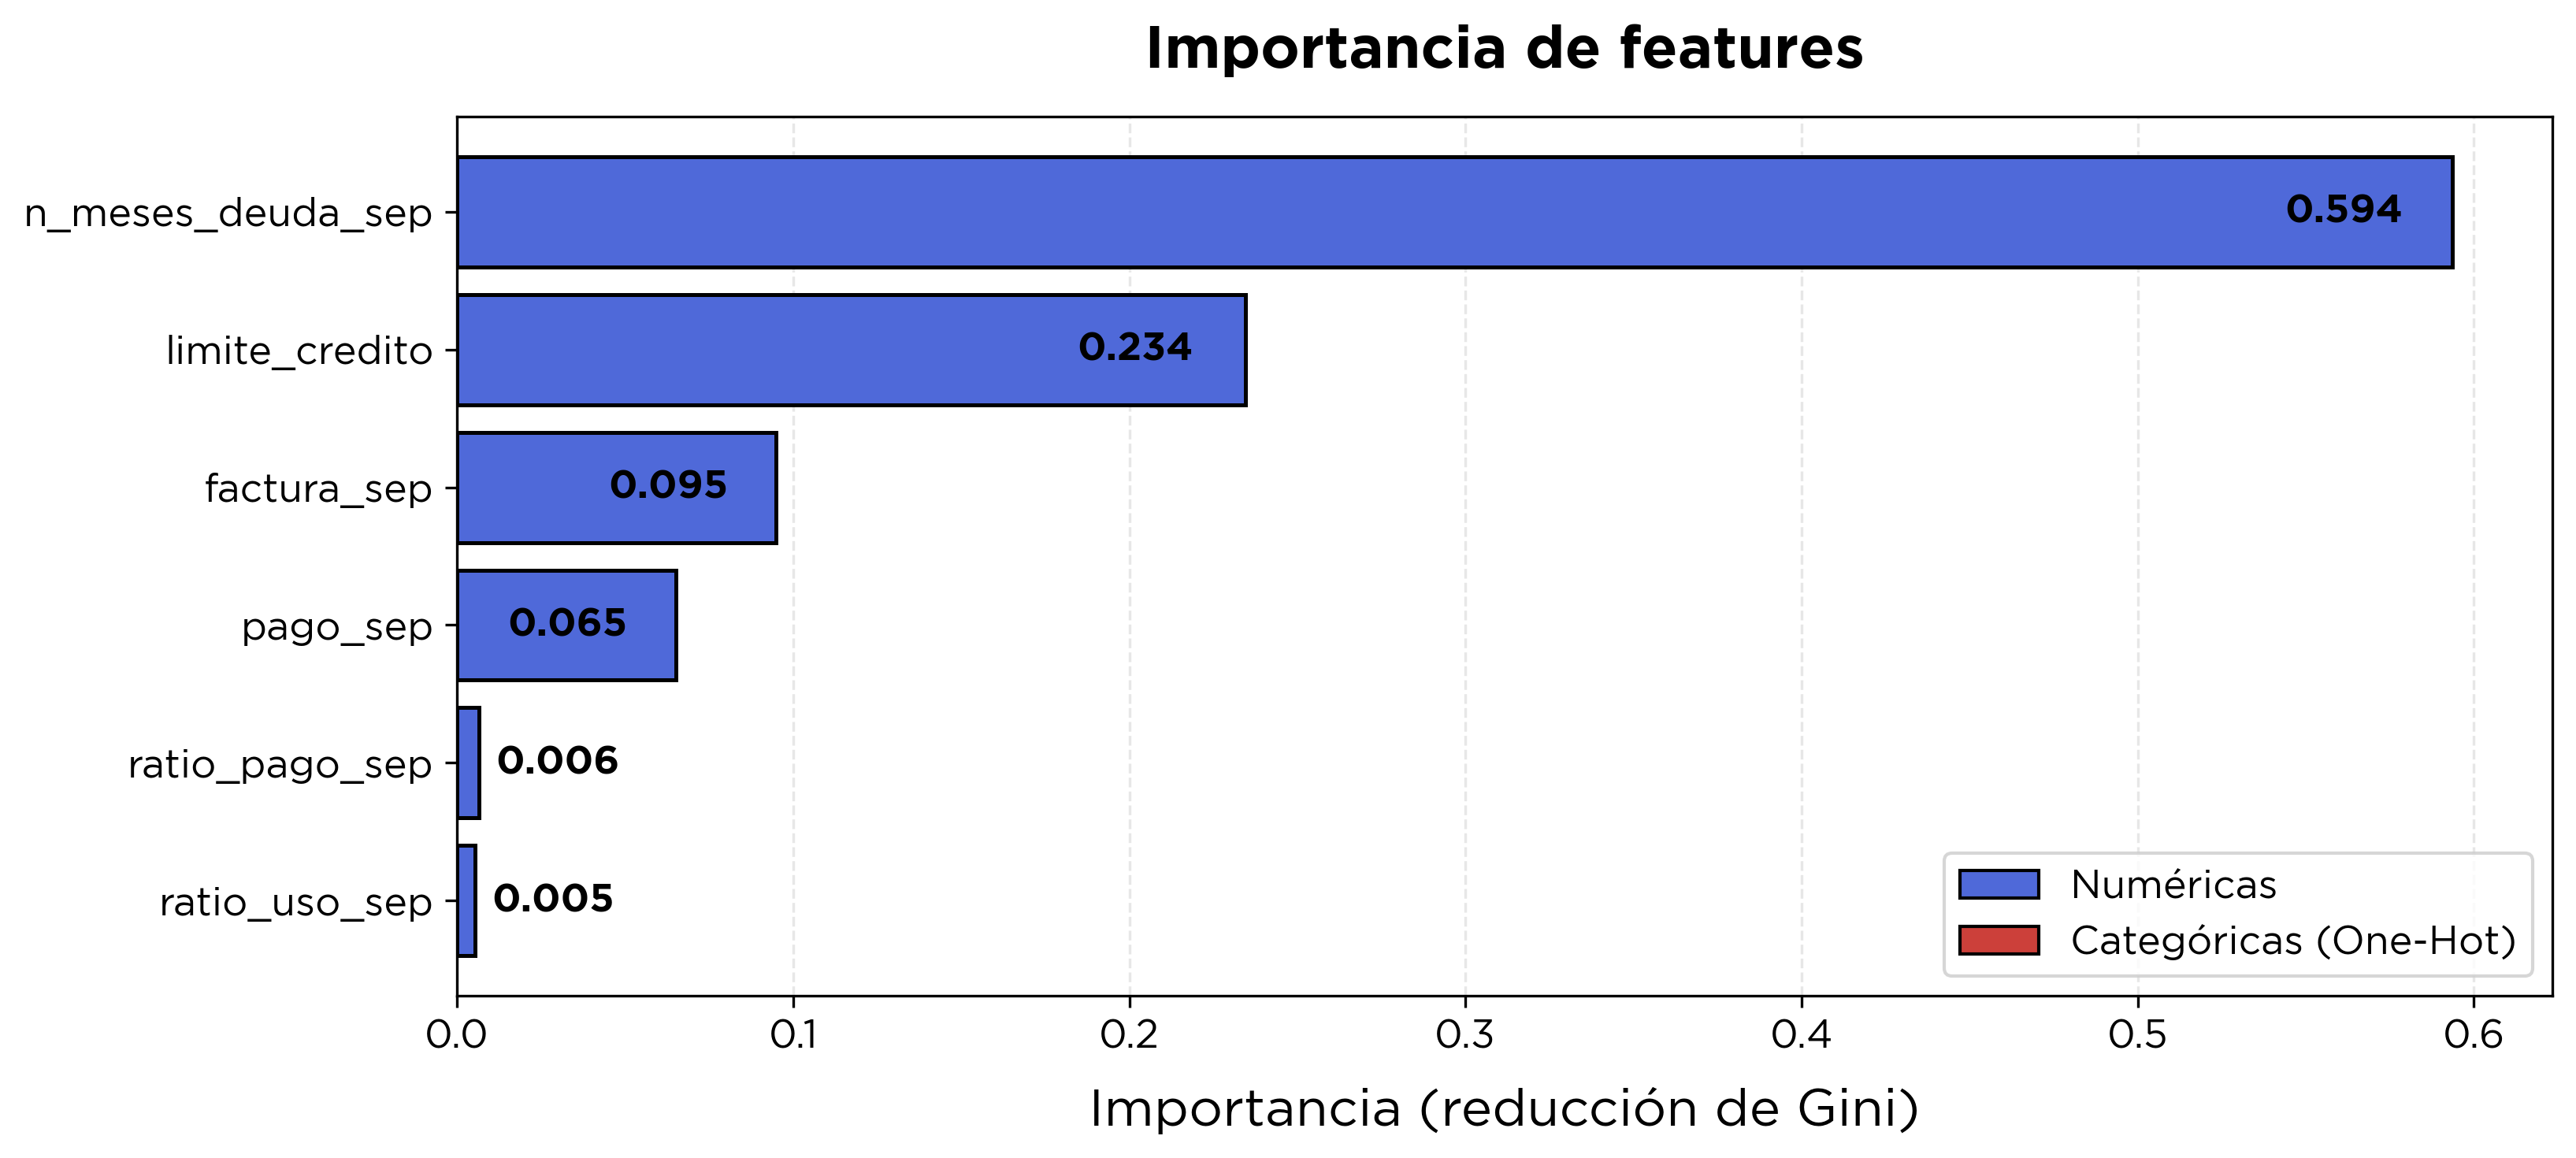

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm

# Fuentes personalizadas
prop_labels = fm.FontProperties(fname='Gotham-Book.otf', size=16)
prop_ticks = fm.FontProperties(fname='Gotham-Book.otf', size=12)
prop_title = fm.FontProperties(fname='GOTHAM-BOLD.TTF', size=18)
prop_annot = fm.FontProperties(fname='GOTHAM-BOLD.TTF', size=12)

# Obtener importancias del modelo entrenado
importancias = tree_modelo2.named_steps['classifier'].feature_importances_

num_features_names = num_features  # ['limite_credito', 'n_meses_deuda_sep', ...]

# Categóricas (one-hot)
cat_features_names = tree_modelo2.named_steps['preprocessor']\
    .named_transformers_['cat']\
    .get_feature_names_out(cat_features).tolist()

# Todas juntas
all_feature_names = num_features_names + cat_features_names

# Crear DataFrame
import pandas as pd
df_importancia = pd.DataFrame({
    'Feature': all_feature_names,
    'Importancia': importancias
}).sort_values('Importancia', ascending=False)


fig, ax = plt.subplots(figsize=(11, 5), dpi=300)

top = df_importancia[df_importancia['Importancia'] > 0]

# Colores según tipo de feature
colores = []
for feat in top['Feature']:
    if feat in num_features_names:
        colores.append('#4F69D9')  # Azul para numéricas
    else:
        colores.append('#CC403A')  # Rojo para categóricas (one-hot)

bars = ax.barh(top['Feature'], top['Importancia'], 
               color=colores, edgecolor='black', linewidth=1.2)

ax.set_xlabel(
    'Importancia (reducción de Gini)', 
    fontproperties=prop_labels,
    labelpad=10
)

ax.set_title('Importancia de features', 
             fontproperties=prop_title, pad=15)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(prop_ticks)

ax.invert_yaxis()

# Añadir valores
for i, (feat, imp) in enumerate(zip(top['Feature'], top['Importancia'])):
    if imp > 0.06:
        #ax.text(imp - 0.05, i, f'{imp:.3f}', va='center', fontsize=14, fontweight='bold')
        ax.text(imp - 0.05, i, f'{imp:.3f}', va='center', fontproperties=prop_annot)
    else:
        # ax.text(imp + 0.005, i, f'{imp:.3f}', va='center', fontsize=14, fontweight='bold')
        ax.text(imp + 0.005, i, f'{imp:.3f}', va='center', fontproperties=prop_annot)

# Leyenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#4F69D9', edgecolor='black', label='Numéricas'),
    Patch(facecolor='#CC403A', edgecolor='black', label='Categóricas (One-Hot)')
]
ax.legend(handles=legend_elements, prop=prop_ticks)
ax.set_axisbelow(True)
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

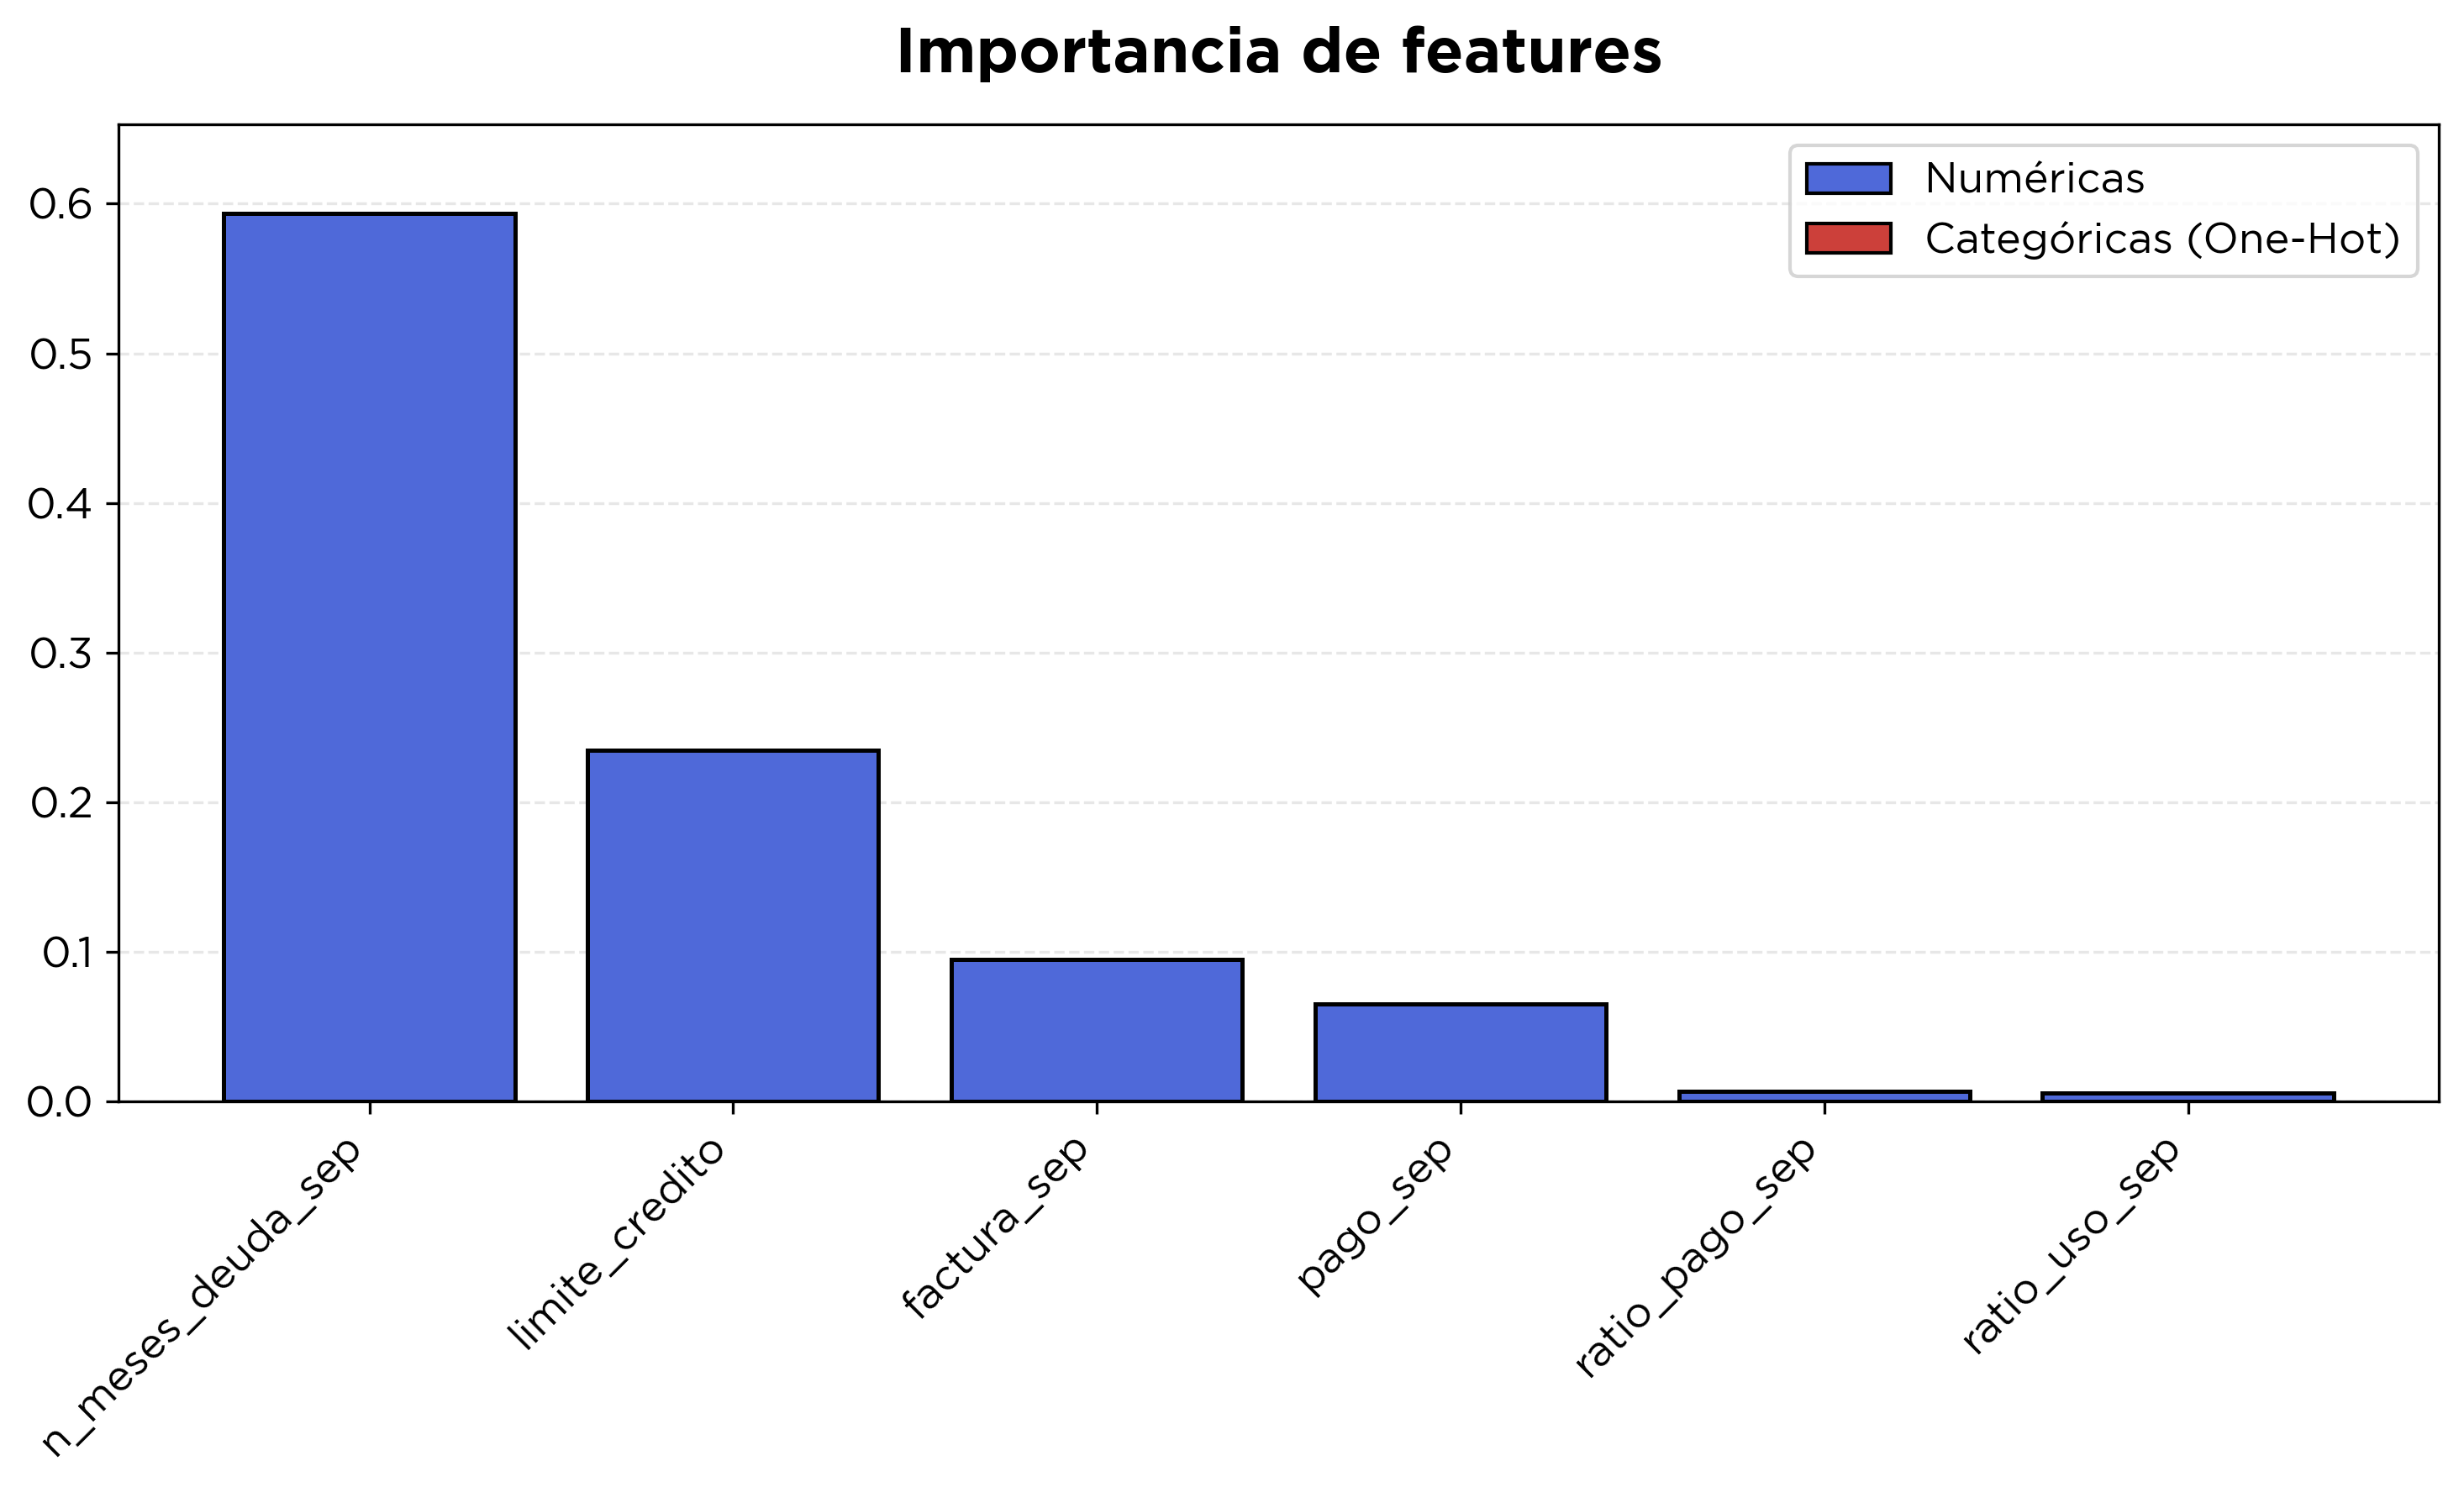

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm

# Fuentes personalizadas
prop_labels = fm.FontProperties(fname='Gotham-Book.otf', size=16)
prop_ticks = fm.FontProperties(fname='Gotham-Book.otf', size=12)
prop_title = fm.FontProperties(fname='GOTHAM-BOLD.TTF', size=18)
prop_annot = fm.FontProperties(fname='GOTHAM-BOLD.TTF', size=12)

# Obtener importancias del modelo entrenado
importancias = tree_modelo2.named_steps['classifier'].feature_importances_

num_features_names = num_features  # ['limite_credito', 'n_meses_deuda_sep', ...]

# Categóricas (one-hot)
cat_features_names = tree_modelo2.named_steps['preprocessor']\
    .named_transformers_['cat']\
    .get_feature_names_out(cat_features).tolist()

# Todas juntas
all_feature_names = num_features_names + cat_features_names

# Crear DataFrame
import pandas as pd
df_importancia = pd.DataFrame({
    'Feature': all_feature_names,
    'Importancia': importancias
}).sort_values('Importancia', ascending=False)


fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

top = df_importancia[df_importancia['Importancia'] > 0]

# Colores según tipo de feature
colores = []
for feat in top['Feature']:
    if feat in num_features_names:
        colores.append('#4F69D9')  # Azul para numéricas
    else:
        colores.append('#CC403A')  # Rojo para categóricas (one-hot)

bars = ax.bar(top['Feature'], top['Importancia'], 
              color=colores, edgecolor='black', linewidth=1.2)

# ax.set_ylabel(
#     'Importancia (reducción de Gini)', 
#     fontproperties=prop_labels,
#     labelpad=10
# )

ax.set_title('Importancia de features', 
             fontproperties=prop_title, pad=15)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(prop_ticks)

# Rotar etiquetas del eje x para mejor legibilidad
ax.tick_params(axis='x', rotation=45)
plt.setp(ax.get_xticklabels(), ha='right')

# # Añadir valores arriba de cada barra
# for i, (feat, imp) in enumerate(zip(top['Feature'], top['Importancia'])):
#     ax.text(i, imp, f'{imp:.3f}', ha='center', va='bottom', fontproperties=prop_annot)

# Ajustar el límite superior del eje Y para que los textos no se corten
# Añade un 10% extra al valor máximo
max_imp = top['Importancia'].max()
ax.set_ylim(0, max_imp * 1.1)

# Leyenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#4F69D9', edgecolor='black', label='Numéricas'),
    Patch(facecolor='#CC403A', edgecolor='black', label='Categóricas (One-Hot)')
]
ax.legend(handles=legend_elements, prop=prop_ticks)
ax.set_axisbelow(True)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

              Feature  Importancia
4   n_meses_deuda_sep     0.593709
0      limite_credito     0.234468
3         factura_sep     0.094965
2            pago_sep     0.065062
6      ratio_pago_sep     0.006496
5       ratio_uso_sep     0.005299
1                edad     0.000000
7            genero_1     0.000000
8            genero_2     0.000000
9         educacion_1     0.000000
10        educacion_2     0.000000
11        educacion_3     0.000000
12        educacion_4     0.000000
13     estado_civil_1     0.000000
14     estado_civil_2     0.000000
15     estado_civil_3     0.000000
              Feature  Importancia
4   n_meses_deuda_sep     0.449950
0      limite_credito     0.325095
2            pago_sep     0.124104
3         factura_sep     0.052265
5       ratio_uso_sep     0.034495
1                edad     0.010884
9         educacion_1     0.003208
6      ratio_pago_sep     0.000000
7            genero_1     0.000000
8            genero_2     0.000000
10        educacion_

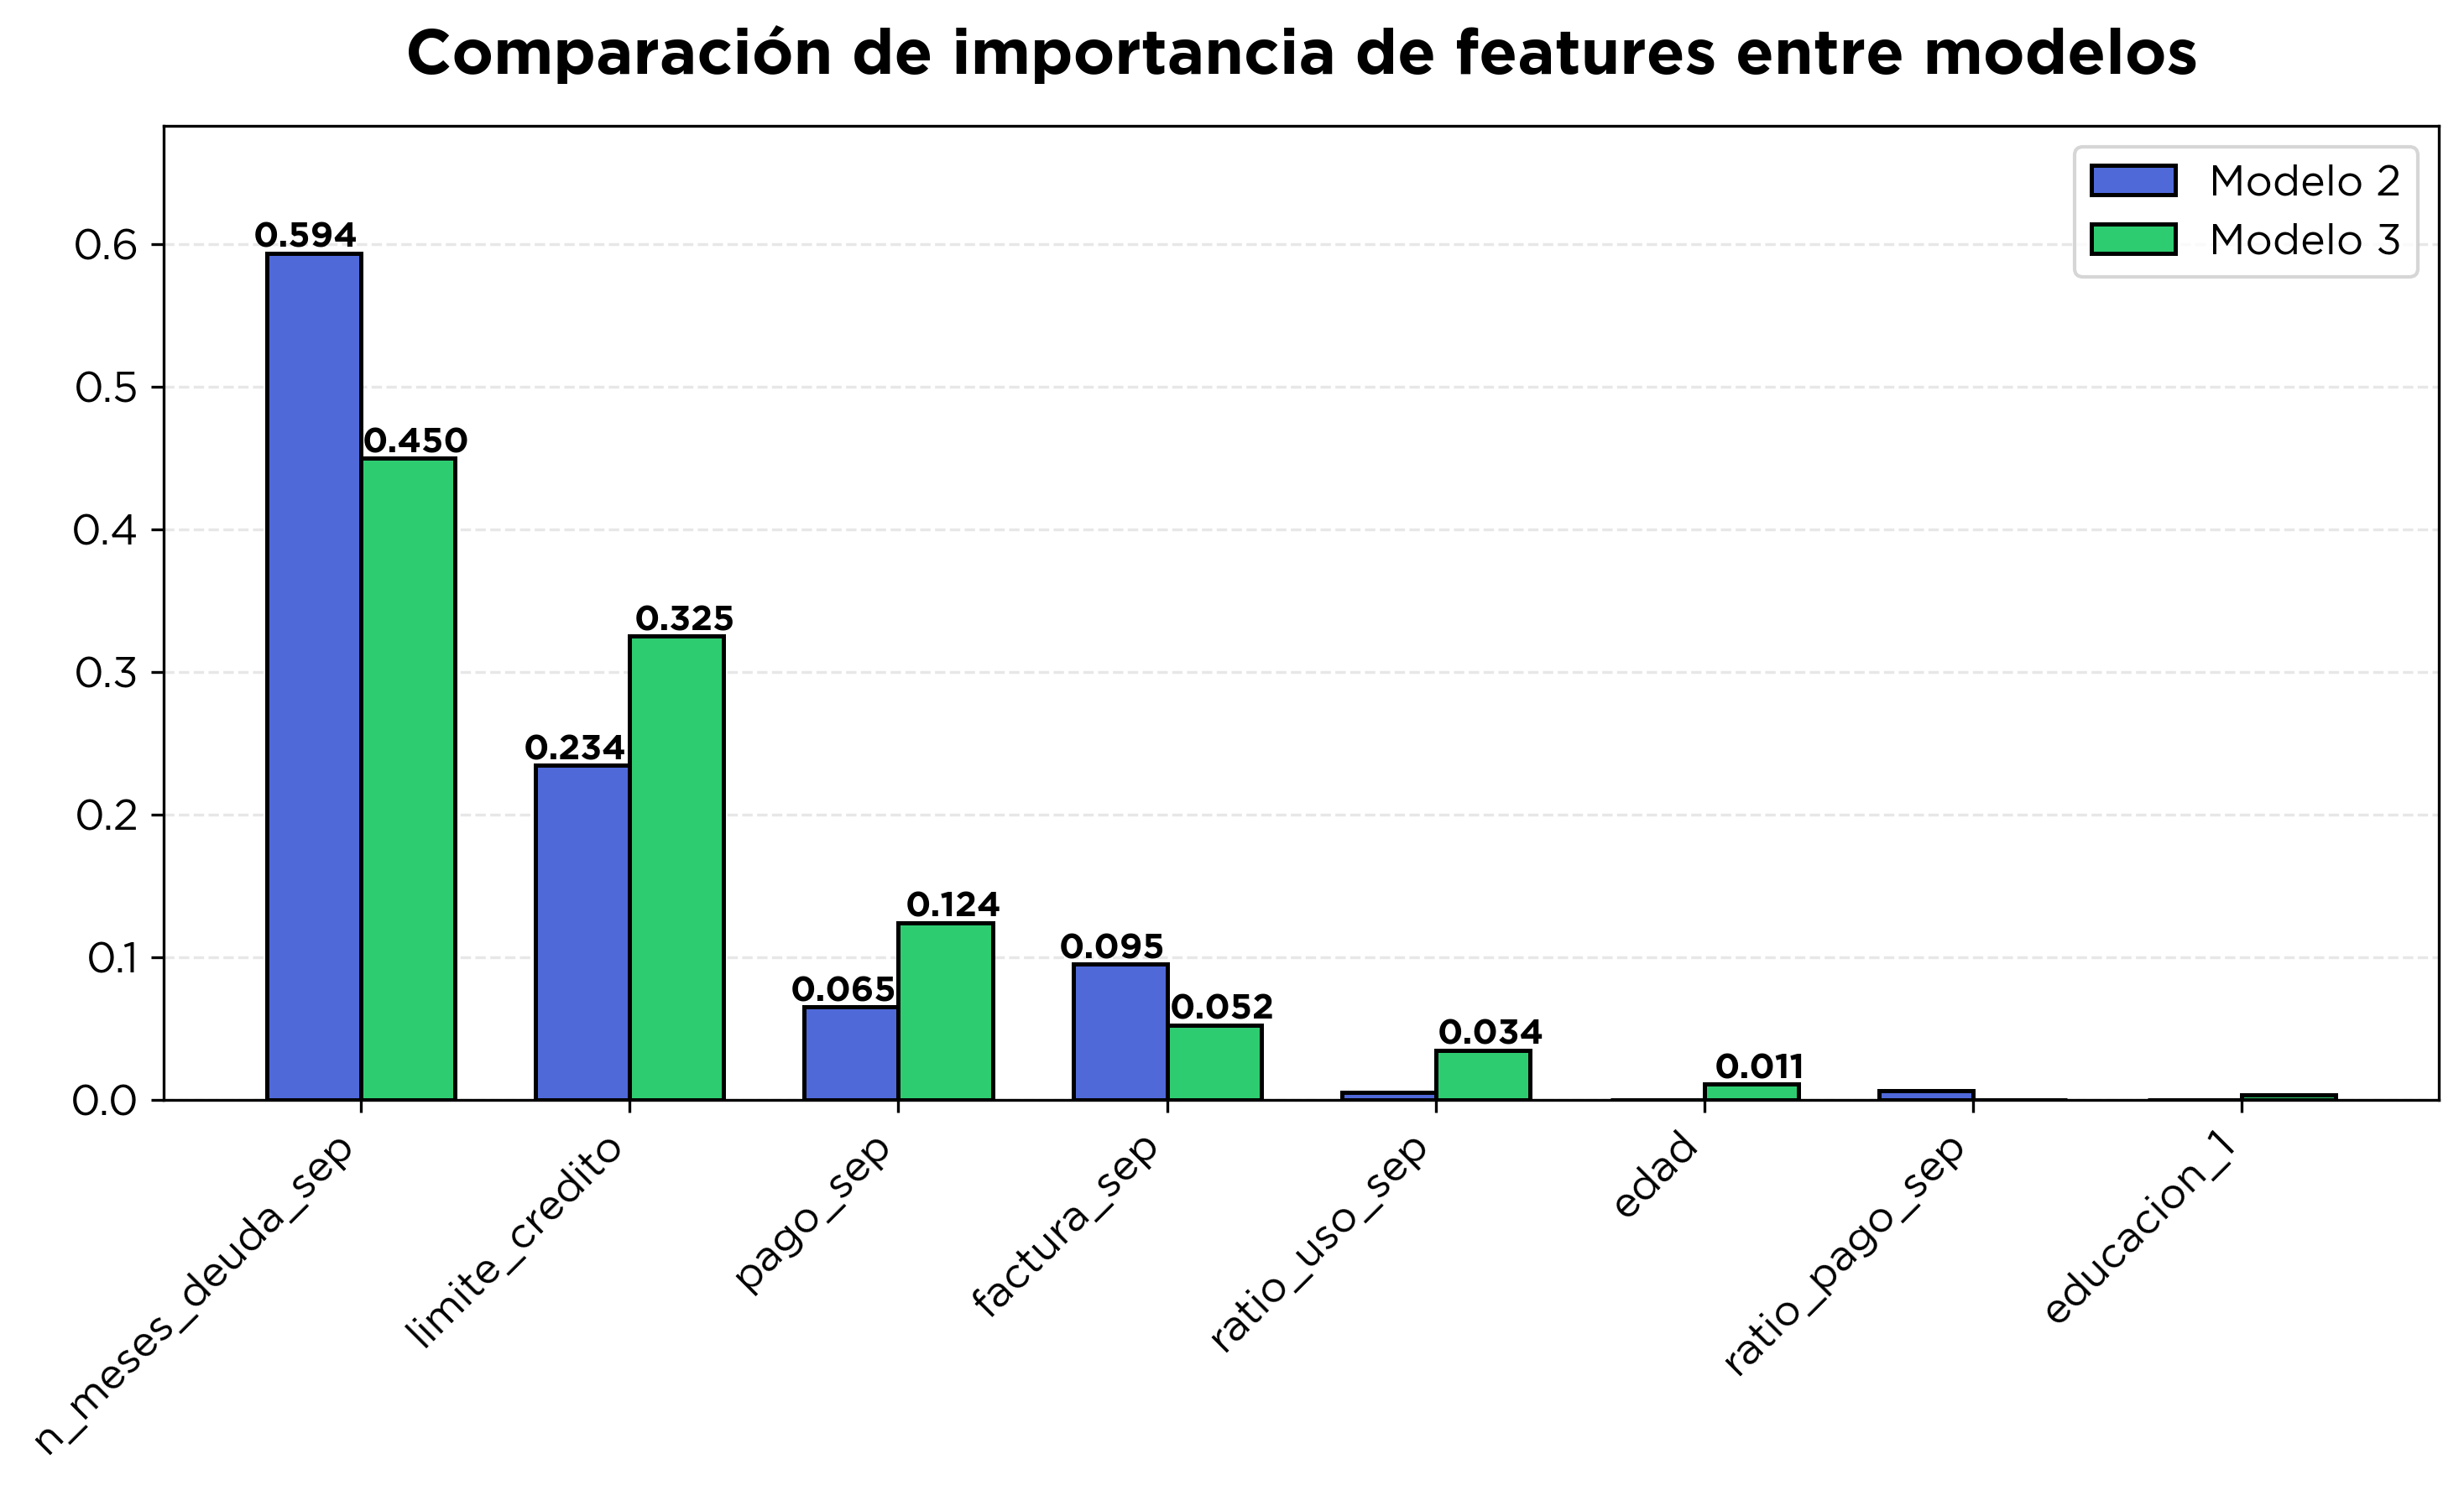

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.font_manager as fm
from matplotlib.patches import Patch

# Fuentes personalizadas
prop_labels = fm.FontProperties(fname='Gotham-Book.otf', size=16)
prop_ticks = fm.FontProperties(fname='Gotham-Book.otf', size=12)
prop_title = fm.FontProperties(fname='GOTHAM-BOLD.TTF', size=18)
prop_annot = fm.FontProperties(fname='GOTHAM-BOLD.TTF', size=10)

# Obtener importancias de ambos modelos
importancias_2 = tree_modelo2.named_steps['classifier'].feature_importances_
importancias_3 = tree_modelo3.named_steps['classifier'].feature_importances_

num_features_names = num_features

# Categóricas (one-hot) - asumiendo que ambos modelos tienen las mismas features
cat_features_names = tree_modelo2.named_steps['preprocessor']\
    .named_transformers_['cat']\
    .get_feature_names_out(cat_features).tolist()

# Todas juntas
all_feature_names = num_features_names + cat_features_names

# Ver TODAS las importancias sin filtrar
df_completo_2 = pd.DataFrame({
    'Feature': all_feature_names,
    'Importancia': importancias_2
}).sort_values('Importancia', ascending=False)

df_completo_3 = pd.DataFrame({
    'Feature': all_feature_names,
    'Importancia': importancias_3
}).sort_values('Importancia', ascending=False)

print(df_completo_2)
print(df_completo_3)

# Crear DataFrame combinado
df_importancia = pd.DataFrame({
    'Feature': all_feature_names,
    'Modelo 2': importancias_2,
    'Modelo 3': importancias_3
})

# Filtrar features con importancia > 0 en al menos uno de los modelos
df_importancia['Max_Importancia'] = df_importancia[['Modelo 2', 'Modelo 3']].max(axis=1)
top = df_importancia[df_importancia['Max_Importancia'] > 0].sort_values('Max_Importancia', ascending=False)

# Configurar el gráfico
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# Posiciones de las barras
x = np.arange(len(top))
width = 0.35  # Ancho de cada barra

# Colores para cada modelo
color_modelo2 = '#4F69D9'
color_modelo3 = '#2ECC71'

# Crear barras agrupadas
bars1 = ax.bar(x - width/2, top['Modelo 2'], width, 
               label='Modelo 2', color=color_modelo2, 
               edgecolor='black', linewidth=1.2)
bars2 = ax.bar(x + width/2, top['Modelo 3'], width, 
               label='Modelo 3', color=color_modelo3, 
               edgecolor='black', linewidth=1.2)

# Etiquetas y título
# ax.set_ylabel('Importancia (reducción de Gini)', 
#               fontproperties=prop_labels, labelpad=10)
ax.set_title('Comparación de importancia de features entre modelos', 
             fontproperties=prop_title, pad=15)
ax.set_xticks(x)
ax.set_xticklabels(top['Feature'])

# Aplicar fuentes personalizadas
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(prop_ticks)

# Rotar etiquetas del eje x
ax.tick_params(axis='x', rotation=45)
plt.setp(ax.get_xticklabels(), ha='right')

# Añadir valores arriba de cada barra
for i, (imp2, imp3) in enumerate(zip(top['Modelo 2'], top['Modelo 3'])):
    # Modelo 2
    if imp2 > 0.01:  # Solo mostrar si es significativo
        ax.text(i - width/2 -0.03, imp2, f'{imp2:.3f}', 
                ha='center', va='bottom', fontproperties=prop_annot)
    # Modelo 3
    if imp3 > 0.01:
        ax.text(i + width/2 + 0.03, imp3, f'{imp3:.3f}', 
                ha='center', va='bottom', fontproperties=prop_annot)

# Ajustar límite superior del eje Y
max_imp = top[['Modelo 2', 'Modelo 3']].max().max()
ax.set_ylim(0, max_imp * 1.15)

# Leyenda
ax.legend(prop=prop_ticks, loc='upper right')

# Grid
ax.set_axisbelow(True)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

Las restantes variables (`factura_sep`, `pago_sep`, `ratio_pago_sep` y `ratio_uso_sep`) aportan información marginal, lo que sugiere que el árbol prioriza patrones de morosidad y capacidad crediticia antes que las dinámicas de gasto o pago puntual. Esto puede indicar que con los hiperparámetros elegidos el modelo capta relaciones más estructurales que de comportamiento.

---
#### 8. Analizar y comparar los modelos obtenidos entre sí y con respecto al benchmark. ¿Qué modelo se elegiría para una posible fase operativa, y por qué?


Luego de entrenar y evaluar los distintos modelos, resumimos a continuación los principales resultados:
| Modelo | Recall | Precision | F1-Score | AUC-ROC | Features |
|--------|--------|-----------|----------|---------|----------|
| Benchmark (Aleatorio) | 20.0% | 20.2% | 20.1% | 0.489 | - |
| Modelo 1 (Árbol 2 vars) | 52.3% | 33.4% | 40.8% | 0.656 | 2 |
| Modelo 2 (Árbol completo) | **60.7%** | 30.3% | 40.4% | **0.658** | 10 |

Mejoras respecto al ***benchmark***:
- El **Modelo 1** mejoró el ***recall*** en **+162%** (20.0% $\rightarrow$ 52.3%) y el ***AUC-ROC*** en **+34%**, demostrando que `limite_credito` y `n_meses_deuda_sep` tienen poder predictivo significativo.
- El **Modelo 2** mejoró el ***recall*** en un **+204%** (20.0% $\rightarrow$ 60.7%), detectando a 6 de cada 10 clientes que caen en default. El ***AUC-ROC*** mejoro de manera similar al Modelo 1.

**Modelo 2** vs **Modelo 1**:
- ***Recall:*** tuvo una mejora relativa del **+16%** (52.3% $\rightarrow$ 60.7%). Esto significa que el segundo modelo detecta aproximadamente 18 deudores más por cada 1000 clientes, respecto al primer modelo.
- ***Precision***: tuvo una caída relativa del **-9%** (33.4% $\rightarrow$ 30.3%), coherente con el *trade-off* habitual al priorizar sensibilidad.
- ***F1-Score***: se mantiene prácticamente igual (40.8% $\rightarrow$ 40.4%), indicando que el balance ***recall/precision*** es adecuado y que no hay una caída del desempeño.
- ***AUC-ROC:*** se presenta una mejora marginal (+0.002), indicando que la capacidad de discriminación del modelo se mantiene constante en ~0.66.
- En términos de importancia de variables, se observa un patrón casi idéntico al del primer modelo, lo que podría indicar la necesidad de aumentar la profundidad del árbol o explorar modelos más complejos para captar relaciones adicionales.

Para una fase operativa elegiríamos el **Modelo 2** ya que: cumple nuestro objetivo prioritario de ***maximizar el recall*** detectando la mayor cantidad posible de deudores potenciales; mejora con respecto al **Modelo 1**, detectando un 16% más de los defaults que ese primer modelo pero manteniendo la misma complejidad en términos de profundidad del árbol; tiene un *trade-off* aceptable en cuanto a pérdida de ***precision*** por la ganancia de ***recall*** que obtenemos; y preserva la capacidad discriminativa del modelo más básico.

---
#### 9. ¿Cómo se podría continuar el trabajo?

Para continuar con el trabajo proponemos tres estrategias complementarias que buscan mejorar el desempeño de modelo, con especial énfasis en ***maximizar el recall*** manteniendo un balance adecuado con la precision. 

En primera instancia, realizaremos una **optimización de hiperparámetros** mediante ***Grid Search*** sobre el **Modelo 2**. Esta técnica nos permitirá explorar sistemáticamente diferentes combinaciones de parámetros (`max_depth`, `min_samples_split`, `min_samples_leaf`, `class_weight`) para identificar la configuración que maximice el rendimiento del modelo. 

Como demostramos en el análisis de importancia de *features*, el modelo actualmente prioriza dos de las diez variables elegidas (`n_meses_deuda_sep` y `limite_credito`). Una configuración distinta de hiperparámetros podría permitir al árbol explorar patrones más complejos y aprovechar mejor las features secundarias. 

Posteriormente, proponemos implementar un ***Random Forest***. Este algoritmo *ensemble*, que combina múltiples árboles de decisión, nos va a permitir obtener un modelo de mayor robustez y capacidad de generalización al reducir la varianza promediando las predicciones de múltiples árboles. Por otro lado, cada árbol se entrena con un subconjunto aleatorio de *features* en cada *split*, controlado por el parámetro `max_features`. Dado que nuestros modelos individuales concentran importancia en dos variables, ***Random Forest*** forzará a algunos árboles a construirse priorizando otras *features*, explorando caminos alternativos de decisión basados en las variables secundarias como `ratio_uso_sep`, `ratio_pago_sep` y las variables demográficas. Esto podría revelar patrones complementarios que un árbol único no captura.

Finalmente, consideramos modificar el **umbral de clasificación** analizando la curva ***Precision-Recall***. Por defecto, los modelos clasifican como default cuando la probabilidad predicha es mayor o igual a 0.5, pero este umbral no necesariamente optimiza nuestro objetivo de negocio. Nuestro objetivo principal será buscar un umbral que nos permita maximizar el *recall* manteniendo una precision mínima aceptable, recordando que el *recall* es crucial en nuestro problema dado el alto costo de los falsos negativos.

---
#### Intento de Random Forest

In [ ]:
# ============================================
# Random Forest: coarse grid + 1-SE + fine grid
# con métricas robustas, gap train–CV y Top-10 ± std
# ============================================

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import (make_scorer, recall_score, precision_score, f1_score,
                             accuracy_score, roc_auc_score, average_precision_score,
                             classification_report, confusion_matrix)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
import numpy as np
import pandas as pd

# =========================
# 0) Helpers
# =========================
def get_ohe_feature_names(preprocessor, num_features, cat_features):
    ohe = preprocessor.named_transformers_['cat']
    cat_names = ohe.get_feature_names_out(cat_features)
    return np.r_[num_features, cat_names]

def _mfeat_order(val):
    # Para simplicidad: menos features por split es "más simple"
    # orden: 'sqrt' (más simple) < 'log2' < fracciones numéricas < None (todas)
    if val == 'sqrt': return 0
    if val == 'log2': return 1
    if isinstance(val, (int, float)): return 2
    if val is None: return 3
    return 4

def simplicity_key_rf(params):
    """
    Orden de simplicidad (bosque):
      1) menor max_depth
      2) mayor min_samples_leaf
      3) mayor min_samples_split
      4) menor n_estimators
      5) menor max_features (según _mfeat_order)
      (bootstrap=True y class_weight='balanced_subsample' fijos)
    """
    d = params.get('classifier__max_depth', None)
    depth_val = 9999 if d is None else d
    leaf = params.get('classifier__min_samples_leaf', 1)
    split = params.get('classifier__min_samples_split', 2)
    nest = params.get('classifier__n_estimators', 100)
    mfeat = params.get('classifier__max_features', 'sqrt')
    return (depth_val, -leaf, -split, nest, _mfeat_order(mfeat))

def neighbors(val, pool):
    if val not in pool:
        return [val]
    i = pool.index(val)
    cand = {val}
    if i-1 >= 0: cand.add(pool[i-1])
    if i+1 < len(pool): cand.add(pool[i+1])
    return sorted(cand, key=lambda x: pool.index(x))

def show_cv_gap(cv_results, idx, metrics=('recall','precision','f1','accuracy')):
    print("\n== GAP train–CV en la mejor combinación (5-fold) ==")
    for m in metrics:
        mt = cv_results.loc[idx, f'mean_test_{m}']
        st = cv_results.loc[idx, f'std_test_{m}']
        mr = cv_results.loc[idx, f'mean_train_{m}']
        sr = cv_results.loc[idx, f'std_train_{m}']
        print(f"{m:9s}: train {mr:.4f}±{sr:.4f} | cv {mt:.4f}±{st:.4f} | gap {mr-mt:+.4f}")

def topn_table(cv_results, n=10, key='mean_test_recall'):
    mets = ['recall','precision','f1','accuracy']
    cols = []
    for m in mets:
        cols += [f'mean_test_{m}', f'std_test_{m}']
    out = (cv_results[['params'] + cols]
           .sort_values(key, ascending=False)
           .head(n)
           .copy())
    for m in mets:
        out[m] = out.apply(lambda r: f"{r[f'mean_test_{m}']:.4f} ± {r[f'std_test_{m}']:.4f}", axis=1)
    keep = ['params'] + mets
    return out[keep]

# =========================
# 1) Pipeline base
# =========================
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

rf = RandomForestClassifier(
    class_weight='balanced_subsample',  # mejor para desbalance
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf)
])

# =========================
# 2) Train/test split
# =========================
X = df[num_features + cat_features]
y = df['default_oct']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =========================
# 3) Grid grueso (coarse)
# =========================
grid_depth = [None, 4, 6, 8]           # None = sin tope
grid_leaf  = [1, 5, 10]
grid_split = [2, 10, 20]
grid_mfeat = ['sqrt', 'log2', 0.5]     # 0.5 = 50% de features
grid_nest  = [100, 300, 600]

param_grid = {
    'classifier__n_estimators': grid_nest,
    'classifier__max_depth': grid_depth,
    'classifier__min_samples_split': grid_split,
    'classifier__min_samples_leaf': grid_leaf,
    'classifier__max_features': grid_mfeat,
    # NOTA: no usamos ccp_alpha aquí; los bosques ya promedian/recortan varianza
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0),
    'accuracy': make_scorer(accuracy_score),
}

grid_search = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    refit='recall',
    n_jobs=-1,
    verbose=1,
    return_train_score=True,
    error_score=np.nan
)

print(">>> Grid Search (coarse, RF) ...")
grid_search.fit(X_train, y_train)

cv_results = pd.DataFrame(grid_search.cv_results_)
best_idx = grid_search.best_index_
best_params = grid_search.best_params_

print("\nMejores hiperparámetros (coarse, por recall):")
for k, v in best_params.items():
    print(f"  {k}: {v}")

show_cv_gap(cv_results, best_idx, metrics=('recall','precision','f1','accuracy'))

# =========================
# 4) Regla del 1-SE + modelo más simple empatado
# =========================
mean_best = cv_results.loc[best_idx, 'mean_test_recall']
std_best  = cv_results.loc[best_idx, 'std_test_recall']
th_1se = mean_best - std_best

empatados = cv_results[cv_results['mean_test_recall'] >= th_1se].copy()
empatados['simplicity'] = empatados['params'].apply(simplicity_key_rf)
row_simple = empatados.sort_values(['simplicity']).iloc[0]
simple_params = row_simple['params']

print(f"\nRegla 1-SE (RF): umbral = {th_1se:.4f}")
print("Parámetros más simples dentro del 1-SE (RF):")
for k, v in simple_params.items():
    print(f"  {k}: {v}")

# =========================
# 5) Grid fino (vecindario del modelo simple)
# =========================
md   = simple_params['classifier__max_depth']
msl  = simple_params['classifier__min_samples_leaf']
mss  = simple_params['classifier__min_samples_split']
mfeat= simple_params.get('classifier__max_features', 'sqrt')
nest = simple_params['classifier__n_estimators']

fine_grid = {
    'classifier__n_estimators': neighbors(nest, grid_nest),
    'classifier__max_depth': neighbors(md, grid_depth) if md in grid_depth else [md],
    'classifier__min_samples_leaf': neighbors(msl, grid_leaf),
    'classifier__min_samples_split': neighbors(mss, grid_split),
    'classifier__max_features': neighbors(mfeat, grid_mfeat) if mfeat in grid_mfeat else [mfeat],
}

fine_search = GridSearchCV(
    estimator=rf_pipe,
    param_grid=fine_grid,
    cv=cv,
    scoring=scoring,
    refit='recall',
    n_jobs=-1,
    verbose=1,
    return_train_score=True,
    error_score=np.nan
)

print("\n>>> Grid Search (fine, RF, vecindario 1-SE) ...")
fine_search.fit(X_train, y_train)

fine_results = pd.DataFrame(fine_search.cv_results_)
fine_best = fine_search.best_estimator_
fine_best_params = fine_search.best_params_
fine_best_idx = fine_search.best_index_

print("\nMejores hiperparámetros (fine, RF, por recall):")
for k, v in fine_best_params.items():
    print(f"  {k}: {v}")

show_cv_gap(fine_results, fine_best_idx, metrics=('recall','precision','f1','accuracy'))

# =========================
# 6) Evaluación en TEST (umbral 0.5) + AUC y AUC-PR SOLO en TEST
# =========================
y_pred = fine_best.predict(X_test)
y_proba = fine_best.predict_proba(X_test)[:, 1]

test_metrics = {
    'Recall': recall_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, zero_division=0),
    'F1-Score': f1_score(y_test, y_pred, zero_division=0),
    'Accuracy': accuracy_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_proba),
    'AUC-PR': average_precision_score(y_test, y_proba)
}
print("\nResultados en TEST (umbral = 0.5):")
for k, v in test_metrics.items():
    print(f"  {k:12s}: {v:.4f}")

print("\nReporte de clasificación (TEST):")
print(classification_report(y_test, y_pred, digits=4))
print("\nMatriz de confusión (TEST):")
print(confusion_matrix(y_test, y_pred))

# =========================
# 7) TOP-10 (coarse) con media ± std
# =========================
print("\nTOP-10 combinaciones (coarse, RF) por recall, con desviación:")
print(topn_table(cv_results, n=10).to_string(index=False))

# =========================
# 8) Interpretabilidad rápida (importancias de variables)
# =========================
best_preproc = fine_best.named_steps['preprocessor']
feat_names = get_ohe_feature_names(best_preproc, num_features, cat_features)

rf_clf = fine_best.named_steps['classifier']
importancias = pd.Series(rf_clf.feature_importances_, index=feat_names)\
                .sort_values(ascending=False)

print("\nTop-15 importancias de variables (RF):")
print(importancias.head(15).round(4).to_string())


### Modelo extra: Regresión Logística

Inicialmente, implementamos un *pipeline* de preprocesamiento que aplica la función `StandardScaler` estandarizando las features a media 0 y desviación estándar 1. Esto es necesario porque nuestras variables tienen rangos muy dispares y la regresión logística es sensible a estas diferencias, lo que podría causar que el modelo asigne mayor importancia a features con valores de mayor magnitud, independientemente del poder predictivo real. 

Por otro lado, incluimos el hiperparámetro `class_weight='balanced'` que ajusta los pesos de cada clase de forma inversamente proporcional a su frecuencia. Esto es necesario porque la variable objetivo presenta un desbalance significativo con un 78% de las observaciones en la clase negativa (no default) y 22% en la clase positiva (default). Este ajuste penaliza más los errores en la clase minoritaria, favoreciendo nuestro objetivo de maximizar el ***recall***

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (recall_score, precision_score, f1_score,
                             roc_auc_score, confusion_matrix,
                             classification_report)

In [ ]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=5000, class_weight='balanced'))
])

In [ ]:
X = df[['limite_credito', 'n_meses_deuda_sep']]
y = df['default_oct']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
y_pred_proba = pipe.predict_proba(X_test)[:, 1]

In [ ]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred, pos_label=1):.3f}")
print(f"Precision: {precision_score(y_test, y_pred, pos_label=1, zero_division=0):.3f}")
print(f"F1-Score: {f1_score(y_test, y_pred, pos_label=1):.3f}")
print(f"ROC-AUC score: {roc_auc_score(y_test, y_pred_proba):.3f}")

In [ ]:
import matplotlib.pyplot as plt

# Visualización
fig, axes = plt.subplots(1,2,figsize=(14,5))

# Matriz de confusión
lr_cm = ConfusionMatrixDisplay.from_estimator(
    pipe, X_test, y_test,
    cmap=plt.cm.Blues,
    labels=[1,0],
    display_labels=['Default', 'No Default'],
    colorbar=False,
    ax=axes[0])
axes[0].set_xlabel("Valores predichos", fontsize=12)
axes[0].set_ylabel("Valores reales", fontsize=12)
axes[0].set_title('Matriz de Confusión - Regresión Logística', fontsize=13, fontweight='bold')

# Gráfico Curva ROC
lr_roc = RocCurveDisplay.from_estimator(
    pipe, 
    X_test, 
    y_test,
    name="Regresión Logística",
    ax=axes[1])
dummy_roc.plot(ax=axes[1], name="Dummy (Stratified)", ls="--", color="gray")
axes[1].set_xlabel('FPR (Clase Positiva: Default)', fontsize=12)
axes[1].set_ylabel('TPR (Clase Positiva: Default)', fontsize=12)
axes[1].set_title('Curva ROC - Regresión Logística', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3, axis='both')

plt.tight_layout()
plt.show()